# Key Project Strategy Simulator - Bulge Events

The essential procedure for this simulation follows that outlined in kp_simulator.ipynb, but adapted for events detected in the Galactic Bulge by OGLE and MOA.

In [1]:
import numpy as np
from astropy.io import fits
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time
import healpy as hp
import random
import matplotlib.pyplot as plt
import csv
from pyLIMA import event
from pyLIMA import telescopes
from pyLIMA import microlmodels
from pyLIMA import microlmagnification
from pyLIMA import microlsimulator
from pyLIMA import microltoolbox
from pyLIMA import microloutputs
import jplhorizons_utils
import visibility_utils
import healpixel_functions
from scipy import interpolate, optimize
import h5py
from os import path
import copy

## Bulge Event Sky Locations

OGLE and MOA have observed an extensive region in the Galactic Bulge for about 25yrs from single-site telescopes in Chile and New Zealand respectively.  More recently, KMTNet has begun to observe a slightly smaller and overlapping region from its three sites in Chile, Australia and South Africa at high (~15min) cadence.  This means that events in this region essentially do not need follow-up within this central high cadence zone, but selected events in the surrounding annulus still do.  

The notebook bulge_extended_survey_region identifies those regions where follow-up is still of value, and outputs a map of the expected rate of events within this region, which we read in here. 

In [2]:
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
hp.nside2resol(NSIDE, arcmin = True)/60.0

0.9161297098179749

In [3]:
map_file_path = 'bulge_extended_zone_map.fits'
with fits.open(map_file_path) as hdul:
    data_table = hdul[1].data

coords = SkyCoord(data_table['RA'], data_table['Dec'], frame='icrs', unit=(u.hourangle, u.deg))

event_rate_table = Table([
                            Column(name="HP", data=data_table['hp_index'], dtype='int'),
                            Column(name="RA", data=data_table['RA'], dtype='str'),
                            Column(name="Dec", data=data_table['Dec'], dtype='str'),
                            Column(name="field_centre", data=coords),
                            Column(name="Gamma", data=data_table['gamma'], dtype='float'),
                            ])
event_rate_table

HP,RA,Dec,field_centre,Gamma
int64,str12,str12,object,float64
1,03:00:00,+89:16:08.50,"<SkyCoord (ICRS): (ra, dec) in deg\n (45., 89.26902778)>",0.0
2,09:00:00,+89:16:08.50,"<SkyCoord (ICRS): (ra, dec) in deg\n (135., 89.26902778)>",0.0
3,15:00:00,+89:16:08.50,"<SkyCoord (ICRS): (ra, dec) in deg\n (225., 89.26902778)>",0.0
4,21:00:00,+89:16:08.50,"<SkyCoord (ICRS): (ra, dec) in deg\n (315., 89.26902778)>",0.0
5,01:30:00,+88:32:16.90,"<SkyCoord (ICRS): (ra, dec) in deg\n (22.5, 88.53802778)>",0.0
6,04:30:00,+88:32:16.90,"<SkyCoord (ICRS): (ra, dec) in deg\n (67.5, 88.53802778)>",0.0
...,...,...,...,...
49146,16:30:00,-88:32:16.90,"<SkyCoord (ICRS): (ra, dec) in deg\n (247.5, -88.53802778)>",0.0
49147,19:30:00,-88:32:16.90,"<SkyCoord (ICRS): (ra, dec) in deg\n (292.5, -88.53802778)>",0.0


We need a distribution function for events in RA, Dec.  However, unlike for Gaia and ZTF, we also want to keep the exclusion zone in the centre of the Bulge, so no smoothing is done here. 

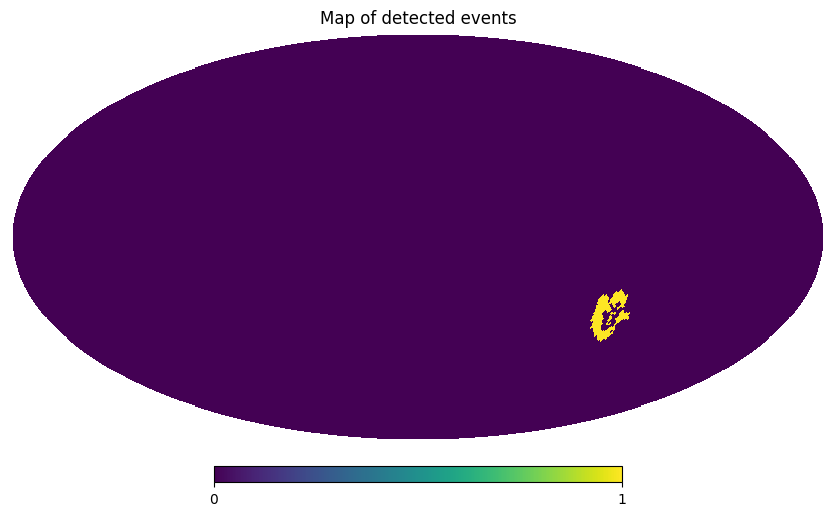

In [4]:
true_event_map = np.zeros(NPIX)
true_event_hp = np.where(event_rate_table['Gamma'] != 0.0)
true_event_map[true_event_hp] += 1.0
hp.mollview(true_event_map, title='Map of detected events')

We want to draw a random sample of events, using this data to generate a realistic sample of where these targets will be located.  This should generate a list of HEALpixels where the simulated events are deemed to be located. 

In [5]:
n_samples = 1000
sim_event_hp = random.choices(np.arange(0,NPIX,1), weights=true_event_map, k=n_samples)

Now plot the original map of actual detected event positions and overplot the on-sky positions of the simulated event sample.

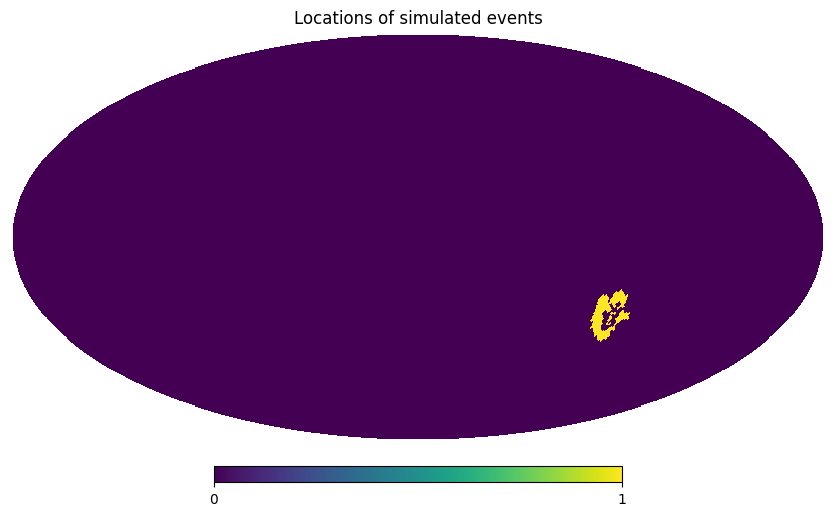

In [6]:
sim_event_map = np.zeros(NPIX)
sim_event_map[sim_event_hp] += 1.0
hp.mollview(sim_event_map, title='Locations of simulated events')

Now convert the HEALpixel positions simulated for the sample of events to RA, Dec locations, assuming that the events are located at the HEALpixel centroids.  

In [7]:
sim_event_coords = event_rate_table['field_centre'][sim_event_hp]
sim_event_coords

"<SkyCoord (ICRS): (ra, dec) in deg\n (270., -36.42357222)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (274.21875, -30.69158611)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (275.625, -22.66960833)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (271.40625, -30.69158611)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (274.21875, -33.51005556)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (266.484375, -23.31795556)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (275.625, -27.95318611)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (262.265625, -27.27961111)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (265.078125, -34.22886389)>"
...
"<SkyCoord (ICRS): (ra, dec) in deg\n (264.375, -33.51005556)>"


## Bulge Event Baseline Magnitudes

Next we need to simulate the lightcurve data that OGLE or MOA would produce for these events.  

The first quantity we need is the baseline magnitude of the events.  We derive this by examining the information from the OGLE Early Warning System (http://ogle.astrouw.edu.pl/ogle4/ews/) since this is the easist catalog to machine parse and is the largest and most self-consistent.  The MOA events are drawn from the same overall region, so this should be representative for both surveys.  

The code harvest_ogle_events.py was used to download the full dataset on OGLE alerted events, including data on the baseline magnitude and blend flux.  

In [8]:
def read_ogle_catalog(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        for row in reader:
            s = SkyCoord(row[1], row[2], frame='icrs', unit=(u.hourangle, u.deg))
            mag = float(row[3])
            f_bl = float(row[4])
            data.append([row[0], row[1], row[2], mag, f_bl, s])
    data = np.array(data)

    event_table = Table(
                        [Column(data=data[:,0], name='Event'),
                        Column(data=data[:,1], name='RA'),
                        Column(data=data[:,2], name='Dec'),
                        Column(data=data[:,3], name='Mag'),
                        Column(data=data[:,4], name='Blending'),
                        Column(data=data[:,5], name='Coordinate')]
                        )

    return event_table

In [11]:
catalog_file = './ogle/ogle_event_data.csv'
ogle_catalog = read_ogle_catalog(catalog_file)
ogle_catalog

Event,RA,Dec,Mag,Blending,Coordinate
object,object,object,object,object,object
OGLE-2002-BLG-001,17:51:16.16,-30:12:31.4,16.638,0.422,"<SkyCoord (ICRS): (ra, dec) in deg\n (267.81733333, -30.20872222)>"
OGLE-2002-BLG-002,17:50:45.43,-30:04:13.9,17.692,1.0,"<SkyCoord (ICRS): (ra, dec) in deg\n (267.68929167, -30.07052778)>"
OGLE-2002-BLG-003,17:54:25.85,-29:54:27.5,18.812,1.0,"<SkyCoord (ICRS): (ra, dec) in deg\n (268.60770833, -29.90763889)>"
OGLE-2002-BLG-004,17:53:55.77,-29:53:32.0,17.424,0.267,"<SkyCoord (ICRS): (ra, dec) in deg\n (268.482375, -29.89222222)>"
OGLE-2002-BLG-005,17:57:10.20,-29:43:41.8,18.576,1.0,"<SkyCoord (ICRS): (ra, dec) in deg\n (269.2925, -29.72827778)>"
OGLE-2002-BLG-006,17:56:29.86,-29:26:27.5,18.542,1.0,"<SkyCoord (ICRS): (ra, dec) in deg\n (269.12441667, -29.44097222)>"
...,...,...,...,...,...
OGLE-2019-BLG-1520,17:55:27.65,-29:03:54.8,19.67,1.0,"<SkyCoord (ICRS): (ra, dec) in deg\n (268.86520833, -29.06522222)>"
OGLE-2019-BLG-1521,17:56:27.91,-30:31:37.9,16.633,1.0,"<SkyCoord (ICRS): (ra, dec) in deg\n (269.11629167, -30.52719444)>"


Text(0.5, 1.0, 'Distribution of baseline magnitudes of OGLE events')

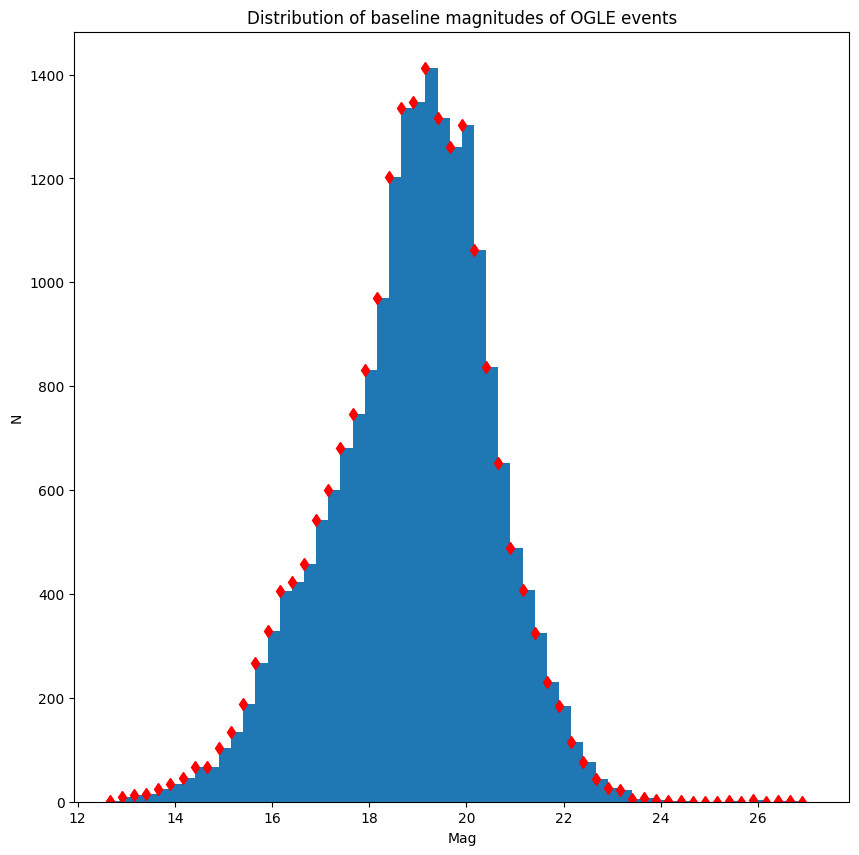

In [12]:
mag_min = ogle_catalog['Mag'].min()
mag_max = ogle_catalog['Mag'].max()
(mag_dist, mag_bins) = np.histogram(ogle_catalog['Mag'], bins=np.arange(mag_min, mag_max, 0.25))


fig = plt.figure(1,(10,10))
plt.hist(ogle_catalog['Mag'], bins=mag_bins)
plt.plot(mag_bins[0:-1], mag_dist, 'rd')
plt.xlabel('Mag')
plt.ylabel('N')
plt.title('Distribution of baseline magnitudes of OGLE events')

Now we can use this distribution to simulate a realistic range of baseline magnitudes for OGLE detections

Text(0.5, 1.0, 'Distribution of simulated OGLE detections')

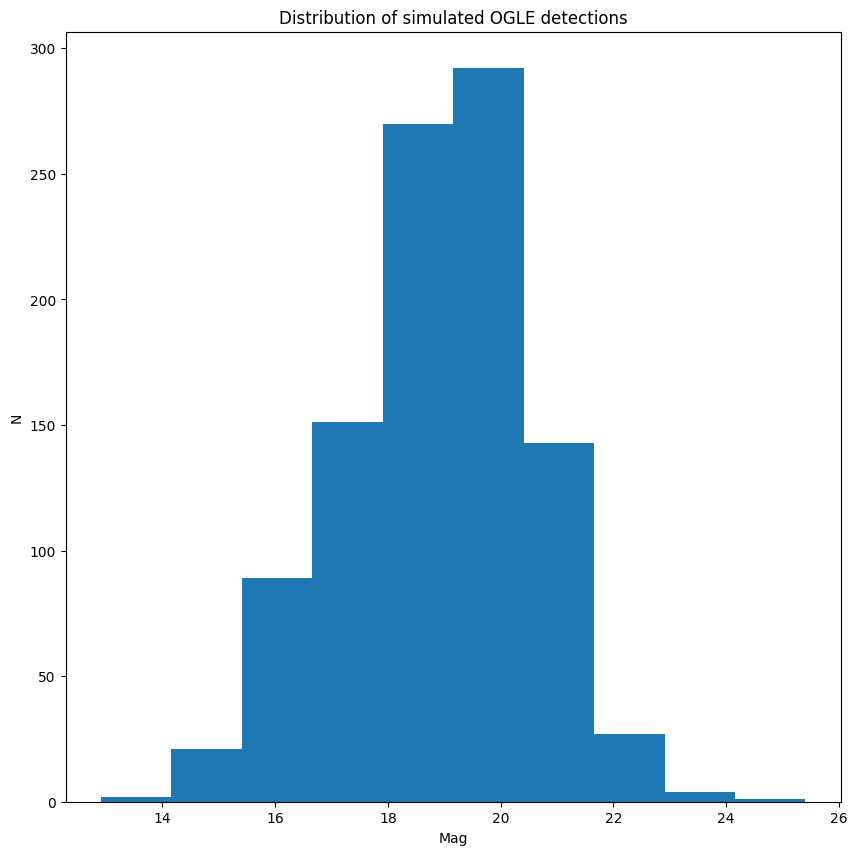

In [13]:
sim_event_mag = random.choices(mag_bins[0:-1], weights=mag_dist, k=n_samples)
fig = plt.figure(1,(10,10))
plt.hist(sim_event_mag)
plt.xlabel('Mag')
plt.ylabel('N')
plt.title('Distribution of simulated OGLE detections')

Blending
The density of stars in the Galactic Bulge is sufficiently high that we cannot assume that photometry for an event will not also include flux from neighboring stars within the PSF of both survey and follow-up telescopes. The OGLE catalog provides a sample of events where the blend ratio parameter f_bl = f_source / f_blend, and so equals 1.0 in cases with no blending.

Text(0.5, 1.0, 'Distribution of blend ratios=f_s/f_b of OGLE events')

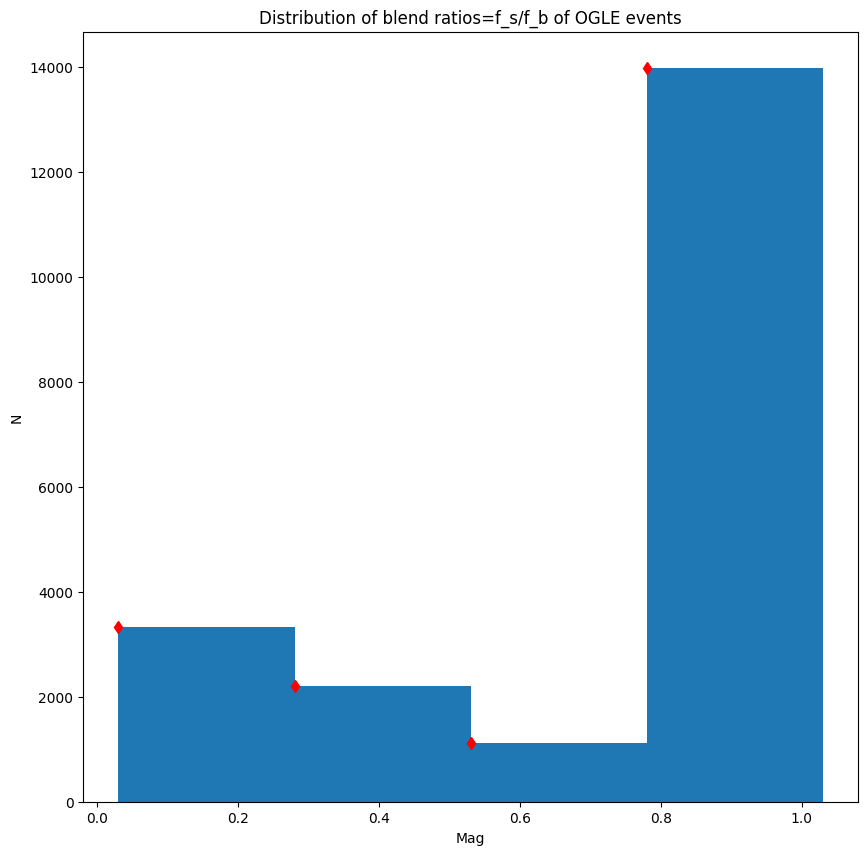

In [14]:
fbl_min = ogle_catalog['Blending'].min()
fbl_max = ogle_catalog['Blending'].max() + 0.25
(fbl_dist, fbl_bins) = np.histogram(ogle_catalog['Blending'], bins=np.arange(fbl_min, fbl_max, 0.25))

fig = plt.figure(1,(10,10))
plt.hist(ogle_catalog['Blending'], bins=fbl_bins)
plt.plot(fbl_bins[0:-1], fbl_dist, 'rd')
plt.xlabel('Mag')
plt.ylabel('N')
plt.title('Distribution of blend ratios=f_s/f_b of OGLE events')

Similarly, we use this to assign realistic blend ratios for the simulated events

Text(0.5, 1.0, 'Distribution of simulated OGLE blend radios')

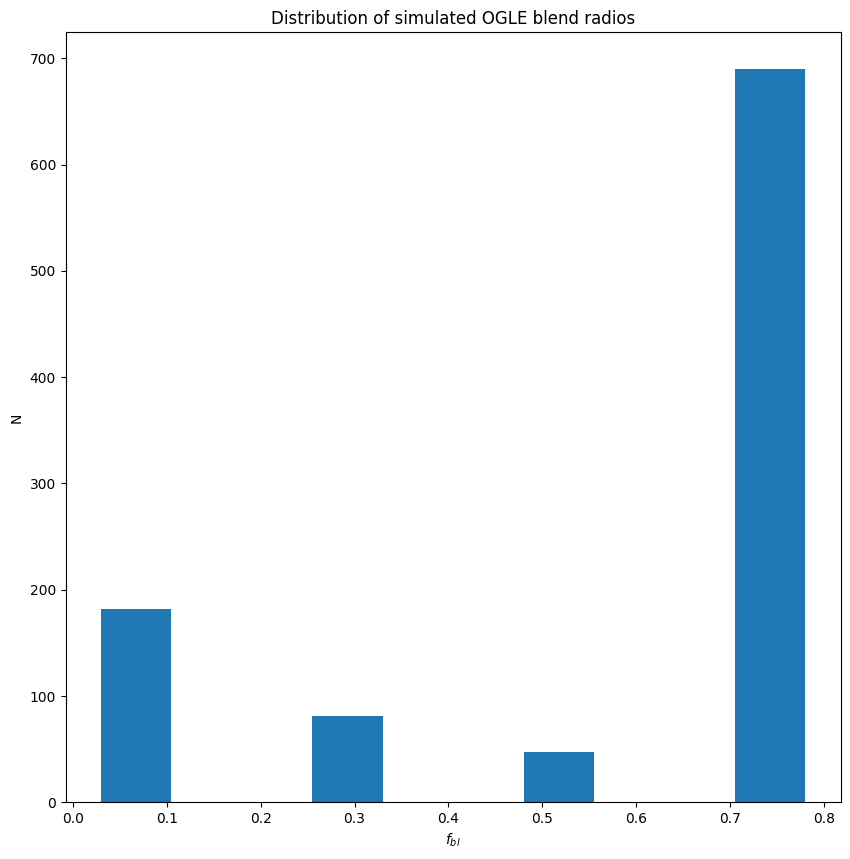

In [15]:
sim_event_fbl = random.choices(fbl_bins[0:-1], weights=fbl_dist, k=n_samples)
fig = plt.figure(1,(10,10))
plt.hist(sim_event_fbl)
plt.xlabel('$f_{bl}$')
plt.ylabel('N')
plt.title('Distribution of simulated OGLE blend radios')

## Bulge Event Lensing Parameters

Next, we simulate a realistic range of microlensing event parameters.  We generate a timestamps array first, as the simulated events are constrained to have t0 within the range of the Key Project:

In [16]:
# Time stamps are in Julian Date
start_date = 2460157.50000
end_date = 2461252.50000

In [17]:
def simulate_event_parameters(start_date, end_date, n_sample):
    """Based on code by Markus Hundertmark, adapted to simulate stellar and stellar remnant PSPL events
    within ranges likely to be detected by Gaia
    """
    event_parameters = []
    for i in range(0,n_sample, 1):
        t0 = np.random.uniform(start_date, end_date)
        u0 = np.random.normal(0.141993,0.312678)
        if u0>1:
            u0 = 1
        if  u0<-1:
            u0 = -1
        te = 10.**np.random.normal(1.455351,0.379810)
        rho = abs(np.random.normal(0.008303,0.013883))
        piEN = np.random.normal(0.164267,0.749409)
        piEE = np.random.normal(0.044996,0.259390)
        event_parameters.append([t0,u0,te,rho,piEN,piEE])
    event_parameters = np.array(event_parameters)
    
    return event_parameters

In [18]:
event_parameters = simulate_event_parameters(start_date, end_date, n_samples)
params_list = ['t0','u0','te','rho','piEN','piEE']

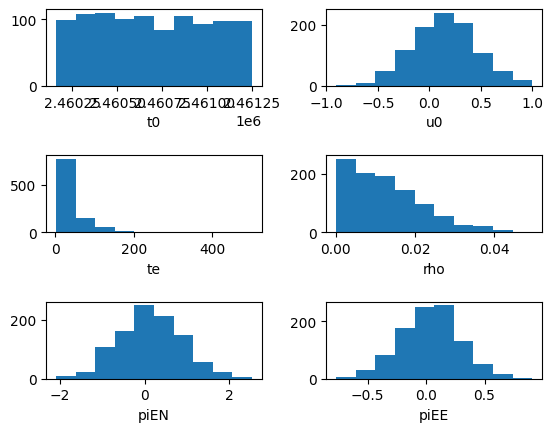

In [19]:
fig, axs = plt.subplots(3, 2)
plt.subplots_adjust(wspace=0.3,hspace=0.9)
idx = 0
for irow in range(0,3,1):
    for icol in range(0,2,1):
        axs[irow, icol].hist(event_parameters[:,idx])
        axs[irow, icol].set_xlabel(params_list[idx])
        idx += 1

Based on experience from previous year's of survey data, approximately 10% of events are binary lenses, which show anomalies, caustic crossings and other lightcurve features that need higher cadence observations in order to characterize them.

To simulate this, and estimate the total amount of time this would require, ideally we would simulate a set of binary events but modeling 100 such events would be extremely time consuming. Instead, we randomly nominate 10% of events in the table to be binaries, and use this flag to trigger more intensive observations over the event peak. This effectively simulates the real-world observations that would be made of a subtle (planetary-style) anomaly.

While binary stellar events often take longer (the gap between caustic entry and exit can be a few days), they do not need to be monitored as intensively the whole time. Instead, intensive observations would be required over the caustic crossings, returning to moderate cadence in the gap. The difference in the time requirements will be taken into account at a later stage.

In [20]:
binaries = np.random.random_integers(0, n_samples-1, int(0.1*n_samples))
binary_index = np.zeros(n_samples, dtype=int)
binary_index[binaries] = 1

For ease of handling, let's combine these data into a single events table

In [21]:
def roundID(num):
    num = str(num)
    while (len(num) < 5):
        num = '0'+num
    return num

sim_event_names = []
for x in range(1,len(sim_event_hp)+1,1):
    sim_event_names.append('BulgeSim'+roundID(x))

In [22]:
events_table = Table([
                        Column(name="EventID", data=sim_event_names, dtype='str'),
                        Column(name="HP", data=sim_event_hp, dtype='int'),
                        Column(name="location", data=sim_event_coords),
                        Column(name="baseline_mag", data=sim_event_mag, dtype='str'),
                        Column(name="blend_ratio", data=sim_event_fbl, dtype='str'),
                        Column(name="t0", data=event_parameters[:,0], dtype='float'),
                        Column(name="u0", data=event_parameters[:,1], dtype='float'),
                        Column(name="te", data=event_parameters[:,2], dtype='float'),
                        Column(name="rho", data=event_parameters[:,3], dtype='float'),
                        Column(name="piEN", data=event_parameters[:,4], dtype='float'),
                        Column(name="piEE", data=event_parameters[:,5], dtype='float'),
                        Column(name="nvisits", data=np.zeros(n_samples), dtype='float'),
                        Column(name="binary_lens", data=binary_index, dtype='int'),
                        ])
events_table

EventID,HP,location,baseline_mag,blend_ratio,t0,u0,te,rho,piEN,piEE,nvisits,binary_lens
str13,int64,object,str32,str32,float64,float64,float64,float64,float64,float64,float64,int64
BulgeSim00001,39232,"<SkyCoord (ICRS): (ra, dec) in deg\n (270., -36.42357222)>",17.908,0.78,2460347.999330287,-0.0743055496887047,16.687683037247062,0.019014411552932767,0.6830319668365106,0.24638403412486695,0.0,0
BulgeSim00002,37187,"<SkyCoord (ICRS): (ra, dec) in deg\n (274.21875, -30.69158611)>",17.408,0.03,2460936.6027459316,0.11208660045660437,24.460752225567628,0.0033516645160065915,0.87978568340328,-0.21122453709088443,0.0,0
BulgeSim00003,34116,"<SkyCoord (ICRS): (ra, dec) in deg\n (275.625, -22.66960833)>",19.908,0.03,2461045.7179500367,0.6554144194791974,17.11011731288815,0.011044623741104624,-0.718160507210416,0.04251528115068498,0.0,0
BulgeSim00004,37185,"<SkyCoord (ICRS): (ra, dec) in deg\n (271.40625, -30.69158611)>",19.658,0.78,2460445.4840198485,0.6014909192818554,10.126562342084585,0.0006753820152141888,-0.3732929762417842,-0.5256137160429447,0.0,0
BulgeSim00005,38211,"<SkyCoord (ICRS): (ra, dec) in deg\n (274.21875, -33.51005556)>",19.908,0.03,2461179.328539699,0.1653198287046789,90.64039359165093,0.0033464932014744125,1.572751504093082,-0.24887364498469047,0.0,0
BulgeSim00006,34365,"<SkyCoord (ICRS): (ra, dec) in deg\n (266.484375, -23.31795556)>",19.408,0.78,2460166.334229453,-0.23179543626623086,7.954485877308067,0.025362002588406832,-0.193891824049976,-0.033400719392682375,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
BulgeSim00994,38974,"<SkyCoord (ICRS): (ra, dec) in deg\n (267.890625, -35.68533333)>",20.408,0.78,2460549.2378032985,0.14894780379598554,54.6360485822346,0.003142614177516723,0.8436972116733792,0.009371806275856834,0.0,0
BulgeSim00995,33087,"<SkyCoord (ICRS): (ra, dec) in deg\n (268.59375, -20.10550833)>",19.908,0.03,2460482.924061135,0.6646540926377295,29.920714906198462,0.0008718562077679156,-0.26205880923764785,0.13978319769745157,0.0,0


## OGLE Event Lightcurve sampling

The OGLE survey team have indicated that they expect to adjust their survey strategy from 2023 onwards to survey the extended Bulge region with a cadence of 1-2 visits per field per night.  

OGLE Bulge survey operations typically run between Feb 1 to Oct 1 each year, following the Bulge annual visibility from their site in Chile.  MOA operate on a similar timescale from their site in New Zealand, and we assume a similar cadence from them for all events.  The expected survey cadence per event is therefore 2-4 visits per night, though in reality the number of visits per field is likely to drop towards the extreme ends of the season.  Our strategy would select only targets which are relatively poorly sampled by the surveys, so we assume 1-2 datapoints per survey per night. 

This is likely to produce a fairly consistent number of datapoints for all events.  

In [23]:
# Number of days in each month, and the expected number of visits per day for each month
seasons = {}

# 2023 - Key Project starts in 8/1/2023, so can observe only Aug, Sept
seasons[2023] = {'months': np.array([8, 9]),
                 'n_days_season': np.array([30, 30]), 
                 'nvisits_per_field': np.array([3, 2])}

# 2024 - will observe Feb - Sept inclusive
seasons[2024] = {'months': np.array([2, 3, 4, 5, 6, 7, 8, 9]),
                 'n_days_season': np.array([28, 31, 30, 31, 30, 31, 31, 30]), 
                 'nvisits_per_field': np.array([2, 2, 3, 3, 3, 3, 2, 2])}

# 2025 - will observe Feb - Sept inclusive
seasons[2025] = {'months': np.array([2, 3, 4, 5, 6, 7, 8, 9]),
                 'n_days_season': np.array([28, 31, 30, 31, 30, 31, 31, 30]), 
                 'nvisits_per_field': np.array([2, 2, 3, 3, 3, 3, 2, 2])}

# 2026 - will observe to end of Key Project period 7/31/2026
seasons[2026] = {'months': np.array([2, 3, 4, 5, 6, 7]),
                 'n_days_season': np.array([28, 31, 30, 31, 30, 31]), 
                 'nvisits_per_field': np.array([2, 2, 3, 3, 3, 3])}

nvisits = 0
for year in range(2023,2027,1):
    nv = (seasons[year]['n_days_season'] * seasons[year]['nvisits_per_field']).sum()
    nvisits += nv
print('Maximum number of survey visits = '+str(nvisits))

Maximum number of survey visits = 1846


Assign the numbers of visits to each simulated event, based on the HEALpixel where it was detected, and add this to the events_table.  

In [24]:
events_table['nvisits'] = [nvisits]*len(events_table)  # Off-by-one to match Python's number-from-zero
events_table

EventID,HP,location,baseline_mag,blend_ratio,t0,u0,te,rho,piEN,piEE,nvisits,binary_lens
str13,int64,object,str32,str32,float64,float64,float64,float64,float64,float64,int64,int64
BulgeSim00001,39232,"<SkyCoord (ICRS): (ra, dec) in deg\n (270., -36.42357222)>",17.908,0.78,2460347.999330287,-0.0743055496887047,16.687683037247062,0.019014411552932767,0.6830319668365106,0.24638403412486695,1846,0
BulgeSim00002,37187,"<SkyCoord (ICRS): (ra, dec) in deg\n (274.21875, -30.69158611)>",17.408,0.03,2460936.6027459316,0.11208660045660437,24.460752225567628,0.0033516645160065915,0.87978568340328,-0.21122453709088443,1846,0
BulgeSim00003,34116,"<SkyCoord (ICRS): (ra, dec) in deg\n (275.625, -22.66960833)>",19.908,0.03,2461045.7179500367,0.6554144194791974,17.11011731288815,0.011044623741104624,-0.718160507210416,0.04251528115068498,1846,0
BulgeSim00004,37185,"<SkyCoord (ICRS): (ra, dec) in deg\n (271.40625, -30.69158611)>",19.658,0.78,2460445.4840198485,0.6014909192818554,10.126562342084585,0.0006753820152141888,-0.3732929762417842,-0.5256137160429447,1846,0
BulgeSim00005,38211,"<SkyCoord (ICRS): (ra, dec) in deg\n (274.21875, -33.51005556)>",19.908,0.03,2461179.328539699,0.1653198287046789,90.64039359165093,0.0033464932014744125,1.572751504093082,-0.24887364498469047,1846,0
BulgeSim00006,34365,"<SkyCoord (ICRS): (ra, dec) in deg\n (266.484375, -23.31795556)>",19.408,0.78,2460166.334229453,-0.23179543626623086,7.954485877308067,0.025362002588406832,-0.193891824049976,-0.033400719392682375,1846,0
...,...,...,...,...,...,...,...,...,...,...,...,...
BulgeSim00994,38974,"<SkyCoord (ICRS): (ra, dec) in deg\n (267.890625, -35.68533333)>",20.408,0.78,2460549.2378032985,0.14894780379598554,54.6360485822346,0.003142614177516723,0.8436972116733792,0.009371806275856834,1846,0
BulgeSim00995,33087,"<SkyCoord (ICRS): (ra, dec) in deg\n (268.59375, -20.10550833)>",19.908,0.03,2460482.924061135,0.6646540926377295,29.920714906198462,0.0008718562077679156,-0.26205880923764785,0.13978319769745157,1846,0


Store the table of simulated event parameters

In [25]:
hdr = fits.Header()
hdr['NEVENTS'] = len(events_table)
phdu = fits.PrimaryHDU(header=hdr)

ra = np.array([x.ra.deg for x in events_table['location']])
dec = np.array([x.dec.deg for x in events_table['location']])

column_list = []
column_list.append(fits.Column(name='EventID', array=events_table['EventID'], format='A14'))
column_list.append(fits.Column(name='HEALpixel', array=events_table['HP'], format='I8'))
column_list.append(fits.Column(name='RA_deg', array=ra, format='E'))
column_list.append(fits.Column(name='Dec_deg', array=dec, format='E'))
column_list.append(fits.Column(name='baseline_mag', array=events_table['baseline_mag'], format='E'))
column_list.append(fits.Column(name='blend_ratio', array=events_table['blend_ratio'], format='E'))
column_list.append(fits.Column(name='t0', array=events_table['t0'], format='E'))
column_list.append(fits.Column(name='u0', array=events_table['u0'], format='E'))
column_list.append(fits.Column(name='tE', array=events_table['te'], format='E'))
column_list.append(fits.Column(name='rho', array=events_table['rho'], format='E'))
column_list.append(fits.Column(name='piEN', array=events_table['piEN'], format='E'))
column_list.append(fits.Column(name='piEE', array=events_table['piEE'], format='E'))
column_list.append(fits.Column(name='nvisits', array=events_table['nvisits'], format='I5'))
column_list.append(fits.Column(name='binary_lens', array=events_table['binary_lens'], format='I1'))
hdu = fits.BinTableHDU.from_columns(column_list)

hdul = fits.HDUList([phdu,hdu])
hdul.writeto('./sim_bulge_events_table.fits', overwrite=True)


## Bulge Event Lightcurves

Now we can simulate the lightcurves that OGLE+MOA would produce for these simulated events, assuming the strategy described above for single-filter lightcurves (combined into the same survey lightcurve array, for convenience), since the majority of the constraint on the lightcurve parameters comes from data taken in I band.  

Firstly though, we need to establish a photometric noise function for the magnitude uncertainties in the lightcurve. We do this using data for an example event OGLE-2019-BLG-0461, downloaded from the OGLE EWS system, and fit a simple function to represent the photometric noise model.

In [26]:
def straight_line(x, a, b):
    return a + b*x

Text(0.5, 1.0, 'Photometry for example Bulge event OGLE-2019-BLG-0461')

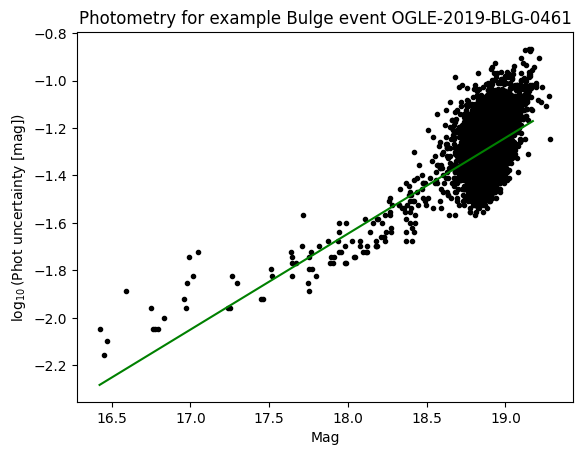

In [27]:
file_path = './ogle/blg-0461/phot.dat'
data = np.loadtxt(file_path)
mag = data[:,1]
mag_err = data[:,2]
log_mag_err = np.log10(mag_err)

(noise_model, fcov) = optimize.curve_fit(straight_line, mag, log_mag_err)
xdata = np.arange(mag.min(), mag.max(), 0.25)
ydata = straight_line(xdata, noise_model[0], noise_model[1])

plt.plot(mag, log_mag_err, 'k.')
plt.plot(xdata, ydata, 'g-')
plt.xlabel('Mag')
plt.ylabel('$\log_{10}$(Phot uncertainty [mag])')
plt.title('Photometry for example Bulge event OGLE-2019-BLG-0461')

In [28]:
def convert_flux_to_mag(flux, flux_err):
    """Function to convert the flux of a star from its fitted PSF model
    and its uncertainty onto the magnitude scale.

    :param float flux: Total star flux
    :param float flux_err: Uncertainty in star flux
run
    Returns:

    :param float mag: Measured star magnitude
    :param float flux_mag: Uncertainty in measured magnitude
    """

    def flux2mag(ZP, flux):
        return ZP - 2.5 * np.log10(flux)

    # Weed out any negative fluxes
    idx = np.where(flux < 0.0)
    flux[idx] = 0.0
    flux_err[idx] = 0.0
    
    ZP = 27.4 # As used by PyLIMA

    mag = flux2mag(ZP, flux)
    mag_err = (2.5 / np.log(10.0)) * flux_err / flux

    return mag, mag_err

def convert_mag_to_flux(mag, mag_err):
    """Function to convert the flux of a star from its fitted PSF model
    and its uncertainty onto the magnitude scale.

    :param float flux: Total star flux
    :param float flux_err: Uncertainty in star flux

    Returns:

    :param float mag: Measured star magnitude
    :param float flux_mag: Uncertainty in measured magnitude
    :param float flux: Total flux, scaled by the exposure time if given
    :param float flux_err: Uncertainty on total flux, scaled by the exposure
                            time, if given
    """

    ZP = 27.4 # As used by PyLIMA

    flux = 10**( (mag - ZP) / -2.5 )

    ferr = mag_err/(2.5*np.log10(np.e)) * flux

    return flux, ferr


In [29]:
def simulate_event_bulge(event_params, noise_model, start_date, end_date, 
                         seasons, parallax=True):
    """Expects parameters from an entry in the events_table above.
    """
    
    # Simulate timestamps of observations
    timestamps = np.array([])
    for year, config in seasons.items():
        for imonth,month in enumerate(config['months']):
            t1 = Time(str(year)+'-0'+str(month)+'-01 00:00:00', format='iso', scale='utc')
            t2 = Time(str(year)+'-0'+str(month)+'-'+str(config['n_days_season'][imonth])+' 00:00:00', format='iso', scale='utc')
            start = t1.jd
            end = t2.jd
            cadence = 1.0/config['nvisits_per_field'][imonth]
            ts = np.arange(start, end, cadence)
            #print(str(year)+'-'+str(month)+' '+str(start)+' to '+str(end)+': '+str(ts.min())+' to '+str(ts.max()))
            timestamps = np.concatenate((timestamps, ts))
    
   
    # Create a PyLIMA event object
    sim_event = event.Event()
    sim_event.name = event_params['EventID']
    sim_event.ra = float(event_params['location'].ra.deg)
    sim_event.dec = float(event_params['location'].dec.deg)

    # Generate a constant lightcurve at the event's baseline magnitude (neglecting differences due to color), 
    # with fixed photometric uncertainties, since these will be replaced later
    lc = np.zeros((len(timestamps),3))
    lc[:,0] = timestamps
    lc[:,1] = [float(event_params['baseline_mag'])] * len(timestamps)
    lc[:,2] = [0.01] * len(timestamps)
    print(float(event_params['baseline_mag']), np.median(lc[:,1]))

    # Add a PyLIMA telescope object to the event with this lightcurve, and add it to the event
    tel = telescopes.Telescope(name='OGLEMOA', camera_filter='I',
                                    light_curve_magnitude=lc,
                                    location='Earth',
                                    light_curve_magnitude_dictionnary={'time': 0, 'mag': 1, 'err_mag': 2},
                                    clean_the_lightcurve=False)

    sim_event.telescopes.append(tel)
    sim_event.find_survey('OGLEMOA')

    # Add a PyLIMA model to the event, using the simulated parameters
    if parallax:
        sim_model = microlmodels.create_model('FSPL', sim_event,
                                          parallax=['Full',float(event_params['t0'])])
        lensing_parameters = [float(event_params['t0']), float(event_params['u0']), float(event_params['te']), 
                              float(event_params['rho']), float(event_params['piEN']), float(event_params['piEE'])]

    else:
        sim_model = microlmodels.create_model('FSPL', sim_event)
        lensing_parameters = [float(event_params['t0']), float(event_params['u0']), float(event_params['te']), 
                              float(event_params['rho'])]

    sim_model.define_model_parameters()

    if parallax:
        sim_model.event.compute_parallax_all_telescopes(sim_model.parallax_model)

    tel = sim_model.event.telescopes[0]

    pylima_parameters = sim_model.compute_pyLIMA_parameters(lensing_parameters)
    
    # Add simulated blending to the parameter set, bearing in mind that OGLE's definition is the inverse of PyLIMA's
    pylima_parameters.g_OGLEMOA = float(event_params['blend_ratio']) 
    
    # Use the blend ratio to create both source and blend unlensed lightcurves
    # f(t) = A(t)*f_s(t) + f_b 
    lightcurve = sim_event.telescopes[0].lightcurve_magnitude
    (unlensed_lc, flux_err) = convert_mag_to_flux(lightcurve[:,1], lightcurve[:,2]) # Unlensed source lightcurve
    source_flux = unlensed_lc * float(event_params['blend_ratio'])
    blend_flux = unlensed_lc * (1.0 -float(event_params['blend_ratio']))      # Blend lightcurve (inc sim noise)
    
    # Use the PyLIMA model to add a lensing event into the source lightcurve
    magnification = sim_model.model_magnification(tel, pylima_parameters)
    A = sim_model.model_magnification(tel,pylima_parameters)
    source_flux *= A
    
    # Observed lightcurve is the combination of both lensed source and blend
    flux = source_flux + blend_flux
    
    # Convert back to magnitudes and use the noise model to calculate the photometric uncertainties
    (lightcurve[:,1], mag_err) = convert_flux_to_mag(flux, flux_err)
    log_errors = straight_line(lightcurve[:,1], noise_model[0], noise_model[1])
    lightcurve[:,2] = 10**(log_errors)
    
    sim_event.telescopes[0].lightcurve_magnitude = lightcurve
    print(float(event_params['baseline_mag']), np.median(lightcurve[:,1]))

    return sim_event, sim_model, lensing_parameters

Parallax for Bulge events is predominately the annual parallax signature caused by the motion of the Earth during an event, which PyLIMA can calculate internally.  

In [30]:
# Pick a bright event as a test case:
event_number = 0
while (float(events_table[event_number]['baseline_mag']) > 18.0):
    event_number += 1
print('Picked bright event: ',event_number,' baseline_mag=',events_table[event_number]['baseline_mag'],'mag')

(sim_event, sim_model, lensing_parameters) = simulate_event_bulge(events_table[event_number], noise_model, start_date, end_date, seasons, parallax=True)



Picked bright event:  0  baseline_mag= 17.908 mag
17.908 17.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
17.908 17.907996168641716


   EventID      HP                             location                           baseline_mag blend_ratio         t0                 u0                 te                 rho                 piEN                piEE        nvisits binary_lens
------------- ----- ------------------------------------------------------------- ------------ ----------- ----------------- ------------------- ------------------ -------------------- ------------------ ------------------- ------- -----------
BulgeSim00001 39232 <SkyCoord (ICRS): (ra, dec) in deg\n    (270., -36.42357222)>       17.908        0.78 2460347.999330287 -0.0743055496887047 16.687683037247062 0.019014411552932767 0.6830319668365106 0.24638403412486695    1846           0
[[2.46015750e+06 1.79079156e+01 2.07573850e-02]
 [2.46015783e+06 1.79079151e+01 2.07573744e-02]
 [2.46015817e+06 1.79079145e+01 2.07573637e-02]
 ...
 [2.46125150e+06 1.79079998e+01 2.07590125e-02]
 [2.46125183e+06 1.79079998e+01 2.07590125e-02]
 [2.46125217e+06 1.7907

Text(0.5, 1.0, 'Simulated event BulgeSim00001')

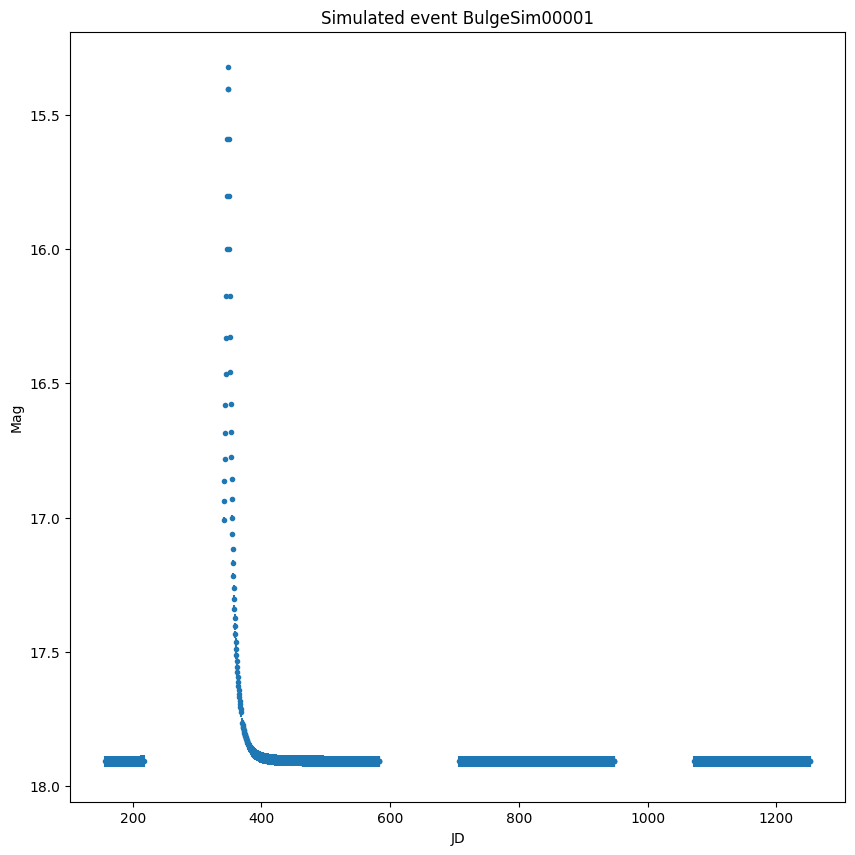

In [31]:
print(events_table[event_number])
fig = plt.figure(1,(10,10))
lc = sim_event.telescopes[0].lightcurve_magnitude
print(lc)
plt.errorbar(lc[:,0]-2460000.0, lc[:,1], yerr=lc[:,2], fmt='.')
[xmin, xmax, ymin, ymax] = plt.axis()
plt.axis([xmin, xmax, ymax, ymin])
plt.xlabel('JD')
plt.ylabel('Mag')
plt.title('Simulated event '+events_table[event_number]['EventID'])

Simulate all events

In [32]:
sim_bulge_lenses = []
sim_bulge_lens_models = []
sim_model_params = []

for ievent in range(0,len(events_table),1):
    (bulge_lens, bulge_lens_model, lens_model_pars) = simulate_event_bulge(events_table[ievent], noise_model, start_date, end_date, seasons, parallax=True)
    sim_bulge_lenses.append(bulge_lens)
    sim_bulge_lens_models.append(bulge_lens_model)
    sim_model_params.append(lens_model_pars)
    print(ievent, sim_model_params[-1])

17.908 17.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
17.908 17.907996168641716
0 [2460347.999330287, -0.0743055496887047, 16.687683037247062, 0.019014411552932767, 0.6830319668365106, 0.24638403412486695]
17.408 17.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
17.408 17.407993396636165
1 [2460936.6027459316, 0.11208660045660437, 24.460752225567628, 0.0033516645160065915, 0.87978568340328, -0.21122453709088443]
19.908 19.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.908 19.9079989363979
2 [2461045.7179500367, 0.6554144194791974, 17.11011731288815, 0.011044623741104624, -0.718160507210416, 0.04251528115068498]
19.658 19.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.658 19.657998056255153
3 [2460445.4840198485, 0.6014909192818554, 10.126562342084585, 0.0006753820152141888, -0.3732929762417842, -0.5256137160429447]
19.908 19.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.908 19.907990966059

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
20.158 20.15789957134261
37 [2460908.852142883, -0.3071059105740255, 27.14271158027572, 0.008132026001101673, -0.055327410659620574, 0.16634817649670772]
19.658 19.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.658 19.657981628859424
38 [2460360.276833723, -0.6588863765635947, 23.989741186310397, 0.02544275788249805, -1.0531282303315141, -0.25645399265950936]
18.408 18.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.408 18.407994427039146
39 [2461209.475148785, 0.3532625279064731, 67.21342752982123, 8.082376554323888e-05, 1.4786746565518005, -0.3091953949041029]
18.908 18.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.908 18.90799084672581
40 [2460517.7032122235, 0.246359349756819, 15.991556587094546, 0.022493115877522604, 0.6184091525242652, 0.2273533401489653]
19.908 19.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.908 19.907995786101278
41 [2460

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.658 18.65751391325621
75 [2460946.7052113577, 0.17817816203371106, 27.85434421547115, 0.00460673410641858, 1.660969240075407, -0.040097143432714956]
20.658 20.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
20.658 20.657951659585358
76 [2460622.1829938903, -0.02074198423231488, 19.59756493170088, 0.011238485172223665, 0.11464443803061147, -0.4028324594783615]
19.408 19.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.408 19.407648460333746
77 [2460717.00887662, 0.13376924993146735, 33.92426334674098, 0.035790103047513684, 1.0304753728158271, 0.3903952734604527]
17.908 17.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
17.908 17.907996281517704
78 [2461078.72285875, -0.14342585951253675, 12.31126913144924, 0.01170462165247943, 1.7101190595500892, 0.02992110138042236]
17.658 17.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
17.658 17.657995372192175
79 [246038

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
21.908 21.90795378303365
111 [2460697.1185305794, 0.43451807955538635, 42.55332668521785, 0.019082106579456005, 0.39562772030285315, 0.00754126012684099]
18.408 18.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.408 18.386907570591063
112 [2461095.54275802, 0.6377790391093215, 175.09648509595277, 0.018836384561136205, -0.2853409037666116, -0.5319151314126971]
17.158 17.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
17.158 17.157956459917862
113 [2460186.389631328, 0.204717576238954, 47.13575904886214, 0.018578031113395337, -0.12544264079594775, 0.26285165152165374]
15.658 15.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
15.658 15.657993222269932
114 [2461174.130192069, -0.28087138903438136, 19.626705902340237, 0.002983535864417781, 1.372059518695039, 0.1260034482970708]
15.908 15.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
15.908 15.907999867053691
115 [

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.408 19.407962262847338
147 [2460487.365693204, 0.13559272090425742, 37.32771940440352, 0.011508948345978248, 2.0300968456900095, -0.018489935645198012]
18.658 18.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.658 18.65780754191234
148 [2460282.9179914156, 0.5496534517225394, 134.49243021887358, 0.015343491519715213, -1.028117629957963, -0.11356596631985613]
20.408 20.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
20.408 20.40798997873798
149 [2460825.597057669, 0.5618023399006228, 15.308524763763499, 0.009352475139803038, -0.8684096103038774, -0.13545753089333845]
20.908 20.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
20.908 20.90798001076785
150 [2461058.0455193464, 0.10639488019713662, 15.22390692328413, 0.025184667830504742, 0.87329751062918, 0.3828384856777116]
19.658 19.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.658 19.65799918168978
151 [2

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.908 18.9079997138286
183 [2460335.4856395507, -0.5400725026269507, 23.880735796342396, 0.0025590682033791506, -1.0515245979409351, -0.4761987119683125]
18.908 18.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.908 18.907957194093434
184 [2460306.2216044976, -0.07758240599004859, 62.037880905774905, 0.011004839662205506, -1.28864049624829, -0.32068195121012827]
19.908 19.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.908 19.907991842359927
185 [2460190.8434057217, -0.24026982289601997, 29.361533291244953, 0.011841913105710634, -0.4380930350921208, 0.20930278449348533]
20.658 20.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
20.658 20.657991761294703
186 [2460809.235426772, 0.7076444429931593, 13.98594785724799, 0.004243868154143266, -0.33702406253357425, -0.23495034910448107]
18.908 18.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.908 18.90733597418

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
17.658 17.65794262789679
219 [2460691.7951929327, 0.3877510112257002, 22.283553965827583, 0.025998415932541215, 0.4307536873965032, -0.4156715256845191]
17.658 17.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
17.658 17.657888780688673
220 [2460918.28579153, 0.8326911149608571, 28.635120687366715, 0.01702373580995073, -0.6679452595439193, 0.18849114839855652]
17.158 17.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
17.158 17.157967585781805
221 [2461059.6936042444, -0.4957727805291118, 29.274998422950155, 0.014546909305777884, 0.569157953045959, -0.3638577417211841]
18.658 18.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.658 18.657989387480466
222 [2461229.2663727663, 0.1703836749903989, 20.276422058340874, 0.001802137965417597, 0.4761933787020795, -0.32876017147202274]
16.158 16.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
16.158 16.155257256561267
223 

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.158 19.144059220116958
255 [2460450.8501519607, 0.23620187554298444, 86.98570385104864, 0.004476280128204538, 0.525214130166715, -0.5643422915843653]
17.908 17.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
17.908 17.907991981464264
256 [2460811.581932915, 0.40871339668681805, 14.346729752582455, 0.008148458766766708, -0.5102032365363545, -0.14627994053195206]
21.158 21.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
21.158 21.157999992506614
257 [2460325.1447602306, -0.1444846188354795, 8.388606911254849, 0.003640732667094323, -0.2996866120598475, 0.028069919913423155]
18.408 18.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.408 18.40692819255326
258 [2460700.221774518, 0.07807687997375101, 43.572692281174085, 0.021988994472569787, 0.6035056227041912, 0.029828568957415688]
19.908 19.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.908 19.90786498562106


Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
17.658 17.6579862678277
291 [2461068.318045745, 0.6755270707194808, 15.259378148712575, 0.002978829840956548, 0.17153879337479772, 0.03741759489588046]
16.908 16.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
16.908 16.90798809101357
292 [2461228.9790505413, 0.11065054133882891, 23.5041308888689, 0.020683958171534567, 0.40048510770587026, 0.09265177613270409]
19.408 19.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.408 19.407547225894334
293 [2460910.2678206717, 0.2222305702379388, 40.90909045164097, 0.030191946417160054, 0.5614566930027576, 0.2260196472489859]
17.908 17.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
17.908 17.90799985104414
294 [2460748.633821224, 0.5709877283228083, 11.281766642498102, 0.009778678927635573, -0.20426247447491275, 0.1992802229677675]
19.658 19.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.658 19.657999667975425
295 [246

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
16.408 16.407949679610248
327 [2460204.2291090963, 0.28414262828840603, 51.53177334744356, 0.0023316005214065755, -0.3835168063188726, 0.4999185320271837]
18.408 18.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.408 18.407995432381476
328 [2460700.3304995624, -0.7467386294166256, 10.382545518085296, 0.001098768844788032, -0.45477001238376064, -0.2702294741143896]
19.158 19.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.158 19.157423209574237
329 [2460616.277918773, -0.16568867595586398, 46.172656857950194, 0.026373870917920497, 0.02974002298273759, -0.6605961122532625]
16.908 16.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
16.908 16.907999892291116
330 [2460940.699223174, 0.09980977511761603, 9.389936228888805, 0.018579025100963924, 0.1363168086059253, 0.3472039154392381]
19.658 19.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.658 19.65799590857907

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
20.908 20.907999961011424
363 [2460257.183838277, 0.3503148798517363, 6.18512054188938, 0.021397400596929038, -0.5100517262008302, 0.6336374552237948]
18.408 18.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.408 18.407849247667492
364 [2460952.0699013, 0.3927144768699127, 25.31989322931861, 0.011932543372197667, 1.4086006538743305, -0.24031189977365694]
19.908 19.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.908 19.90799054903795
365 [2460326.944386161, 0.7699898228512573, 22.506156856724342, 0.007739611821353546, -0.1554094537036682, -0.03458044641784327]
15.408 15.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
15.408 15.407999560887426
366 [2461236.0019741016, -0.24987735332654817, 10.40562423388504, 0.0303951051825644, 0.17906840551113432, 0.12477613563337608]
18.158 18.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.158 18.15799999774722
367 [2460

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
20.908 20.857531056640838
399 [2460816.9959970945, 0.3084697194006191, 135.03930112972878, 0.03371068899233414, -0.07096548182842427, -0.0711525567877837]
19.408 19.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.408 19.407992005806282
400 [2460435.1872470933, 0.6092243260224658, 18.83055654284499, 0.007096803597034981, 1.166302110521373, 0.3107125328453079]
19.158 19.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.158 19.15780419537071
401 [2460423.2419927595, -0.00423899955344309, 38.10038004966787, 0.006872789215146898, 0.4173934241250244, -0.12126151260222767]
20.908 20.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
20.908 20.907999029282156
402 [2460907.9449750427, -0.22124481379669483, 8.035099161439451, 0.003860048801907728, 1.0641943091611954, -0.0026651031846963782]
16.658 16.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
16.658 16.657783150546166

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
16.908 16.907915674186093
435 [2460428.817168506, 0.46380867825190275, 33.00106361736429, 0.0025264153498419754, 0.7175108006006641, 0.115182203790407]
20.408 20.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
20.408 20.407999077941213
436 [2460339.7677695495, 0.6780054673235559, 11.58688227341872, 0.007336995339426612, -0.15406468902529002, 0.24988897842898458]
14.908 14.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
14.908 14.907999962934555
437 [2460730.5840251087, 0.2739354183088072, 3.334023875579156, 0.008894219096919237, 0.26602273823177736, -0.19034390157764172]
16.908 16.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
16.908 16.901627704476883
438 [2460502.5569879836, 0.3377392357431175, 184.74238647730482, 0.013100247605678126, 0.2673734471060614, 0.3094260779894982]
19.158 19.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.158 19.15799914312869
439 

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.408 19.407987751656897
471 [2460955.7736517517, 0.21456235620400838, 12.91369075447329, 0.005148849099858235, 0.303255931401061, -0.17061352476680033]
19.908 19.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.908 19.90799691152838
472 [2460180.807596529, 0.8157673603414697, 27.842684756958562, 0.009541781883929987, 0.42352226029941753, -0.053956504095711615]
15.408 15.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
15.408 15.406898461476956
473 [2460660.668568103, 0.22627223028071175, 33.14927352435123, 0.018849068515585814, 0.24089228713029984, 0.24180198345242465]
17.408 17.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
17.408 17.407973592524975
474 [2461190.3338216958, 0.3693551680726833, 58.20119393744463, 0.00811841790758802, 0.3289846589667925, -0.06430193197036563]
18.658 18.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.658 18.657999972366877
47

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
20.158 20.1563817338056
507 [2460593.171137324, 0.31714388111874803, 127.87369152591654, 0.02883014999148402, 0.6264291161377643, 0.0428292120970908]
19.908 19.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.908 19.90447450886777
508 [2460764.252491244, 0.16403340726619237, 69.6327383702265, 0.0024592559497023693, -0.2487597694077796, 0.290493523112443]
15.408 15.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
15.408 15.40692940060621
509 [2460856.966781761, 0.1991913822182936, 40.983242769320306, 0.0005271314557574926, 0.23808869540811914, -0.2776882858606694]
17.408 17.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
17.408 17.407997490442014
510 [2461098.9393410203, -0.11683100934124732, 10.983894828029824, 0.017393892387422703, -0.03918238759134737, 0.17086827356011045]
18.408 18.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.408 18.407999999281458
511 [

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
20.158 20.15767010990184
543 [2460308.684997105, 0.6816229476786672, 57.49584174777987, 0.0008370482657508675, 0.10692942233808483, -0.016416734279775587]
20.158 20.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
20.158 20.157976945639188
544 [2460519.203136379, -0.06310464747903435, 20.520733254685293, 0.010458457409320145, -0.9638426124963393, 0.1054084620556884]
19.158 19.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.158 19.157984606055066
545 [2460258.010277235, -0.24791177888058005, 31.78271200883212, 0.012442499448828689, 1.8964467825800786, 0.46272215799729643]
18.658 18.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.658 18.65799459429197
546 [2460275.363889499, 0.2003229320023026, 26.296081262431766, 0.001896175546093802, -1.059645656918129, -0.4078081258386141]
17.158 17.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
17.158 17.157996946794665
54

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
20.908 20.90799826228869
579 [2460235.1373527227, 0.23330429635229122, 17.1785912598634, 0.007554347830836574, 0.17643705005925514, 0.21229608858172413]
19.158 19.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.158 19.15799997908894
580 [2460213.526449796, -0.34714618020044574, 5.994002215589582, 0.005020684720892735, 0.4643004554141785, 0.0451045636439462]
17.658 17.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
17.658 17.657860538447274
581 [2460665.557170059, 0.20023344935491913, 30.648720908042108, 0.019783948848774446, 0.5276207505051972, -0.44246754592708903]
19.658 19.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.658 19.657997205259214
582 [2460865.480306373, 0.07272815067829876, 11.481294403045068, 0.013818610928365652, -0.936589686261434, 0.04050313556545211]
19.158 19.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.158 19.157959065110852
583 

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
17.408 17.407999998741168
615 [2460341.43645319, 0.24648579455133462, 5.219206446798162, 0.018153452070178606, -1.6237218782210694, -0.309674797378008]
19.908 19.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.908 19.907978996544013
616 [2460710.5593659407, -0.18005387987079144, 15.621079623534202, 0.0157585380895451, -0.3006895855246998, -0.3305847507041631]
20.908 20.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
20.908 20.907999450314186
617 [2460433.9407161656, -0.07422621086310244, 17.928237140404736, 0.027114845646075046, -0.09359288643801916, -0.20689322458467566]
14.408 14.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
14.408 14.40602640693324
618 [2460713.029201464, 0.7869375025895422, 64.97979968531018, 0.003730457817776832, 1.2325736658655715, 0.5492093007439739]
15.908 15.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
15.908 15.905376116337862
61

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.158 19.157974776607553
651 [2460508.7792670564, 0.4778787954562903, 26.64899016122303, 0.022478303683004665, 1.4549073083622304, 0.4468180301658306]
18.658 18.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.658 18.657999598407955
652 [2460361.1574640316, 0.17212325905380343, 22.212667243023144, 0.003951503950669391, 0.033999742747089695, -0.3114819147437035]
18.908 18.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.908 18.90799686901442
653 [2460650.429605577, -0.17940995020078196, 8.915679505476199, 0.004743583251678778, 0.02530767360524519, -0.15158003266589606]
18.908 18.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.908 18.90799756340111
654 [2460234.6126334597, -0.10276294823078194, 41.350735146793554, 0.0003721479809657372, 2.325358858471746, 0.5495903716277853]
20.158 20.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
20.158 20.157999991185548


Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
15.658 15.65747834514817
687 [2461235.341085962, -0.14475346975032335, 48.54371633945351, 0.006951098223973997, -0.44855671567027106, -0.4217364528501592]
16.658 16.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
16.658 16.64742532500288
688 [2460914.8809201843, 0.2660314245523373, 94.10595913431145, 0.02304332875256106, -0.1567570817458237, 0.07935704963444275]
16.658 16.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
16.658 16.656137949716225
689 [2460190.159501302, 0.5206516577570565, 218.6890855622861, 0.03229282359716791, -0.25644920538276195, -0.20329969948940924]
19.408 19.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.408 19.407999016644634
690 [2460238.878409371, 0.08454584196101976, 15.317347216240387, 0.013596439849108055, 1.7839493531570294, 0.08987943501681417]
20.158 20.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
20.158 20.157998895599874
691

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
16.408 16.368412649038383
723 [2460786.915959459, 0.41403605882068784, 102.84249425350451, 0.005896928592277273, -0.10378032945781845, -0.3540518676318624]
18.908 18.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.908 18.907816620481867
724 [2460692.6202435712, 0.6164370972822945, 25.340320587835148, 0.00020077582052643872, 0.05801530156149588, -0.010329673981612927]
21.158 21.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
21.158 21.157998891076836
725 [2460452.4665551307, -0.23295907410900704, 21.692224761667664, 0.020120300513388464, 0.058494656375356016, 0.05425266842592353]
17.158 17.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
17.158 17.157999849127222
726 [2460877.4065296287, -0.131937558919181, 12.87943585076934, 0.023096321619958872, -0.9173654404181935, 0.07020037867722424]
14.158 14.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
14.158 14.1574460

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
20.908 20.907986191800255
759 [2460336.4277461804, -0.2523669243370362, 24.5282352665712, 0.002832143130252612, 0.5352198537114464, -0.03594996386331573]
19.908 19.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.908 19.907992534359334
760 [2460263.580727181, 0.24750182470112364, 41.93979399481003, 0.010002533303913446, -0.2592821470633923, 0.57731069873112]
18.658 18.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.658 18.65799998796828
761 [2460556.9917656495, 0.13929074989919893, 2.541290471004598, 0.020278749066488314, -0.7397665649352636, 0.020006131771312437]
17.658 17.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
17.658 17.65799790320771
762 [2460463.763693514, 0.015566000690593912, 22.55136308879314, 0.009293901679177418, -0.579930233695942, -0.21844583087832067]
16.158 16.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
16.158 16.157998494518267
763 

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.158 19.157999642033566
795 [2460671.3509367793, 0.01893467582698656, 5.150032581242153, 0.00907598406080042, -0.33823220170247287, -0.06777568002955545]
15.658 15.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
15.658 15.657993133671587
796 [2460537.9598528785, 0.5109417919586392, 84.05532955844946, 0.007252949351330428, -2.074377217436825, 0.05335731280301033]
16.158 16.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
16.158 16.156669349427954
797 [2460841.0470717507, -0.12309727573816712, 48.39373278855781, 0.006632599789651478, 0.33851132001094203, -0.16266980368618025]
19.408 19.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.408 19.407514174085847
798 [2461223.5214202297, 0.10476854745071867, 71.5007107223284, 0.001173048927030228, 0.5602224262183075, 0.07942004948367165]
18.908 18.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.908 18.907703557067457

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
20.158 20.157981857193658
832 [2460584.5973390774, 0.8666832359778199, 14.081267145807256, 0.004390472715308953, 0.5095453732942494, 0.07427009660857439]
18.908 18.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.908 18.907997553295473
833 [2460844.0429189224, -0.14303837098382863, 11.497363737560248, 0.012040694121926316, -1.3556233765936208, 0.058918281330566535]
15.658 15.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
15.658 15.657981496195431
834 [2460834.3021642254, 0.010998205345160578, 40.006731148747846, 0.015573544620282091, 0.13183030828242642, -0.06116019383259081]
16.408 16.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
16.408 16.40799969992231
835 [2460865.201584928, 0.4970524523230875, 6.841810628120181, 0.020360234851998272, -0.2676636143206845, 0.5394063507472138]
17.658 17.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
17.658 17.6560481677804

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.408 19.40799733362821
868 [2460325.141106641, 0.1706660078452228, 17.24711643169889, 0.002617297834126297, 1.8826936386460873, 0.30453399726319563]
18.658 18.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.658 18.657992704645437
869 [2460320.881478152, -0.09285936895320701, 23.07926197799503, 0.011405351209084874, 0.582562221543839, -0.21378090436554778]
16.908 16.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
16.908 16.90795905695937
870 [2460865.1056581982, 0.7996021224210019, 21.36975224863714, 0.007167728322481095, -0.5421428617503774, -0.12928094003146323]
18.408 18.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.408 18.407988914644697
871 [2460442.3789383313, 0.21832835172797238, 17.48329034675595, 0.010882563984078818, 0.229400324987509, 0.048310877697099956]
18.158 18.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.158 18.1579942778934
872 [24

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
17.158 17.157997936994278
904 [2460419.146398642, 0.579005228102107, 12.470004127775098, 0.029279472594126645, 1.4139102363097145, 0.11584362329377149]
19.158 19.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.158 19.15799660449638
905 [2460338.467712908, 0.6144479848992791, 16.122228817484096, 0.031277650415885684, -1.0602670121952051, 0.2933811791863349]
19.908 19.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.908 19.907971345790084
906 [2460413.9059901116, -0.4508209977481663, 28.149557459903807, 0.003137183876343085, 0.7446039251107419, 0.9085203893719653]
19.408 19.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.408 19.407306189740126
907 [2460622.4795952896, 0.10661420369535848, 39.630949879280486, 0.018498736692117927, 0.729498060057582, -0.010783572953701866]
20.158 20.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
20.158 20.15788258371284
908 [

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
16.908 16.906689019534177
941 [2461121.030715488, 0.1602714894241625, 57.179612836348824, 0.011404788797492151, 0.23484862710734225, -0.3638059595051896]
19.408 19.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.408 19.407999227115653
942 [2461155.99896804, 0.28209080587375523, 11.175649057648803, 0.014360266860229377, 0.48187078703981917, 0.2574535859785394]
15.408 15.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
15.408 15.40199905781235
943 [2461110.791696415, -0.09187635332713787, 89.29166092472309, 0.013070094113124205, 0.6091772578465127, -0.10624571688522236]
18.908 18.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.908 18.907999984729244
944 [2460572.4064075723, -0.22595776437270312, 5.702101808966922, 0.04179367796997486, 0.2437456933163491, -0.0016613457890636077]
18.908 18.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.908 18.907998728073622


Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
20.158 20.157825465055325
977 [2460992.897086781, 0.23247382585148385, 25.6942834005961, 0.01453240887781649, 0.8471554835354709, -0.1225427815167163]
20.908 20.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
20.908 20.907977256715583
978 [2460246.8097002804, -0.23551464512387346, 33.49588201609331, 0.008145272654776967, -1.0693827846920874, 0.04229533222042778]
20.908 20.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
20.908 20.907994055450136
979 [2460778.9018539935, -0.28597645247575976, 31.454711634342704, 0.0019577040126603842, -0.8610671370188101, -0.09122747679844431]
17.658 17.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
17.658 17.65799735478634
980 [2460977.5381192705, 0.39182009740047213, 18.830782876483358, 0.005329163020783709, -0.2289298025531349, 0.16399063584325585]
17.658 17.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
17.658 17.6579422218418

Store the simulated Bulge lightcurves

In [33]:
file_path = 'simulated_bulge_lightcurves.hdf5'

with h5py.File(file_path, "w") as f:
    
    for ievent in range(0,len(sim_bulge_lenses),1):
        lc = sim_bulge_lenses[ievent].telescopes[0].lightcurve_magnitude
        
        dset = f.create_dataset(events_table[ievent]['EventID'],
                            lc.shape,
                            dtype='float64',
                            data=lc)
    f.close()

## LCO Event Lightcurves

The next step is to simulate LCO observations for the same events, implementing the observing strategy, but also factoring in visibility of the targets from the LCO 1m network of telescopes, realistic weather loses, etc.  

The first step is to create a realistic model for the photometric uncertainties achievable from the 1m telescopes. 

In [34]:
def add_lco_noise(mag):
    
    # Configuration:
    gain = 1.0 # e- / ADU
    read_noise = 8.0 # e-
    ZP = 25.0
    tel_aperture = 1.0 # m
    phot_aperture_pixels = 10.0
    
    # Convert the lightcurve magnitudes to fluxes
    flux = ( 10**( (mag-ZP)/-2.5 ) ) * gain
    
    # Estimate photometric uncertainties:
    aperradius = phot_aperture_pixels/2.0
    npix_aper = np.pi*aperradius*aperradius
    read_noise = np.sqrt(read_noise*read_noise*npix_aper)
    possion_noise = np.sqrt(flux)
    sig_flux = np.sqrt(read_noise*read_noise + possion_noise*possion_noise )
    
    # Convert back to magnitudes:
    f = flux / gain
    idx = np.where(flux <= 0.0)
    flux[idx] = 0.0
    sig_flux[idx] = 0.0
    idx = np.where(flux > 0.0)
    mag_err = np.zeros(len(mag))
    
    mag_err[idx] = (2.5/np.log(10.0))*sig_flux[idx]/f[idx]

    return mag_err
    

Text(0, 0.5, 'log_10(Mag error)')

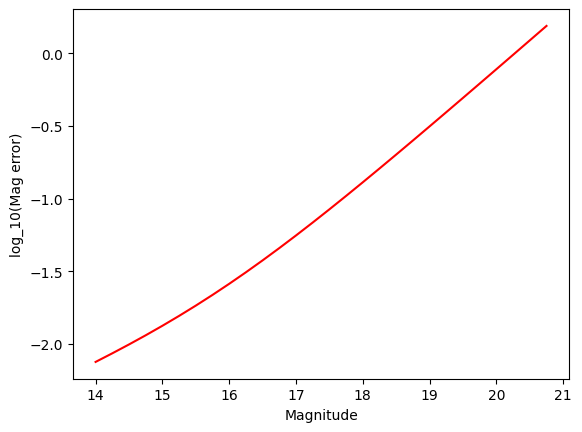

In [35]:
mag = np.arange(14.0, 21.0, 0.25)
mag_err = add_lco_noise(mag)

plt.plot(mag, np.log10(mag_err), 'r-')
plt.xlabel('Magnitude')
plt.ylabel('log_10(Mag error)')

The next step is to simulate what observations LCO could deliver for a given event.  
This naturally includes the visibility of that target from all network sites as a function of 
time, but this is computationally expensive, so we use a pre-calculated table.  This table is created from the notebook visibility_calculations.ipynb in this repository - see that notebook for full details. 

In [36]:
file_path = './lco_1m_network_visibility.hdf5'
visibility_data = visibility_utils.read_visibility_data(file_path)

The function below applies the pre-calculated visibility data to work out which simulated LCO datapoints would be viable observations and returns only those points. 

In [37]:
 def boundaries_check(times, interp_boundaries):
    idx = np.where(times < interp_boundaries[0])
    times[idx] = interp_boundaries[0]
    idx = np.where(times > interp_boundaries[1])
    times[idx] = interp_boundaries[1]
    return times

In [38]:
def observable_dates(input_ts, pixel_vis_func, interp_boundaries):
    """Function to determine whether or not a target is visible from the LCO 1m network 
    at the time stamps given, and return an array of timestamps with datapoints filtered 
    out if the target is not visible.  
    
    Note that this function is intended for multi-day arrays of timestamps, not intra-day.  
    
    While the input array of timestamps to interpolate for should be JD Time objects, 
    note that this is converted within the function into decimalyear, since this seasonal 
    visibility pattern can then be applied to any date.  
    """
        
    # Estimate the hours of visibility per timestamp.  
    ts = np.array([Time(t, format='jd') for t in input_ts])
    ts2 = np.array([(t.decimalyear-int(t.decimalyear)) for t in ts])
    ts2 = boundaries_check(ts2, interp_boundaries)
    hrs_visible = pixel_vis_func(ts2)
    
    # Filter out timestamps where the target isn't visible at all
    idx = np.where(hrs_visible > 0.0)
    
    return input_ts[idx]

The next function takes the simulated Bulge events, and generates a realistic set of LCO observations for that event, if it would be selected for observation using the Key Project strategy. 

In [39]:
def simulate_lco_observations(bulge_event, bulge_model, bulge_model_params, event_data, visibility_data, 
                              parallax=True):
    """Function to simulate LCO's observations of a given event.
    
    Observing strategy simulated:
    * Observe events only when brighter than 17.5mag
    * Cadence depends on event timescale:
    - tE <= 90d: cadence = once a day while  1.0tE <= |t-t0| <= 0.2tE, hourly 0.2tE <= |t-t0|
    - tE > 90d: cadence = once every two days
    * Declinations <= +10deg, simulate continuous cadence from 3 sites (24/7), modulo 10% random datapoints removed for weather
    * Declinations > +10deg, simulate continuous cadence from 1 site (8hrs out of 24), modulo weather
    """
    
    # Take a back-up copy of the original event object, since if no LCO observations are possible, 
    # this will be returned unchanged:
    original_event = copy.deepcopy(bulge_event)
    
    # First check whether the event ever gets bright enough for LCO 1-m observations. 
    # If observations are not viable, no additional lightcurve is added to the event
    survey_lc = bulge_event.telescopes[0].lightcurve_magnitude
    if len(survey_lc) == 0:
        return original_event
    
    mag_threshold = 17.5
    bright_data = np.where(survey_lc[:,1] <= mag_threshold)[0]
    if len(bright_data) == 0:
        print('Faint event, min '+str(survey_lc[:,1].min())+' no LCO observations')
        return original_event
    
    # Unpack the lens model parameters:
    if parallax:
        [to, uo, te, rho, piEN, piEE] = bulge_model_params
        print('Event model parameters: ', to, uo, te, rho, piEN, piEE)
    else:
        [to, uo, te, rho] = bulge_model_params
    
    # Determine how many hours per day LCO can observe the target.  We use NSIDE=32 here, 
    # since this is the resolution of the pre-calculated visibility data, but note that 
    # the data is extracted using the Python array index ipix rather than the HP index.
    # This returns the HEALpixel's visibility as a function of date, which is used to create
    # an interpolation function.
    s = SkyCoord(bulge_event.ra, bulge_event.dec, frame='icrs', unit=(u.deg, u.deg))
    hpindex = healpixel_functions.skycoord_to_HPindex(s, 32, radius=2.0)
    ipix = hpindex[0]
    
    pixel_visibility = visibility_data['total_hrs_visible'][ipix,:]
    
    interp_boundaries = (visibility_data['decimalyear'].min(), visibility_data['decimalyear'].max())
    pixel_vis_func = interpolate.interp1d(visibility_data['decimalyear'], pixel_visibility)
    
    # Determine timestamps of LCO observations, with a cadence which depends on the event tE
    start_jd = survey_lc[:,0].min()
    end_jd = survey_lc[:,0].max()
    
    # Long timescale events
    if te > 90.0:
        cadence = 2.0
        ts = np.arange(start_jd, end_jd, cadence)
    
    # Short timescale events
    else:
        # Peak observations are defined as those between +/- 0.2tE of t0
        deltat = (survey_lc[:,0] - to)/te
        
        # Pre-peak observations:
        # Figure out the timestamps when the event is in the pre-peak phase, taking LCO 
        # network visibility into account
        idx1 = np.where(deltat <= -0.2)[0]
        idx2 = np.where(deltat > -1.0)[0]
        idx = list(set(idx1).intersection(set(idx2)))
        if len(idx) > 0:
            pre_peak_start = survey_lc[idx,0].min()
            pre_peak_end = survey_lc[idx,0].max()
            cadence = 6.0/24.0 # days - 4x per day
            ts1 = np.arange(pre_peak_start, pre_peak_end, cadence)
            ts1 = observable_dates(ts1, pixel_vis_func, interp_boundaries)
        else:
            ts1 = np.array([])
            pre_peak_start = survey_lc[:,0].min()
            pre_peak_end = survey_lc[:,0].min()
            
        # Post-peak observations:
        idx1 = np.where(deltat >= 0.2)[0]
        idx2 = np.where(deltat < 1.0)[0]
        idx = list(set(idx1).intersection(set(idx2)))
        if len(idx) > 0:
            post_peak_start = survey_lc[idx,0].min()
            post_peak_end = survey_lc[idx,0].max()
            cadence = 6.0/24.0 # days - 4x per day
            ts3 = np.arange(post_peak_start, post_peak_end, cadence)
            ts3 = observable_dates(ts3, pixel_vis_func, interp_boundaries)
        else:
            ts3 = np.array([])
            post_peak_start = survey_lc[:,0].max()
            post_peak_end = survey_lc[:,0].max()
            
        # Peak observations
        cadence = 1.0/24.0
        ts2 = []
        day = pre_peak_end
        while (day < post_peak_start):
            # Estimate the number of hours that LCO can observe this target for
            t = Time(day, format='jd')
            t = t.decimalyear-int(t.decimalyear)
            t = boundaries_check(np.array([t]), interp_boundaries)[0]
            hours_per_night = pixel_vis_func(t)
            
            if hours_per_night > 0.0:
                # Simulate the timestamps of observations for one 24hr period, taking into account the numbers of 
                # hours that LCO can observe this target for:
                t = np.arange(day, day+(hours_per_night/24.0), cadence)
                ts2 += t.tolist()
                
            day += 1.0 # Increment the day number
        ts2 = np.array(ts2)
        
        # Binary lens events only
        # Make additional high cadence observations of two simulated caustic crossing events, 
        # each of which lasts 6hrs
        if event_data['binary_lens'] == 1:
            cadence = 15.0/(60.0*24.0) # Observe every 15mins
            caustic1 = np.arange(pre_peak_end, (pre_peak_end+(6.0/24.0)), cadence)
            caustic2 = np.arange(post_peak_start, (post_peak_start+(6.0/24.0)), cadence)
            ts4 = np.concatenate((caustic1, caustic2))
        else:
            ts4 = np.array([])
        
        ts = np.concatenate((ts1,ts2,ts3,ts4))
    
    # Randomly remove a certain fraction of points to simulate data losses due to weather:
    bad_weather_fraction = 0.1
    weathered_idx = np.random.randint(0, high=len(ts), size=int(len(ts)*bad_weather_fraction))
    ts = np.delete(ts, weathered_idx)
    
    # Its possible by now that we have no viable LCO observations.  If so, return the event without an 
    # LCO lightcurve attached
    if len(ts) == 0:
        print('No viable times for LCO observations')
        return original_event
    
    # Simulate the LCO photometry for these timestamps, assuming the same baseline magnitude as for the survey
    lc = np.zeros((len(ts),3))
    lc[:,0] = ts
    lc[:,1] = [np.median(survey_lc[:,1])] * len(ts)
    lc[:,2] = [0.01] * len(ts)
    tel = telescopes.Telescope(name='LCO', camera_filter='r',
                                     light_curve_magnitude=lc,
                                     location='Earth',
                                     light_curve_magnitude_dictionnary={'time': 0, 'mag': 1, 'err_mag': 2},
                                     clean_the_lightcurve=False)
    if len(bulge_event.telescopes) == 2:
        bulge_event.telescopes[1] = tel
    elif len(bulge_event.telescopes) < 2:
        bulge_event.telescopes.append(tel)
    else:
        raise IOError('Too many lightcurves on this model')
    
    if parallax:
        bulge_model.event.compute_parallax_all_telescopes(bulge_model.parallax_model)
        
    #tel = bulge_model.event.telescopes[-1]
    
    
    # Use the PyLIMA model to add a lensing event into the lightcurve
    pylima_parameters = bulge_model.compute_pyLIMA_parameters(bulge_model_params)
    print(event_data)
    pylima_parameters.g_OGLEMOA = float(event_data['blend_ratio'])
    
    # Add simulated blending to the parameter set, bearing in mind that OGLE's definition is the inverse of PyLIMA's
    #pylima_parameters.g_OGLEMOA = float(event_params['blend_ratio']) 
    
    # Use the blend ratio to create both source and blend unlensed lightcurves
    # f(t) = A(t)*f_s(t) + f_b 
    lightcurve = tel.lightcurve_magnitude
    (unlensed_lc, flux_err) = convert_mag_to_flux(lightcurve[:,1], lightcurve[:,2]) # Unlensed source lightcurve
    source_flux = unlensed_lc * pylima_parameters.g_OGLEMOA
    blend_flux = unlensed_lc * (1.0 - pylima_parameters.g_OGLEMOA)      # Blend lightcurve 
    
    # Use the PyLIMA model to add a lensing event into the source lightcurve
    magnification = bulge_model.model_magnification(tel, pylima_parameters)
    A = bulge_model.model_magnification(tel,pylima_parameters)
    source_flux *= A
    
    # Observed lightcurve is the combination of both lensed source and blend
    flux = source_flux + blend_flux
    
    # Convert back to magnitudes
    (lightcurve[:,1], mag_err) = convert_flux_to_mag(flux, flux_err)
    
    # Predict the photometric scatter for each datapoint, based on its magnitude
    phot_scatter = add_lco_noise(lightcurve[:,1])
    lightcurve[:,1] += phot_scatter * np.random.randn(len(lightcurve))
    
    # Calculate the photometric uncertainties
    lightcurve[:,2] = add_lco_noise(lightcurve[:,1])
    
    # Remove any LCO observations for datapoints below the brightness threshold
    idx = np.where(lightcurve[:,1] > mag_threshold)[0]
    lightcurve = np.delete(lightcurve, idx, axis=0)
    
    if len(lightcurve) == 0:
        print('Event remains too faint for LCO observations even when magnified')
        return original_event
    
    # Store the resulting lightcurve
    tel.lightcurve_magnitude = lightcurve
    bulge_event.telescopes[1] = tel
    
    return bulge_event


As a test example, we apply the LCO data simulator to one of the simulated events.  This returns an updated version of the simulated event object, with the LCO lightcurve appended to the associated list of datasets. 

In [40]:
event_number = 11
while (float(events_table[event_number]['baseline_mag']) > 17.0):
    event_number += 1
print('Picked new bright event: ',event_number,' baseline_mag=',events_table[event_number]['baseline_mag'],'mag')

bulge_lens = sim_bulge_lenses[event_number]
bulge_lens_model = sim_bulge_lens_models[event_number]
lens_model_pars = sim_model_params[event_number]

print(bulge_lens.telescopes)

updated_bulge_event = simulate_lco_observations(bulge_lens, bulge_lens_model, lens_model_pars, events_table[event_number], visibility_data)
print(bulge_lens.telescopes)



Picked new bright event:  13  baseline_mag= 15.908 mag
Event model parameters:  2460721.939716306 -0.28343869049606785 74.80608786320414 0.005663480075304175 -0.4568480976830385 0.18881481379736856
Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                              location                            baseline_mag blend_ratio         t0                 u0                  te                rho                  piEN                piEE        nvisits binary_lens
------------- ----- --------------------------------------------------------------- ------------ ----------- ----------------- -------------------- ----------------- -------------------- ------------------- ------------------- ------- -----------
BulgeSim00014 39741 <SkyCoord (ICRS): (ra, dec) in deg\n    (265.78125, -37.92165)>       15.908        0.78 2460721.939716306 -0.28343869049606785 74.80608786320414 0.005663480075304175 -0.4568480976830385 0.18881481379736856    1846           0
[<pyL

   EventID      HP                              location                            baseline_mag blend_ratio         t0                 u0                  te                rho                  piEN                piEE        nvisits binary_lens
------------- ----- --------------------------------------------------------------- ------------ ----------- ----------------- -------------------- ----------------- -------------------- ------------------- ------------------- ------- -----------
BulgeSim00014 39741 <SkyCoord (ICRS): (ra, dec) in deg\n    (265.78125, -37.92165)>       15.908        0.78 2460721.939716306 -0.28343869049606785 74.80608786320414 0.005663480075304175 -0.4568480976830385 0.18881481379736856    1846           0
Got 2 lightcurves
[[2.46015750e+06 1.59067491e+01 3.21983646e-03]
 [2.46015783e+06 1.59067470e+01 3.21983018e-03]
 [2.46015817e+06 1.59067449e+01 3.21982389e-03]
 ...
 [2.46125150e+06 1.59063847e+01 3.21874398e-03]
 [2.46125183e+06 1.59063880e+01 3.21875375e-

Text(0.5, 1.0, 'Simulated event BulgeSim00014')

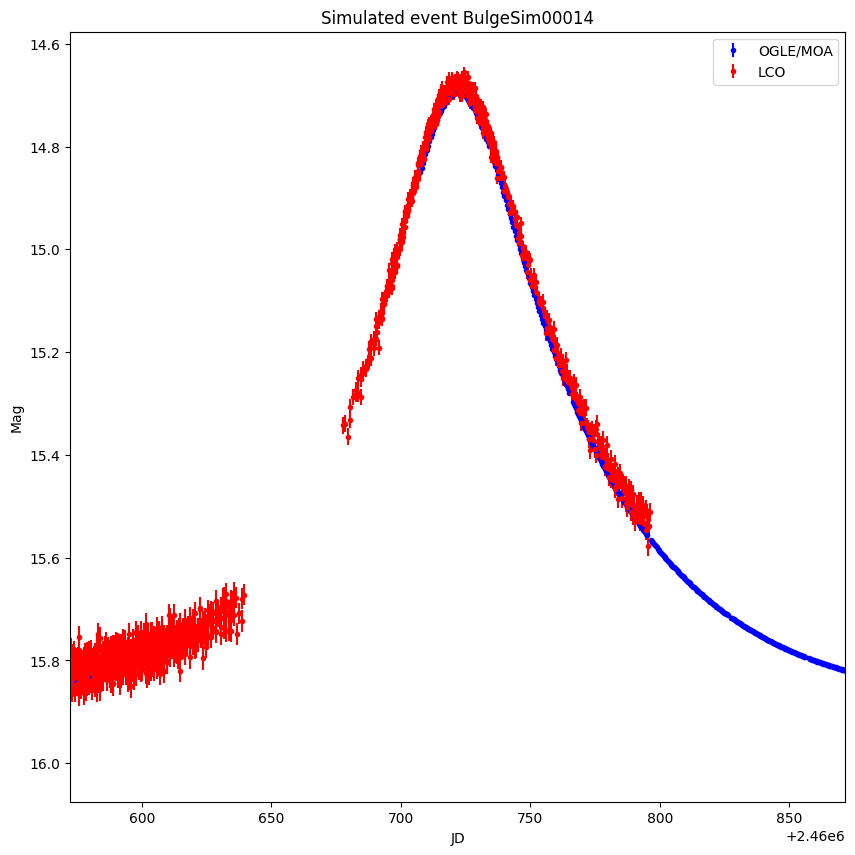

In [41]:
print(events_table[event_number])
fig = plt.figure(1,(10,10))
print('Got '+str(len(updated_bulge_event.telescopes))+' lightcurves')
lc1 = updated_bulge_event.telescopes[0].lightcurve_magnitude
print(lc1)
plt.errorbar(lc1[:,0], lc1[:,1], yerr=lc1[:,2], label='OGLE/MOA', fmt='b.')
lc2 = updated_bulge_event.telescopes[1].lightcurve_magnitude
print(lc2)
plt.errorbar(lc2[:,0], lc2[:,1], yerr=lc2[:,2], label='LCO', fmt='r.')
[xmin, xmax, ymin, ymax] = plt.axis()
xmin = lens_model_pars[0] - 2.0*lens_model_pars[2]
xmax = lens_model_pars[0] + 2.0*lens_model_pars[2]
plt.axis([xmin, xmax, ymax, ymin])
plt.xlabel('JD')
plt.ylabel('Mag')
plt.legend()
plt.title('Simulated event '+events_table[event_number]['EventID'])

We can now simulate LCO observations for the full set of simulated Bulge events

In [42]:
simulated_events_list = []

for ievent in range(0,len(events_table),1):
    updated_bulge_event = simulate_lco_observations(sim_bulge_lenses[ievent], 
                                                   sim_bulge_lens_models[ievent], 
                                                   sim_model_params[ievent], 
                                                   events_table[ievent],
                                                   visibility_data)
    simulated_events_list.append(updated_bulge_event)

Event model parameters:  2460347.999330287 -0.0743055496887047 16.687683037247062 0.019014411552932767 0.6830319668365106 0.24638403412486695
Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                             location                           baseline_mag blend_ratio         t0                 u0                 te                 rho                 piEN                piEE        nvisits binary_lens
------------- ----- ------------------------------------------------------------- ------------ ----------- ----------------- ------------------- ------------------ -------------------- ------------------ ------------------- ------- -----------
BulgeSim00001 39232 <SkyCoord (ICRS): (ra, dec) in deg\n    (270., -36.42357222)>       17.908        0.78 2460347.999330287 -0.0743055496887047 16.687683037247062 0.019014411552932767 0.6830319668365106 0.24638403412486695    1846           0
Event model parameters:  2460936.6027459316 0.11208660045660437 24.460

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                               location                              baseline_mag blend_ratio         t0                u0                 te                 rho                  piEN                piEE        nvisits binary_lens
------------- ----- ------------------------------------------------------------------ ------------ ----------- ----------------- ------------------ ------------------ -------------------- ------------------- ------------------- ------- -----------
BulgeSim00022 33597 <SkyCoord (ICRS): (ra, dec) in deg\n    (265.78125, -21.38194167)>       16.908        0.78 2460943.682705551 -0.567798039512259 22.500157201388422 0.007084804774425323 0.30897726855671503 0.04821996360485932    1846           0
Event model parameters:  2460666.351934352 0.41134517269091286 13.450095102231323 0.0067238593011391765 0.11433674435687582 0.4002829235690916
Parallax(Full) estimated for the telescope LCO: SUCCES

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                                location                              baseline_mag blend_ratio         t0                 u0                 te                rho                 piEN               piEE        nvisits binary_lens
------------- ----- ------------------------------------------------------------------- ------------ ----------- ------------------ ------------------ ----------------- -------------------- ------------------ ------------------ ------- -----------
BulgeSim00056 37441 <SkyCoord (ICRS): (ra, dec) in deg\n    (272.109375, -31.38816389)>       16.158        0.78 2460943.8510410287 0.6802326255429577 68.09448858005945 0.016157212048999815 1.0159491783854762 0.4105737040010497    1846           1
Faint event, min 18.184210651130506 no LCO observations
Event model parameters:  2461061.744041559 0.2970608274262208 85.19596820188345 0.011054315038229718 -1.4216820026041592 -0.15629479355606818
Pa

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                               location                              baseline_mag blend_ratio         t0                 u0                 te                 rho                 piEN                piEE         nvisits binary_lens
------------- ----- ------------------------------------------------------------------ ------------ ----------- ------------------ ------------------ ------------------ -------------------- ------------------ -------------------- ------- -----------
BulgeSim00081 33597 <SkyCoord (ICRS): (ra, dec) in deg\n    (265.78125, -21.38194167)>       17.658        0.78 2460676.5151664657 0.1086760316063589 28.051203641884808 0.010214346094715936 0.3108731102660116 -0.39268186736181737    1846           0
Faint event, min 18.656497324514465 no LCO observations
Faint event, min 18.546031000506428 no LCO observations
Faint event, min 18.83563878140297 no LCO observations
Event model parameters:  24

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                                location                              baseline_mag blend_ratio         t0                  u0                  te                rho                  piEN                 piEE         nvisits binary_lens
------------- ----- ------------------------------------------------------------------- ------------ ----------- ------------------ -------------------- ----------------- -------------------- -------------------- -------------------- ------- -----------
BulgeSim00104 38463 <SkyCoord (ICRS): (ra, dec) in deg\n    (269.296875, -34.22886389)>       17.908        0.78 2460954.4259961094 -0.07843652934564638 35.16798854753625 0.012033215069530076 -0.14950424711414262 -0.09597746013818012    1846           0
Faint event, min 17.755629998030642 no LCO observations
Event model parameters:  2461240.7346540242 0.059687038281922386 36.407929863205915 0.003168453702879953 -0.9106703988249623 -

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                            location                          baseline_mag blend_ratio         t0                u0                 te                rho                   piEN                 piEE        nvisits binary_lens
------------- ----- ----------------------------------------------------------- ------------ ----------- ----------------- ------------------ ----------------- -------------------- --------------------- ------------------- ------- -----------
BulgeSim00120 36920 <SkyCoord (ICRS): (ra, dec) in deg\n    (259.453125, -30.)>       16.908        0.28 2460839.101025308 0.1821901354695907 69.84264878473621 0.009309555558027703 -0.024513464538692548 0.13123010041734093    1846           0
Faint event, min 19.345427246146684 no LCO observations
Event model parameters:  2460372.4399707895 0.36895161221905226 45.511383876423864 0.02092663987743327 1.1072479382608362 0.28362663006871836
Parallax(Full) es

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                                location                              baseline_mag blend_ratio         t0                 u0                 te                rho                 piEN               piEE        nvisits binary_lens
------------- ----- ------------------------------------------------------------------- ------------ ----------- ------------------ ------------------ ----------------- -------------------- ------------------ ------------------ ------- -----------
BulgeSim00137 33855 <SkyCoord (ICRS): (ra, dec) in deg\n    (269.296875, -22.02431111)>       17.158        0.78 2460312.3476546607 0.1163815008244618 20.33463612523823 0.013865210353714104 0.9156525502780628 0.1653613877585566    1846           0
Faint event, min 18.089053961473617 no LCO observations
Faint event, min 17.65284302012842 no LCO observations
Faint event, min 19.90767177033377 no LCO observations
Event model parameters:  2460986.6

Event model parameters:  2460372.764212799 0.0865195749980511 19.94302089198074 0.04129386546049351 0.38192938660302017 0.13521865785350642
Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                                location                              baseline_mag blend_ratio         t0                u0                 te                rho                 piEN                piEE        nvisits binary_lens
------------- ----- ------------------------------------------------------------------- ------------ ----------- ----------------- ------------------ ----------------- ------------------- ------------------- ------------------- ------- -----------
BulgeSim00156 37440 <SkyCoord (ICRS): (ra, dec) in deg\n    (270.703125, -31.38816389)>       18.158        0.78 2460372.764212799 0.0865195749980511 19.94302089198074 0.04129386546049351 0.38192938660302017 0.13521865785350642    1846           1
Faint event, min 18.08890375415983 no LCO observations
Faint

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                                location                              baseline_mag blend_ratio         t0                u0                 te                rho                 piEN               piEE         nvisits binary_lens
------------- ----- ------------------------------------------------------------------- ------------ ----------- ----------------- ------------------ ----------------- -------------------- ----------------- -------------------- ------- -----------
BulgeSim00181 34364 <SkyCoord (ICRS): (ra, dec) in deg\n    (265.078125, -23.31795556)>       17.908        0.78 2460502.075780105 0.2552001827541004 61.20996279405012 0.010795920069565685 1.162959405074445 -0.14195005576923492    1846           0
Event model parameters:  2461242.530380206 0.6448118989577057 29.70843551750055 0.032915151867329434 -0.20588072799008206 0.032284521926104606
Parallax(Full) estimated for the telescope LCO: SUCCESS
 

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                              location                             baseline_mag blend_ratio         t0                 u0                 te                 rho                 piEN               piEE        nvisits binary_lens
------------- ----- ---------------------------------------------------------------- ------------ ----------- ------------------ ------------------ ------------------ -------------------- ------------------ ------------------ ------- -----------
BulgeSim00202 34116 <SkyCoord (ICRS): (ra, dec) in deg\n    (275.625, -22.66960833)>       17.658        0.78 2460594.4560072925 0.5085753790446091 22.941309963458014 0.012592746313986401 1.3062694178805585 0.0802669573104231    1846           0
Faint event, min 18.62171966606867 no LCO observations
Event model parameters:  2460304.63896832 0.14680241739242025 17.16521153539502 0.028018451587209982 0.17299130820302994 -0.03498768037952112
Parallax(

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                                location                              baseline_mag blend_ratio         t0                 u0                 te                 rho                 piEN                piEE        nvisits binary_lens
------------- ----- ------------------------------------------------------------------- ------------ ----------- ------------------ ------------------ ------------------ -------------------- ------------------ ------------------- ------- -----------
BulgeSim00220 36418 <SkyCoord (ICRS): (ra, dec) in deg\n    (273.515625, -28.63098889)>       17.658        0.78 2460691.7951929327 0.3877510112257002 22.283553965827583 0.025998415932541215 0.4307536873965032 -0.4156715256845191    1846           0
Event model parameters:  2460918.28579153 0.8326911149608571 28.635120687366715 0.01702373580995073 -0.6679452595439193 0.18849114839855652
Parallax(Full) estimated for the telescope LCO: SUCCES

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                               location                              baseline_mag blend_ratio        t0                u0                 te                rho                 piEN               piEE        nvisits binary_lens
------------- ----- ------------------------------------------------------------------ ------------ ----------- ---------------- ------------------ ----------------- -------------------- ------------------ ------------------ ------- -----------
BulgeSim00242 36155 <SkyCoord (ICRS): (ra, dec) in deg\n    (262.96875, -27.95318611)>       14.658        0.53 2461220.93789387 0.2830906357473748 48.09965828627236 0.014995748662031553 0.5192944196730751 0.0552996477395911    1846           0
Event model parameters:  2461045.5226893523 -0.19147951296202068 80.00196702272461 0.009133244627707697 1.1210042454526565 -0.10562491472415697
Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventI

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                                location                              baseline_mag blend_ratio         t0                  u0                 te                 rho                   piEN                 piEE         nvisits binary_lens
------------- ----- ------------------------------------------------------------------- ------------ ----------- ------------------ ------------------- ------------------ -------------------- --------------------- -------------------- ------- -----------
BulgeSim00262 33857 <SkyCoord (ICRS): (ra, dec) in deg\n    (272.109375, -22.02431111)>       16.408        0.78 2461049.0021594954 0.22104430097209898 37.715925749517254 0.037452982981606785 -0.022479031359589008 -0.37396565053593583    1846           0
Faint event, min 18.04828547435444 no LCO observations
Event model parameters:  2460267.0526567553 0.3043075713495872 15.675290737928023 0.0006873157837862008 -0.6083208368079609 

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                               location                              baseline_mag blend_ratio         t0                  u0                 te                 rho                piEN                piEE         nvisits binary_lens
------------- ----- ------------------------------------------------------------------ ------------ ----------- ------------------ ------------------- ------------------ ------------------- ------------------ -------------------- ------- -----------
BulgeSim00284 37187 <SkyCoord (ICRS): (ra, dec) in deg\n    (274.21875, -30.69158611)>       17.408        0.78 2460205.1278151753 -0.5247521452895441 183.60779324063623 0.01942945374228236 0.2667207861615211 0.023448434413954746    1846           0
Faint event, min 19.657407164978796 no LCO observations
Event model parameters:  2460396.6665069475 -0.07585416909990009 119.6753528307395 0.0054388863025738535 0.6930320915058965 0.219467014244

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                                location                              baseline_mag blend_ratio         t0                u0                 te                 rho                  piEN                piEE        nvisits binary_lens
------------- ----- ------------------------------------------------------------------- ------------ ----------- ----------------- ------------------ ------------------ -------------------- ------------------- ------------------- ------- -----------
BulgeSim00314 37952 <SkyCoord (ICRS): (ra, dec) in deg\n    (270.703125, -32.79716667)>       17.658        0.78 2460535.753257036 0.6218267861551884 26.606414837797832 0.006067101904227879 -0.6170516076258739 -0.1652650063220216    1846           1
Faint event, min 17.88569607861033 no LCO observations
Faint event, min 17.646505020701873 no LCO observations
Faint event, min 18.643392462221392 no LCO observations
Faint event, min 20.4930182

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                                location                              baseline_mag blend_ratio         t0                   u0                  te                rho                  piEN                 piEE         nvisits binary_lens
------------- ----- ------------------------------------------------------------------- ------------ ----------- ------------------ --------------------- ----------------- -------------------- -------------------- -------------------- ------- -----------
BulgeSim00346 35393 <SkyCoord (ICRS): (ra, dec) in deg\n    (272.109375, -25.94447778)>       15.158        0.78 2461152.9274939233 -0.041682319902433096 36.97566179501336 0.018456308737686597 -0.48321773989231104 -0.27654189087141534    1846           0
Faint event, min 18.162056964098547 no LCO observations
Event model parameters:  2460937.8918164764 -0.06318769349784814 23.067570758236954 0.01824367086400195 1.1049608268583155 

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                              location                            baseline_mag blend_ratio         t0                 u0                 te                 rho                 piEN               piEE        nvisits binary_lens
------------- ----- --------------------------------------------------------------- ------------ ----------- ----------------- ------------------- ------------------ -------------------- ------------------ ------------------ ------- -----------
BulgeSim00370 37691 <SkyCoord (ICRS): (ra, dec) in deg\n    (262.96875, -32.08995)>       16.908        0.78 2460706.983834921 0.22747368483444216 19.725808044039503 0.014498470007539083 0.8953432203925322 0.5372114008666198    1846           1
Event model parameters:  2461174.4978420823 0.4676234608231796 3.3471499045528743 0.012129105324042974 0.04717459812204865 0.021790578254346687
Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventI

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                             location                           baseline_mag blend_ratio         t0                 u0                 te                 rho                 piEN                piEE         nvisits binary_lens
------------- ----- ------------------------------------------------------------- ------------ ----------- ----------------- ------------------- ------------------ -------------------- ------------------ -------------------- ------- -----------
BulgeSim00390 38720 <SkyCoord (ICRS): (ra, dec) in deg\n    (270., -34.95386389)>       15.908        0.78 2460659.758703091 0.26768907218157756 16.110939936704998 0.021246630753696073 0.4354232500236286 -0.26233222391288025    1846           0
Faint event, min 19.5294606784101 no LCO observations
Event model parameters:  2461218.4158435934 0.1022127051764102 13.936585634750191 0.007770614594346566 1.1025180038647577 0.17785117668579978
Parallax(Full

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                              location                             baseline_mag blend_ratio         t0                  u0                  te                rho                  piEN                 piEE        nvisits binary_lens
------------- ----- ---------------------------------------------------------------- ------------ ----------- ------------------ -------------------- ----------------- -------------------- -------------------- ------------------- ------- -----------
BulgeSim00415 34108 <SkyCoord (ICRS): (ra, dec) in deg\n    (264.375, -22.66960833)>       17.408        0.03 2460992.9187887567 -0.07583040862437368 9.509639140360145 0.019503800430712107 -0.38604426136528885 0.09460036249698123    1846           1
Faint event, min 18.76719448809864 no LCO observations
Event model parameters:  2460521.31453873 -0.5017790012441953 110.95667683564324 0.01856343911584224 0.9207852104758809 0.17489258204719743

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                            location                          baseline_mag blend_ratio         t0                  u0                te                rho                 piEN                piEE         nvisits binary_lens
------------- ----- ----------------------------------------------------------- ------------ ----------- ------------------ ------------------- ---------------- ------------------- ------------------- -------------------- ------- -----------
BulgeSim00431 36928 <SkyCoord (ICRS): (ra, dec) in deg\n    (270.703125, -30.)>       15.658        0.78 2461069.6076442148 -0.1977794530715408 22.5419112416322 0.01773689839571567 0.14319467239658548 -0.15265501945961363    1846           0
Event model parameters:  2461157.5863272 -0.030903765243287556 25.499247171029563 0.013753323448867491 -0.9924038017584902 -0.09654886429575016
Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                               location                             baseline_mag blend_ratio         t0                 u0                 te                rho                 piEN                piEE         nvisits binary_lens
------------- ----- ----------------------------------------------------------------- ------------ ----------- ------------------ ------------------ ----------------- -------------------- ------------------ -------------------- ------- -----------
BulgeSim00456 33086 <SkyCoord (ICRS): (ra, dec) in deg\n    (267.1875, -20.10550833)>       15.908        0.03 2461119.9396585487 0.5595961460734393 132.5811655984523 0.023251809574504283 0.2176940399337783 -0.27536755866163715    1846           0
Faint event, min 19.023780193762107 no LCO observations
Event model parameters:  2460492.7823753455 -0.03947546740008567 22.110050118107505 0.018794075954766135 -1.9138422580540981 -0.2272101060410582

Event model parameters:  2460193.089588985 0.4415243181088928 12.289845228505106 0.02014338669658857 -0.8776897364437128 0.14298308584200062
Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                                location                              baseline_mag blend_ratio         t0                u0                 te                 rho                 piEN                piEE        nvisits binary_lens
------------- ----- ------------------------------------------------------------------- ------------ ----------- ----------------- ------------------ ------------------ ------------------- ------------------- ------------------- ------- -----------
BulgeSim00480 34881 <SkyCoord (ICRS): (ra, dec) in deg\n    (272.109375, -24.62431667)>       14.658        0.28 2460193.089588985 0.4415243181088928 12.289845228505106 0.02014338669658857 -0.8776897364437128 0.14298308584200062    1846           0
Faint event, min 21.19045988842943 no LCO observations
F

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                               location                             baseline_mag blend_ratio         t0                  u0                  te                rho                 piEN               piEE       nvisits binary_lens
------------- ----- ----------------------------------------------------------------- ------------ ----------- ------------------ -------------------- ----------------- -------------------- ------------------ ----------------- ------- -----------
BulgeSim00503 36670 <SkyCoord (ICRS): (ra, dec) in deg\n    (267.1875, -29.31319722)>       18.158        0.53 2461182.6598220547 -0.14301722307100437 164.1467052088494 0.026286313136559436 0.6549895478304955 0.311691091351051    1846           0
Faint event, min 20.410007515113968 no LCO observations
Faint event, min 20.394928349104877 no LCO observations
Event model parameters:  2460639.7158107385 0.28382049270787435 69.4541545062882 0.02089404

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                             location                            baseline_mag blend_ratio         t0                  u0                 te                 rho                  piEN                piEE         nvisits binary_lens
------------- ----- -------------------------------------------------------------- ------------ ----------- ------------------ ------------------- ----------------- --------------------- ------------------- -------------------- ------- -----------
BulgeSim00534 39742 <SkyCoord (ICRS): (ra, dec) in deg\n    (267.1875, -37.92165)>       16.658        0.78 2460320.8977010855 -0.5817573036392049 48.06871899816564 0.0007429415754186637 -0.8352982848301573 -0.16927322164249156    1846           0
Faint event, min 18.90414111102129 no LCO observations
Event model parameters:  2460614.1947994255 0.1564940502842575 15.41676162858132 0.019283752477055133 0.5593713796338102 0.2757930489474639
Paral

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                            location                          baseline_mag blend_ratio         t0                  u0                 te                rho                 piEN                piEE        nvisits binary_lens
------------- ----- ----------------------------------------------------------- ------------ ----------- ------------------ ------------------- ----------------- ------------------- ------------------- ------------------- ------- -----------
BulgeSim00553 36930 <SkyCoord (ICRS): (ra, dec) in deg\n    (273.515625, -30.)>       15.908        0.78 2461170.8822151474 -0.4607752762729804 28.28058147501802 0.00999934992117466 -0.8277220220722252 0.19409372356397664    1846           0
Faint event, min 18.537851768196923 no LCO observations
Event model parameters:  2460744.1258286526 -0.04797538372381069 12.396289835805236 0.01184289683286071 -1.0163392382193872 -0.4090880990634422
Parallax(Full) est

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                                location                              baseline_mag blend_ratio         t0                  u0                  te                 rho                 piEN               piEE        nvisits binary_lens
------------- ----- ------------------------------------------------------------------- ------------ ----------- ------------------ -------------------- ------------------ -------------------- ------------------ ------------------ ------- -----------
BulgeSim00578 33858 <SkyCoord (ICRS): (ra, dec) in deg\n    (273.515625, -22.02431111)>       16.658        0.78 2460869.1350193676 0.032484038145081315 42.856944820592915 0.008738912551336363 -0.019611505147136 -0.188292446889354    1846           0
Faint event, min 18.5716133428895 no LCO observations
Faint event, min 20.68390498981165 no LCO observations
Faint event, min 18.134403188125866 no LCO observations
Faint event, min 17.526527

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                               location                             baseline_mag blend_ratio         t0                 u0                 te                rho                 piEN                piEE         nvisits binary_lens
------------- ----- ----------------------------------------------------------------- ------------ ----------- ----------------- ------------------- ----------------- -------------------- ------------------ -------------------- ------- -----------
BulgeSim00602 35650 <SkyCoord (ICRS): (ra, dec) in deg\n    (272.8125, -26.61009722)>       15.908        0.03 2461000.057460783 0.16634130335359715 33.19119062077383 0.020123508432828344 1.3778402524904778 0.044307240377984496    1846           0
Faint event, min 20.542405479180875 no LCO observations
Faint event, min 18.50310714207089 no LCO observations
Faint event, min 18.30078129015299 no LCO observations
Faint event, min 20.28240467153045

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                              location                             baseline_mag blend_ratio         t0                  u0                 te                rho                  piEN                piEE         nvisits binary_lens
------------- ----- ---------------------------------------------------------------- ------------ ----------- ------------------ ------------------- ----------------- -------------------- ------------------- -------------------- ------- -----------
BulgeSim00641 34620 <SkyCoord (ICRS): (ra, dec) in deg\n    (264.375, -23.96948056)>       17.158        0.78 2461125.9046603385 -0.3355112105970901 291.8315797637166 0.006327099659267733 -1.0480193385027154 -0.11215692080209144    1846           0
Faint event, min 18.90878192358602 no LCO observations
Faint event, min 21.485914063383326 no LCO observations
Faint event, min 18.524927260470143 no LCO observations
Event model parameters:  24606

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                                location                              baseline_mag blend_ratio         t0                u0                 te                 rho                 piEN                piEE         nvisits binary_lens
------------- ----- ------------------------------------------------------------------- ------------ ----------- ----------------- ------------------ ------------------ ------------------- ------------------- -------------------- ------- -----------
BulgeSim00671 36418 <SkyCoord (ICRS): (ra, dec) in deg\n    (273.515625, -28.63098889)>       15.658        0.78 2460909.227696588 0.6436084589698049 37.366082095216214 0.00530241341397213 0.17424336627010148 -0.21725856984585443    1846           0
Event model parameters:  2460771.983638198 0.2979675353194513 13.733357152807676 0.002200402284091375 0.4356965619808053 0.09601131326094825
Parallax(Full) estimated for the telescope LCO: SUCCE

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                              location                             baseline_mag blend_ratio         t0                 u0                 te                rho                 piEN                piEE        nvisits binary_lens
------------- ----- ---------------------------------------------------------------- ------------ ----------- ------------------ ------------------ ----------------- ------------------- ------------------- ------------------- ------- -----------
BulgeSim00689 34116 <SkyCoord (ICRS): (ra, dec) in deg\n    (275.625, -22.66960833)>       16.658        0.78 2460914.8809201843 0.2660314245523373 94.10595913431145 0.02304332875256106 -0.1567570817458237 0.07935704963444275    1846           0
Event model parameters:  2460190.159501302 0.5206516577570565 218.6890855622861 0.03229282359716791 -0.25644920538276195 -0.20329969948940924
Parallax(Full) estimated for the telescope LCO: SUCCESS
   Event

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                                location                              baseline_mag blend_ratio         t0                 u0                 te                  rho                 piEN                piEE        nvisits binary_lens
------------- ----- ------------------------------------------------------------------- ------------ ----------- ----------------- ------------------- ------------------ --------------------- ------------------ ------------------- ------- -----------
BulgeSim00723 33858 <SkyCoord (ICRS): (ra, dec) in deg\n    (273.515625, -22.02431111)>       18.158        0.78 2460877.110394901 0.42706149267669113 37.777850704828445 0.0026274699106162303 0.3631987866025426 0.27809882832562083    1846           1
Event model parameters:  2460786.915959459 0.41403605882068784 102.84249425350451 0.005896928592277273 -0.10378032945781845 -0.3540518676318624
Parallax(Full) estimated for the telescope LCO:

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                               location                              baseline_mag blend_ratio         t0                 u0                 te                rho                 piEN                piEE         nvisits binary_lens
------------- ----- ------------------------------------------------------------------ ------------ ----------- ----------------- ------------------- ----------------- -------------------- ------------------ -------------------- ------- -----------
BulgeSim00740 35131 <SkyCoord (ICRS): (ra, dec) in deg\n    (262.96875, -25.28260278)>       17.158        0.78 2460621.992627946 0.32214294240071273 44.09812257319245 0.004523578655895203 1.9596397068818856 0.010767163635372903    1846           0
Faint event, min 19.26508034654699 no LCO observations
Event model parameters:  2460505.6457586484 0.027367121003931183 47.99122009732195 0.006837290596851331 -0.2328935294657643 0.0043665322858747

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                                location                              baseline_mag blend_ratio         t0                 u0                  te                rho                  piEN                piEE        nvisits binary_lens
------------- ----- ------------------------------------------------------------------- ------------ ----------- ----------------- -------------------- ----------------- -------------------- ------------------- ------------------- ------- -----------
BulgeSim00764 38464 <SkyCoord (ICRS): (ra, dec) in deg\n    (270.703125, -34.22886389)>       16.158        0.78 2460324.332810407 0.024835499894341362 14.45172712510408 0.013415438289819765 -0.1058588718502313 -0.1282928988475691    1846           0
Event model parameters:  2460817.9349077977 0.1974238254759293 25.950104337933485 0.0009075191206768659 0.39546403243210415 0.01578479724247856
Parallax(Full) estimated for the telescope LCO:

Faint event, min 19.37360076015236 no LCO observations
Event model parameters:  2461193.1138029234 0.48509535729109643 13.286442103898308 0.02052747602339599 -0.05618202448820672 0.06126467211359869
Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                                location                              baseline_mag blend_ratio         t0                  u0                 te                 rho                 piEN                 piEE        nvisits binary_lens
------------- ----- ------------------------------------------------------------------- ------------ ----------- ------------------ ------------------- ------------------ ------------------- -------------------- ------------------- ------- -----------
BulgeSim00783 35898 <SkyCoord (ICRS): (ra, dec) in deg\n    (262.265625, -27.27961111)>       16.658        0.78 2461193.1138029234 0.48509535729109643 13.286442103898308 0.02052747602339599 -0.05618202448820672 0.06126467211359869    1846  

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                                location                              baseline_mag blend_ratio        t0                 u0                  te                rho                  piEN                 piEE         nvisits binary_lens
------------- ----- ------------------------------------------------------------------- ------------ ----------- ---------------- -------------------- ----------------- -------------------- ------------------- --------------------- ------- -----------
BulgeSim00807 38976 <SkyCoord (ICRS): (ra, dec) in deg\n    (270.703125, -35.68533333)>       14.908        0.78 2461065.03758801 0.019911383132979424 16.71991635643196 0.007638189572490855 -1.2104447639331977 -0.061083008166150345    1846           0
Event model parameters:  2460785.2201240608 -0.10308496252954183 227.25107369819756 0.005743493919784121 0.7387407107192936 -0.09723452242844252
Parallax(Full) estimated for the telescope 

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                                location                              baseline_mag blend_ratio         t0                  u0                 te                 rho                  piEN                piEE         nvisits binary_lens
------------- ----- ------------------------------------------------------------------- ------------ ----------- ------------------ ------------------- ------------------ -------------------- ------------------- -------------------- ------- -----------
BulgeSim00825 34367 <SkyCoord (ICRS): (ra, dec) in deg\n    (269.296875, -23.31795556)>       15.908        0.78 2460212.7433205238 0.22805488845866614 53.834967501228455 0.011917661836106142 0.39916900440450065 -0.08653491672559008    1846           0
Event model parameters:  2460475.6067159157 0.012429854297789478 14.025355823085318 0.032578219230862855 -1.0657034141916712 0.040827735438177956
Parallax(Full) estimated for the telesc

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                              location                             baseline_mag blend_ratio         t0                  u0                 te                 rho                 piEN                piEE         nvisits binary_lens
------------- ----- ---------------------------------------------------------------- ------------ ----------- ------------------ ------------------- ------------------ ------------------- ------------------- -------------------- ------- -----------
BulgeSim00846 38204 <SkyCoord (ICRS): (ra, dec) in deg\n    (264.375, -33.51005556)>       17.158        0.78 2461019.1367183877 0.11677559393385573 30.935399826474157 0.03702683789707864 -0.5748911214846977 -0.11074394110690802    1846           0
Faint event, min 18.139047046604762 no LCO observations
Faint event, min 17.898522253106968 no LCO observations
Event model parameters:  2460620.8668758254 -0.3499728825196592 22.548718897003933 0.

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                                location                              baseline_mag blend_ratio         t0                 u0                  te                rho                piEN               piEE        nvisits binary_lens
------------- ----- ------------------------------------------------------------------- ------------ ----------- ----------------- -------------------- ----------------- ------------------- ------------------ ------------------ ------- -----------
BulgeSim00882 35907 <SkyCoord (ICRS): (ra, dec) in deg\n    (274.921875, -27.27961111)>       16.158        0.78 2460648.628191584 -0.12808740230932938 85.42531779247912 0.01046539998697627 0.3942771448771187 0.0607201721156414    1846           0
Event model parameters:  2460815.801468031 -0.04381767028622979 16.867565639725626 0.004925727569840752 1.3527831619708823 -0.32034943753399125
Parallax(Full) estimated for the telescope LCO: SUCCESS


Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                               location                             baseline_mag blend_ratio         t0                u0                te                 rho                 piEN                piEE        nvisits binary_lens
------------- ----- ----------------------------------------------------------------- ------------ ----------- ----------------- ----------------- ------------------ -------------------- ------------------ ------------------- ------- -----------
BulgeSim00905 35138 <SkyCoord (ICRS): (ra, dec) in deg\n    (272.8125, -25.28260278)>       17.158        0.78 2460419.146398642 0.579005228102107 12.470004127775098 0.029279472594126645 1.4139102363097145 0.11584362329377149    1846           1
Faint event, min 18.63870843493238 no LCO observations
Faint event, min 19.113194773191992 no LCO observations
Faint event, min 19.164747693799136 no LCO observations
Faint event, min 19.22056701359081 no L

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                               location                             baseline_mag blend_ratio         t0                 u0                 te                 rho                 piEN                 piEE         nvisits binary_lens
------------- ----- ----------------------------------------------------------------- ------------ ----------- ------------------ ------------------ ------------------ ------------------- -------------------- -------------------- ------- -----------
BulgeSim00920 36162 <SkyCoord (ICRS): (ra, dec) in deg\n    (272.8125, -27.95318611)>       18.658        0.28 2460431.2911259024 0.0980862827510573 33.156038968072274 0.01982536374576354 -0.35339738007259675 -0.37836514753138273    1846           0
Faint event, min 19.40349048999532 no LCO observations
Event model parameters:  2461150.338427182 0.5907559720640413 66.11256932186429 0.013681045982019524 0.8880021009565533 0.1164634747086184


Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                              location                             baseline_mag blend_ratio         t0                 u0                  te                rho                 piEN                piEE         nvisits binary_lens
------------- ----- ---------------------------------------------------------------- ------------ ----------- ----------------- -------------------- ----------------- -------------------- ------------------ -------------------- ------- -----------
BulgeSim00944 34116 <SkyCoord (ICRS): (ra, dec) in deg\n    (275.625, -22.66960833)>       15.408        0.78 2461110.791696415 -0.09187635332713787 89.29166092472309 0.013070094113124205 0.6091772578465127 -0.10624571688522236    1846           0
Faint event, min 18.799067969861234 no LCO observations
Event model parameters:  2460439.56010382 -0.10814860020324399 9.778980582974613 0.010983675669509235 0.6904216910093199 -0.30050355827924596
Pa

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                                location                              baseline_mag blend_ratio         t0                 u0                  te                rho                 piEN                piEE        nvisits binary_lens
------------- ----- ------------------------------------------------------------------- ------------ ----------- ----------------- -------------------- ----------------- -------------------- ------------------ ------------------- ------- -----------
BulgeSim00965 33342 <SkyCoord (ICRS): (ra, dec) in deg\n    (267.890625, -20.74237778)>       16.908        0.78 2461002.958877347 -0.05664583702617859 48.06473666400229 0.007550174600525464 0.6106696034539523 -0.2076314125666828    1846           1
Faint event, min 19.501868764325714 no LCO observations
Faint event, min 18.369228909609525 no LCO observations
Faint event, min 17.65845632257369 no LCO observations
Event model parameters:  24

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                                location                              baseline_mag blend_ratio         t0                  u0                 te                 rho                  piEN                piEE         nvisits binary_lens
------------- ----- ------------------------------------------------------------------- ------------ ----------- ------------------ ------------------- ------------------ -------------------- ------------------- -------------------- ------- -----------
BulgeSim00986 34883 <SkyCoord (ICRS): (ra, dec) in deg\n    (274.921875, -24.62431667)>       16.658        0.78 2460321.1284718057 0.09486512784472315 32.524043125826864 0.026153094305626276 -0.8656096203146237 -0.26631501303749505    1846           0
Faint event, min 20.468701182864724 no LCO observations
Faint event, min 20.155744590690556 no LCO observations
Event model parameters:  2461007.3440053724 0.2939246543912093 40.7749937

In [43]:
file_path = 'simulated_lco_lightcurves_bulge_events.hdf5'

with h5py.File(file_path, "w") as f:
    
    for ievent in range(0,len(simulated_events_list),1):
        if len(simulated_events_list[ievent].telescopes) == 2:
            lc = simulated_events_list[ievent].telescopes[1].lightcurve_magnitude
        else:
            lc = np.array([])
        dset = f.create_dataset(events_table[ievent]['EventID'],
                            lc.shape,
                            dtype='float64',
                            data=lc)
    f.close()

## Evalulating how well we can characterize events

A key test of the observing strategy is how well we can constraint the event parameters as a result of the lightcurves produced.  

In order to evaluate this, we fit a microlensing model to the two lightcurves for each simulated event, as we would with real data, and then evaluate the fitted parameters of that model in comparison with the input simulated event parameters, as well as evaluating the uncertainties on the parameters key to measuring the mass of the events. 

In [44]:
class FitParams():
    """Object containing the fitted parameters and errors of a model fitted
    to a microlensing lightcurve"""
    
    def __init__(self):
        
        self.to = None
        self.toerr = None
        self.delta_to = None
        self.prop_delta_to = None
        self.to_within_range = None
        self.uo = None
        self.uoerr = None
        self.delta_uo = None
        self.prop_delta_uo = None
        self.uo_within_range = None
        self.tE= None
        self.tEerr = None
        self.delta_tE = None
        self.prop_delta_tE = None
        self.tE_within_range = None
        self.rho = None
        self.rhoerr = None
        self.piEN = None
        self.piENerr = None
        self.delta_piEN = None
        self.prop_delta_piEN = None
        self.piEN_within_range = None
        self.piEE= None
        self.piEEerr = None
        self.delta_piEE = None
        self.prop_delta_piEE = None
        self.piEE_within_range = None
        self.s = None
        self.serr = None
        self.q = None
        self.qerr = None
        self.logs = None
        self.logserr = None
        self.logq = None
        self.logqerr = None
        self.alpha = None
        self.alphaerr = None
        self.chichi = None
        self.bic = None
        self.nparam = 0
        self.type = None
        self.teerr_ok = None
        self.piEN_constrained = None
        self.piEE_constrained = None
    
    def extract_parameters_from_fit(self, fit, tel_list):
        fit_params = microloutputs.parameters_result(fit)
        fit_errors = microloutputs.fit_errors(fit)
    
        self.to = fit_params.to
        self.toerr = fit_errors.err_to
        self.tE = fit_params.tE
        self.tEerr = fit_errors.err_tE
        self.rho = fit_params.rho
        self.rhoerr = fit_errors.err_rho
        self.uo = fit_params.uo
        self.uoerr = fit_errors.err_uo
        self.piEN = fit_params.piEN
        self.piENerr = fit_errors.err_piEN
        self.piEE= fit_params.piEE
        self.piEEerr = fit_errors.err_piEE
        
        for tel in tel_list:
            fs = getattr(fit_params, 'fs_'+tel)
            fserr = getattr(fit_errors, 'err_fs_'+tel)
            setattr(self,'fs_'+tel, fs)
            setattr(self,'fs_'+tel+'_err', fserr)
            fb = getattr(fit_params, 'fb_'+tel)
            fberr = getattr(fit_errors, 'err_fb_'+tel)
            setattr(self,'fb_'+tel, fb)
            setattr(self,'fb_'+tel+'_err', fberr)
        
        self.chichi = fit_params.chichi

    def compare_parameters(self, event_params, params={'to':'t0','tE':'te','uo':'u0','piEN':'piEN','piEE':'piEE'}):
        
        result = ''
        
        for par_fit,par_expect in params.items():
            fitted_value = getattr(self,par_fit)
            fitted_error = getattr(self,par_fit+'err')
            fitted_range = [fitted_value - fitted_error, fitted_value + fitted_error]
            expected_value = event_params[par_expect]
            
            result += par_expect+': Fitted value='+str(fitted_value)+'+/-'+str(fitted_error)\
                    +' expected value='+str(expected_value)+'\n'
            
            delta = abs(expected_value - fitted_value)
            prop_delta = (delta/expected_value)*100.0
            if expected_value >= fitted_range[0] and expected_value <= fitted_range[1]:
                within_range = True
            else:
                within_range = False
        
            result += par_expect+': delta='+str(delta)\
                        +' prop_delta='+str(prop_delta)\
                        +'% within_range? '+repr(within_range)+'\n'
        
            setattr(self, 'delta_'+par_fit, delta)
            setattr(self, 'prop_delta_'+par_fit, prop_delta)
            setattr(self, par_fit+'_within_range', within_range)
            
        # Require that the tE be well constrained, meaning that the uncertainty is less than 25% of the value
        if (self.tEerr/event_params['te'])<0.25:
            teerr_ok = True
        else:
            teerr_ok = False
        result += 'tE constrained='+repr(teerr_ok)
        self.teerr_ok = teerr_ok
        
        # Require that the fitted uncertainties on the parallax parameters are smaller
        # than the measured values, i.e. are constrained
        piE_ok = []
        for par in ['piEE', 'piEN']:
            fitted_value = getattr(self,par)
            fitted_error = getattr(self,par+'err')
            
            if (np.abs(fitted_value) - 2.0*fitted_error > 0):
                piE_ok.append(True)
            else:
                piE_ok.append(False)
            result += ' '+par+' constrained='+repr(piE_ok[-1])
            
            setattr(self, par+'_constrained', piE_ok[-1])
            
        print(result)
        
    def summary(self, tel_list):
        
        line = 'tE = '+str(self.tE)+'+/-'+str(self.tEerr)+'\n'+\
                'to = '+str(self.to)+'+/-'+str(self.toerr)+'\n'+\
                'uo = '+str(self.uo)+'+/-'+str(self.uoerr)+'\n'+\
                'rho = '+str(self.rho)+'+/-'+str(self.rhoerr)+'\n'+\
                'piEN = '+str(self.piEN)+'+/-'+str(self.piENerr)+'\n'+\
                'piEE = '+str(self.piEE)+'+/-'+str(self.piEEerr)+'\n'
        
        for tel in tel_list:
            fs = getattr(self,'fs_'+tel)
            fserr = getattr(self,'fs_'+tel+'_err')
            fb = getattr(self,'fb_'+tel)
            fberr = getattr(self,'fb_'+tel+'_err')
            
            line += 'fs_'+tel+' = '+str(fs)+'+/-'+str(fserr)+'\n'
            line += 'fb_'+tel+' = '+str(fb)+'+/-'+str(fberr)+'\n'
        
        line += 'chi^2 = '+str(self.chichi)
        
        return line


In [45]:
def fit_event_model(event_params, model_type, survey_lc, lco_lc):
    
    e = event.Event()
    e.name = event_params['EventID']
    e.ra = float(event_params['location'].ra.deg)
    e.dec = float(event_params['location'].dec.deg)

    # Add a PyLIMA telescope object to the event with the survey lightcurve
    tel1 = telescopes.Telescope(name='Survey', camera_filter='r',
                                     light_curve_magnitude=survey_lc,
                                     location='Earth',
                                     light_curve_magnitude_dictionnary={'time': 0, 'mag': 1, 'err_mag': 2},
                                     clean_the_lightcurve=False)

    e.telescopes.append(tel1)
    
    
    # Add a PyLIMA telescope object to the event with the LCO lightcurve
    tel2 = telescopes.Telescope(name='LCO', camera_filter='r',
                                     light_curve_magnitude=lco_lc,
                                     location='Earth',
                                     light_curve_magnitude_dictionnary={'time': 0, 'mag': 1, 'err_mag': 2},
                                     clean_the_lightcurve=False)

    e.telescopes.append(tel2)
    
    # Identify which dataset to use as the baseline:
    e.find_survey('Survey')
    e.check_event()

    fit_method = 'LM'
    fit_method = 'DE'

    # Create a model object with parallax
    model = microlmodels.create_model(model_type, e, 
                                          parallax=['Full', event_params['t0']], 
                                          blend_flux_ratio=False)
    model.define_model_parameters()
    
    # Give the model initial guess values somewhere near their actual values so that the fit doesn't take all day
    lensing_parameters = [float(event_params['t0']), float(event_params['u0']), float(event_params['te']), 
                              float(event_params['rho']), float(event_params['piEN']), float(event_params['piEE'])]
        
    model.parameters_guess = lensing_parameters 
    for idx in range(6):    
        model.parameters_boundaries[idx]= [lensing_parameters[idx]-3e-4,
                                             lensing_parameters[idx]+3e-4]
    model.event.compute_parallax_all_telescopes(model.parallax_model)
    
    # Fit the model to the data:
    e.fit(model,fit_method)
    fit_flag = e.fits[-1].check_fit()
    print('Fit flag: '+repr(fit_flag))
    print('Telescopes: '+str(len(e.telescopes)))
    print('Fit results: '+repr(e.fits[-1].fit_results))
    
    # Compare the fitted model with the input event parameters
    tel_list = ['Survey', 'LCO']
    fit = FitParams()
    fit.extract_parameters_from_fit(e.fits[-1], tel_list)
   
    fit.compare_parameters(event_params)
    
    return fit, e


Using our example simulated event, we fit an event model and demonstrate the comparision between the input and fitted parameters

In [46]:
updated_bulge_event = simulated_events_list[event_number]

survey_lc = updated_bulge_event.telescopes[0].lightcurve_magnitude
lco_lc = updated_bulge_event.telescopes[1].lightcurve_magnitude
model_type = 'FSPL'

print(events_table[event_number])
(fit_params, e) = fit_event_model(events_table[event_number], model_type, survey_lc, lco_lc)

   EventID      HP                              location                            baseline_mag blend_ratio         t0                 u0                  te                rho                  piEN                piEE        nvisits binary_lens
------------- ----- --------------------------------------------------------------- ------------ ----------- ----------------- -------------------- ----------------- -------------------- ------------------- ------------------- ------- -----------
BulgeSim00014 39741 <SkyCoord (ICRS): (ra, dec) in deg\n    (265.78125, -37.92165)>       15.908        0.78 2460721.939716306 -0.28343869049606785 74.80608786320414 0.005663480075304175 -0.4568480976830385 0.18881481379736856    1846           0
check_event  : Everything looks fine, this event can be fitted
Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00014, with model FSPL and method DE
check_event  : Everyth

Now we can model all of the events in the simulation, storing the model fitted parameters and the comparison information

In [47]:
modeling_results = []
model_type = 'FSPL'

for ievent in range(0,len(events_table),1):
    print('\nModeling event '+str(ievent)+' number of lightcurves '+str(len(simulated_events_list[ievent].telescopes)))
    if len(simulated_events_list[ievent].telescopes) == 2:
        survey_lc = simulated_events_list[ievent].telescopes[0].lightcurve_magnitude
        lco_lc = simulated_events_list[ievent].telescopes[1].lightcurve_magnitude

        (fit_params, e) = fit_event_model(events_table[ievent], model_type, survey_lc, lco_lc)
    else:
        fit_params = FitParams()
        print('No LCO lightcurve so not fitted')
        
    modeling_results.append(fit_params)
    


Modeling event 0 number of lightcurves 2
check_event  : Everything looks fine, this event can be fitted
Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00001, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 101.734
DE converge to objective function : f(x) =  101.72114675318502
DE converge to parameters : =  ['2460347.999030287' '-0.0742835978079107' '16.687455050684793'
 '0.01900655208522683' '0.683205256090872' '0.24668403412486695']
trust_region_reflective  : TRF fit SUCCESS
[2460347.9990302916, -0.0742833597429436, 16.687933448329247, 0.019041351785867286, 0.6833319461720263, 0.2466840341248655, 4884.26159324727, 1379.0237948633896, 4873.130055563015, 1552.4879568259437, 101.72095299391876]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460347.9990302

differential_evolution step 1: f(x)= 115.029
differential_evolution step 2: f(x)= 114.827
differential_evolution step 3: f(x)= 114.827
differential_evolution step 4: f(x)= 114.674
differential_evolution step 5: f(x)= 114.612
differential_evolution step 6: f(x)= 114.612
differential_evolution step 7: f(x)= 114.612
differential_evolution step 8: f(x)= 114.612
differential_evolution step 9: f(x)= 114.612
differential_evolution step 10: f(x)= 114.591
differential_evolution step 11: f(x)= 114.544
differential_evolution step 12: f(x)= 114.544
differential_evolution step 13: f(x)= 114.534
differential_evolution step 14: f(x)= 114.534
differential_evolution step 15: f(x)= 114.464
DE converge to objective function : f(x) =  114.42878608646622
DE converge to parameters : =  ['2461102.159360044' '0.002271458588252793' '22.924562602919732'
 '0.011171139569657535' '0.008203261674195304' '0.3340618670751307']
trust_region_reflective  : TRF fit SUCCESS
[2461102.1593600446, 0.002271367902458777, 22.92

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00020, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 536.125
DE converge to objective function : f(x) =  536.1146726879393
DE converge to parameters : =  ['2460562.4957013777' '0.2237767825989937' '84.89307619558262'
 '0.03059641208987182' '0.4927253862116575' '0.09299001802033896']
trust_region_reflective  : TRF fit SUCCESS
[2460562.4957013866, 0.22377678259899503, 84.89307619558164, 0.03059641208987174, 0.492725386211662, 0.09299001802033617, 2445.0976765448822, 694.0883632272815, 2096.8452132542993, 2315.287879419175, 536.1146727321564]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460562.4957013866, 0.22377678259899503, 84.89307619558164, 0.03059641208987174, 0.492725386211662, 0.09299001802033617, 24

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00044, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 835.405
DE converge to objective function : f(x) =  835.4041415198144
DE converge to parameters : =  ['2460857.8938497514' '-0.10129205454442498' '56.42328871456312'
 '0.015800662557611752' '0.5040540039787939' '0.07583967974217763']
trust_region_reflective  : TRF fit SUCCESS
[2460857.893926551, -0.10129093770888821, 56.42329633190741, 0.01577036514047293, 0.5040540039792939, 0.07583967974268914, 1185.3035732753829, 38333.184664898195, 1166.2252587036387, 38475.002844893854, 835.4042715655817]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460857.893926551, -0.10129093770888821, 56.42329633190741, 0.01577036514047293, 0.5040540039792939, 0.07583967974268914, 1185.3035732753829, 38333.184664898195, 1166.225258703

differential_evolution step 1: f(x)= 59.8907
DE converge to objective function : f(x) =  59.889596957944676
DE converge to parameters : =  ['2461139.059622796' '-0.06587852793445181' '59.11749455548765'
 '0.0016843292918945435' '0.31149292659516775' '-0.006235337058054235']
trust_region_reflective  : TRF fit SUCCESS
[2461139.059620107, -0.06588093373200425, 59.11776777207364, 0.0021732774310025916, 0.31116881444869676, -0.006148283167365843, 662.2487517214882, 587.445279498807, 380.50663463279125, 4743.642680147351, 59.88957952618895]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461139.059620107, -0.06588093373200425, 59.11776777207364, 0.0021732774310025916, 0.31116881444869676, -0.006148283167365843, 662.2487517214882, 587.445279498807, 380.50663463279125, 4743.642680147351, 59.88957952618895]
t0: Fitted value=2461139.059620107+/-0.004227457835904941 expected value=2461139.059322796
t0: delta=0.0002973112277686596 prop

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00068, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 953.608
DE converge to objective function : f(x) =  953.6052815523134
DE converge to parameters : =  ['2460455.933082658' '0.3413433717051345' '65.60184941998904'
 '0.019493520223226174' '1.106691191892179' '0.4885607511445423']
trust_region_reflective  : TRF fit SUCCESS
[2460455.9330827277, 0.3413433882973884, 65.60184941998905, 0.01949406884135453, 1.1066911918919196, 0.4885607511444222, 5263.094963656343, 4663.404992765907, 5287.1906492146045, 4648.868034039936, 953.6052822496594]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460455.9330827277, 0.3413433882973884, 65.60184941998905, 0.01949406884135453, 1.1066911918919196, 0.4885607511444222, 5263.09

differential_evolution step 1: f(x)= 15.4543
DE converge to objective function : f(x) =  15.454106268000332
DE converge to parameters : =  ['2460717.00857662' '0.13376955572173527' '33.92421082812206'
 '0.03576626201544346' '1.0304541598228263' '0.39052250420947804']
trust_region_reflective  : TRF fit SUCCESS
[2460717.0085771414, 0.13377512421465698, 33.923988263371335, 0.03586016263965881, 1.0306725248525312, 0.390633083611485, 1227.1494427772964, 346.1077329700644, 556.6620277446696, 5746.146890125132, 15.454106176265825]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460717.0085771414, 0.13377512421465698, 33.923988263371335, 0.03586016263965881, 1.0306725248525312, 0.390633083611485, 1227.1494427772964, 346.1077329700644, 556.6620277446696, 5746.146890125132, 15.454106176265825]
t0: Fitted value=2460717.0085771414+/-0.0041775582141124305 expected value=2460717.00887662
t0: delta=0.0002994784153997898 prop_delta=1.21703

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00085, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 87.6145
differential_evolution step 2: f(x)= 87.4257
differential_evolution step 3: f(x)= 87.4257
differential_evolution step 4: f(x)= 87.4257
differential_evolution step 5: f(x)= 87.4257
differential_evolution step 6: f(x)= 87.2825
differential_evolution step 7: f(x)= 87.2825
differential_evolution step 8: f(x)= 87.2825
differential_evolution step 9: f(x)= 87.2825
differential_evolution step 10: f(x)= 87.271
differential_evolution step 11: f(x)= 87.271
differential_evolution step 12: f(x)= 87.271
differential_evolution step 13: f(x)= 87.271
differential_evolution step 14: f(x)= 87.271
differential_evolution step 15: f(x)= 87.271
differential_evolution step 16: f(x)= 87.271
differential_evolution step 17: f(x)= 87.27

DE converge to objective function : f(x) =  192.85235096897375
DE converge to parameters : =  ['2460584.7212378588' '-0.004200477723348997' '20.14824443417941'
 '0.008343124636796666' '0.04912730342562011' '0.4089594035996115']
trust_region_reflective  : TRF fit SUCCESS
[2460584.721237859, -0.004200476388270032, 20.148244434179414, 0.008343129735663335, 0.04912730342562012, 0.4089594035996116, 1392.8615717505857, 3582.2220868136965, 1386.0315279122533, 3764.159773460231, 192.85235156640033]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460584.721237859, -0.004200476388270032, 20.148244434179414, 0.008343129735663335, 0.04912730342562012, 0.4089594035996116, 1392.8615717505857, 3582.2220868136965, 1386.0315279122533, 3764.159773460231, 192.85235156640033]
t0: Fitted value=2460584.721237859+/-0.002848975494021238 expected value=2460584.7215378587
t0: delta=0.00029999949038028717 prop_delta=1.2192203249672634e-08% within_ran

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00094, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 15741.4
DE converge to objective function : f(x) =  15741.364886314363
DE converge to parameters : =  ['2460670.8480927334' '0.021714314928716123' '9.493611807476777'
 '0.01736155244072895' '-0.511462246260669' '-0.5817656421935923']
trust_region_reflective  : TRF fit SUCCESS
[2460670.8480873597, 0.021714314931737783, 9.493611807476865, 0.01736155243939969, -0.5114622462599667, -0.5817656421927669, 12272.861625874446, 3459.7202640195087, 12141.234726694003, 3598.9411139935187, 15741.364890377954]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460670.8480873597, 0.021714314931737783, 9.493611807476865, 0.01736155243939969, -0.5114622462599667, -0.5817656421927669, 12272.861625874446, 3459.7202640195087, 12141.234

differential_evolution step 1: f(x)= 56.6002
DE converge to objective function : f(x) =  56.5996101005753
DE converge to parameters : =  ['2461077.2366594938' '0.2785950511805261' '16.92959158246855'
 '0.016695677783973274' '0.35175884380301115' '0.022754002448412764']
trust_region_reflective  : TRF fit SUCCESS
[2461077.236660095, 0.27859089379877566, 16.929591582468547, 0.01654822228328669, 0.3523544959514818, 0.02275400244828519, 3080.6045418863678, 871.2553528196548, 2393.9890389420484, 3291.2054313195554, 56.59960917200728]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461077.236660095, 0.27859089379877566, 16.929591582468547, 0.01654822228328669, 0.3523544959514818, 0.02275400244828519, 3080.6045418863678, 871.2553528196548, 2393.9890389420484, 3291.2054313195554, 56.59960917200728]
t0: Fitted value=2461077.236660095+/-0.011698014842719788 expected value=2461077.2369594937
t0: delta=0.0002993987873196602 prop_delta=1

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00115, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 363.939
DE converge to objective function : f(x) =  363.91628686084675
DE converge to parameters : =  ['2461174.1304573184' '-0.28086734284322157' '19.626482662813483'
 '0.0029789701908771826' '1.3719829072425016' '0.1260143182352657']
trust_region_reflective  : TRF fit SUCCESS
[2461174.1302459515, -0.28086734284322157, 19.626482662813483, 0.0029789701908771826, 1.3719829072425016, 0.1260143182352657, 38805.27283319857, 10945.548646913223, 38944.38747503859, 10483.755440755158, 363.92681398998235]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461174.1302459515, -0.28086734284322157, 19.626482662813483, 0.0029789701908771826, 1.3719829072425016, 0.1260143182352657, 38805.27283319857, 10945.548646913223, 38944.38

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00120, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 1029.57
DE converge to objective function : f(x) =  1029.5636228063458
DE converge to parameters : =  ['2460839.100725308' '0.18224410373724773' '69.84234878473622'
 '0.009609555558027703' '-0.02481346453869255' '0.13153010041734092']
trust_region_reflective  : TRF fit SUCCESS
[2460839.1007253113, 0.1822441087568237, 69.84234878473626, 0.009609555558026917, -0.024813464538692546, 0.13153010041734028, 4406.143893295008, 11326.374488022466, 4392.151726201149, 11419.91391296654, 1029.563622906463]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460839.1007253113, 0.1822441087568237, 69.84234878473626, 0.009609555558026917, -0.024813464538692546, 0.1315301004

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00127, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 91.3696
DE converge to objective function : f(x) =  91.36809843542879
DE converge to parameters : =  ['2460370.169429412' '0.20322695830875462' '14.723014619603763'
 '0.00957197236779266' '-0.5884040016343317' '0.25628313659324975']
trust_region_reflective  : TRF fit SUCCESS
[2460370.1694300473, 0.20322708681231438, 14.723014619601448, 0.009515436905711765, -0.5882100005252743, 0.2562831365951484, 2092.782728624035, 1859.0889449172196, 1766.0905001408253, 3362.0026586579443, 91.36809928429888]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460370.1694300473, 0.20322708681231438, 14.723014619601448, 0.009515436905711765, -0.5882100005252743, 0.25628313659

differential_evolution step 7: f(x)= 377.407
differential_evolution step 8: f(x)= 376.922
differential_evolution step 9: f(x)= 376.922
differential_evolution step 10: f(x)= 376.922
differential_evolution step 11: f(x)= 376.892
differential_evolution step 12: f(x)= 376.892
differential_evolution step 13: f(x)= 376.892
differential_evolution step 14: f(x)= 376.892
differential_evolution step 15: f(x)= 376.892
differential_evolution step 16: f(x)= 376.892
differential_evolution step 17: f(x)= 376.834
differential_evolution step 18: f(x)= 376.834
differential_evolution step 19: f(x)= 376.832
differential_evolution step 20: f(x)= 376.832
differential_evolution step 21: f(x)= 376.832
DE converge to objective function : f(x) =  376.7638917643076
DE converge to parameters : =  ['2460559.231630737' '-0.004336820617261589' '28.46596218365758'
 '0.018381396972213145' '-0.5669142990896315' '0.0040652700370219655']
trust_region_reflective  : TRF fit SUCCESS
[2460559.2316296403, -0.00433667167492646

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00142, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 79.3307
DE converge to objective function : f(x) =  79.32811365328833
DE converge to parameters : =  ['2461115.781370878' '0.28799403703779924' '5.90044915302958'
 '0.010393303938780424' '0.8098973081989167' '-0.1940564941285866']
trust_region_reflective  : TRF fit SUCCESS
[2461115.781354474, 0.28798901946846245, 5.9004491536120955, 0.01039329567972136, 0.8098973080989501, -0.19405649402863087, 6155.012789328078, 1729.9359144804362, 6203.743458648588, 1547.3657701834352, 79.32978825988464]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461115.781354474, 0.28798901946846245, 5.9004491536120955, 0.01039329567972136, 0.8098973080989501, -0.19405649402863087

differential_evolution step 1: f(x)= 64.0671
DE converge to objective function : f(x) =  64.06673200599698
DE converge to parameters : =  ['2460170.4434422897' '0.047115509181366304' '58.82857755497869'
 '0.01600833568191175' '1.220263775125757' '0.11019208670004088']
trust_region_reflective  : TRF fit SUCCESS
[2460170.4434422893, 0.04712248791279732, 58.82877986357092, 0.01608431231668919, 1.220388490356225, 0.11016980875786904, 488.4945840816629, 137.8377891786062, 283.62312812085963, 4457.898783503422, 64.06667022895765]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460170.4434422893, 0.04712248791279732, 58.82877986357092, 0.01608431231668919, 1.220388490356225, 0.11016980875786904, 488.4945840816629, 137.8377891786062, 283.62312812085963, 4457.898783503422, 64.06667022895765]
t0: Fitted value=2460170.4434422893+/-0.004030027738953266 expected value=2460170.4431422898
t0: delta=0.00029999949038028717 prop_delta=1.2194

differential_evolution step 1: f(x)= 41.8975
DE converge to objective function : f(x) =  41.89672797369117
DE converge to parameters : =  ['2460920.2137183403' '0.1230429724198719' '7.976032040948405'
 '0.0022020035492478418' '-0.14326988649951328' '-0.15021965767012854']
trust_region_reflective  : TRF fit SUCCESS
[2460920.213718333, 0.12303313217440535, 7.976496305114968, 0.002282826077204702, -0.14380007988864174, -0.15010002307672632, 1544.6472380401362, 435.9687247122125, 1280.926648063168, 2458.1534038908244, 41.896714587162826]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460920.213718333, 0.12303313217440535, 7.976496305114968, 0.002282826077204702, -0.14380007988864174, -0.15010002307672632, 1544.6472380401362, 435.9687247122125, 1280.926648063168, 2458.1534038908244, 41.896714587162826]
t0: Fitted value=2460920.213718333+/-0.002605036117227861 expected value=2460920.2134183403
t0: delta=0.00029999250546097755 pr

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00164, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 922.535
differential_evolution step 2: f(x)= 922.051
differential_evolution step 3: f(x)= 922.051
differential_evolution step 4: f(x)= 922.051
differential_evolution step 5: f(x)= 922.051
differential_evolution step 6: f(x)= 922.051
differential_evolution step 7: f(x)= 922.042
differential_evolution step 8: f(x)= 921.715
differential_evolution step 9: f(x)= 921.715
differential_evolution step 10: f(x)= 921.715
differential_evolution step 11: f(x)= 921.715
differential_evolution step 12: f(x)= 921.715
differential_evolution step 13: f(x)= 921.715
differential_evolution step 14: f(x)= 921.715
differential_evolution step 15: f(x)= 921.715
differential_evolution step 16: f(x)= 921.715
differential_evolution step 17: f(x)= 921.715
differential_evolution step 18: f(x)= 921.715
dif

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00176, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 299.155
DE converge to objective function : f(x) =  299.15313625820477
DE converge to parameters : =  ['2460490.5756179728' '0.17533267757818505' '18.211786792376742'
 '0.011866124627781367' '0.0033083128738418625' '0.0509660527781356']
trust_region_reflective  : TRF fit SUCCESS
[2460490.575617715, 0.17533736019747223, 18.211751038393178, 0.012104709863214266, 0.003308312873938331, 0.05096605277807407, 4405.683191640122, 11326.883706256043, 4449.137116103706, 11134.095265074378, 299.1531397251954]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460490.575617715, 0.17533736019747223, 18.211751038393178, 0.012104709863214266, 0.003308312873938331, 0.0509660

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00181, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 762.735
DE converge to objective function : f(x) =  762.7314007560003
DE converge to parameters : =  ['2460502.075480105' '0.25490018275410037' '61.210262794050124'
 '0.011095920069565685' '1.162659405074445' '-0.1422500557692349']
trust_region_reflective  : TRF fit SUCCESS
[2460502.075482048, 0.2549001827541935, 61.21026279403816, 0.011095920069442268, 1.1626594050744452, -0.1422500557692344, 4879.684851117449, 1383.896190844668, 4758.7487522173315, 1853.697191941032, 762.7314094447282]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460502.075482048, 0.2549001827541935, 61.21026279403816, 0.011095920069442268, 1.1626594050744452, -0.1422500557692344, 4879.684851117449, 1383.896190844668, 4758.7487522173315, 185

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00191, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 499.34
DE converge to objective function : f(x) =  499.33554733173173
DE converge to parameters : =  ['2460390.232848507' '-0.033274380439434564' '108.61334628337802'
 '0.011240138133632328' '-1.8112677480521615' '0.14031125096067576']
trust_region_reflective  : TRF fit SUCCESS
[2460390.232905207, -0.03327402484857649, 108.61312595770866, 0.011234665191957875, -1.8112677480530672, 0.14031125096399547, 374.8136385376818, 12122.063370803178, 374.383472113817, 12116.366892112523, 499.33554186161393]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460390.232905207, -0.03327402484857649, 108.61312595770866, 0.011234665191957875, -1.8112677480530672, 0.14031125096399547, 374.8136385376818, 12122.063370803178, 374.38347

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00199, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 94.2155
DE converge to objective function : f(x) =  94.21519874703725
DE converge to parameters : =  ['2460786.317885727' '-0.25147473922858793' '7.113220247483604'
 '0.0008986317894405994' '-0.024162640234657758' '0.1420005671554631']
trust_region_reflective  : TRF fit SUCCESS
[2460786.317885727, -0.25147473932858794, 7.113220246772283, 0.0008986317894405994, -0.024162640234657758, 0.14200056725546312, 3079.11125542331, 872.7656469919314, 2745.8490770057037, 2016.7794304079016, 94.21519874897866]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460786.317885727, -0.25147473932858794, 7.11322024677228

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00205, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 415.632
DE converge to objective function : f(x) =  415.52022630754595
DE converge to parameters : =  ['2460699.6076485994' '0.2546744317431848' '30.24859806213623'
 '0.024478428313189485' '-0.013646840282358552' '0.06240685123897804']
trust_region_reflective  : TRF fit SUCCESS
[2460699.6076485915, 0.25467443174318494, 30.248598062136235, 0.024478428313189384, -0.013646840282358536, 0.062406851238978045, 6147.072517753598, 1737.939399133975, 5445.643094518799, 3840.199220752788, 415.5202263939108]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460699.6076485915, 0.25467443174318494, 30.248598062136235, 0.024478428313189384, -0.013646840282358536, 0.06240

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00215, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 1208.75
differential_evolution step 2: f(x)= 1207.91
differential_evolution step 3: f(x)= 1207.91
differential_evolution step 4: f(x)= 1207.91
differential_evolution step 5: f(x)= 1207.91
differential_evolution step 6: f(x)= 1207.91
differential_evolution step 7: f(x)= 1207.91
differential_evolution step 8: f(x)= 1207.91
differential_evolution step 9: f(x)= 1207.76
differential_evolution step 10: f(x)= 1207.76
differential_evolution step 11: f(x)= 1207.76
differential_evolution step 12: f(x)= 1207.68
differential_evolution step 13: f(x)= 1207.68
differential_evolution step 14: f(x)= 1207.68
differential_evolution step 15: f(x)= 1207.68
differential_evolution step 16: f(x)= 1207.68
differential_evolution step 17: f(x)= 1207.68
DE converge to objective function : f(x) =  1207.

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00221, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 331.135
DE converge to objective function : f(x) =  331.135192079087
DE converge to parameters : =  ['2460918.28549153' '0.8323911149608572' '28.634820687366716'
 '0.01732373580995073' '-0.6676452595439193' '0.1887911483985565']
trust_region_reflective  : TRF fit SUCCESS
[2460918.285491538, 0.8323911149608771, 28.63482068738466, 0.017323735809454916, -0.6676452595443948, 0.18879114839848232, 6146.804524639388, 1738.180360856462, 4737.539186639972, 3837.8140232696232, 331.13519211773246]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460918.285491538, 0.8323911149608771, 28.63482068738466, 0.017323735809454916, -0.6676452595443948, 0.18879114839848232, 61

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00227, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 9827.86
differential_evolution step 2: f(x)= 9827.86
differential_evolution step 3: f(x)= 9827.85
DE converge to objective function : f(x) =  9827.838454400338
DE converge to parameters : =  ['2460612.940068731' '-0.10120657634128942' '55.08042993804588'
 '0.016837449570281025' '-1.0070214007294298' '-0.10865115428152172']
trust_region_reflective  : TRF fit SUCCESS
[2460612.9400700587, -0.10118129185329049, 55.080428988263044, 0.016257376122899996, -1.0070214007294278, -0.10865115428569089, 15443.569465309549, 4362.602414009389, 15440.596828855658, 4390.083713389243, 9827.838895403529]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460612.9400700587, -0.10118129185329049, 55.080428988263044, 0.016257376122899996

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00242, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 615.159
differential_evolution step 2: f(x)= 615.159
differential_evolution step 3: f(x)= 615.159
differential_evolution step 4: f(x)= 615.159
differential_evolution step 5: f(x)= 615.159
DE converge to objective function : f(x) =  615.1434591138765
DE converge to parameters : =  ['2461220.93759387' '0.28308890529834846' '48.09968879996648'
 '0.015092114149227351' '0.519047408718117' '0.05505371573687036']
trust_region_reflective  : TRF fit SUCCESS
[2461220.9375943174, 0.28309380800156997, 48.099359228824454, 0.01526216031124767, 0.519047871812848, 0.05505894264412116, 66233.11659216548, 58735.19493527297, 66214.9790507086, 58776.51501711942, 615.143533573756]
differential_evolution  : Differential evolution fit SUCC

differential_evolution step 1: f(x)= 251.67
DE converge to objective function : f(x) =  251.6683150386118
DE converge to parameters : =  ['2460443.486382221' '0.11996462496385342' '33.00059349846447'
 '0.018538381015049458' '0.26672767177320517' '0.4816666083998175']
trust_region_reflective  : TRF fit SUCCESS
[2460443.4863821976, 0.1199690639427137, 33.00067640849651, 0.01865154788528361, 0.2667276717732152, 0.4816666083998023, 1944.458902958068, 549.0228066801756, 1808.3313431248414, 1443.7011118733046, 251.66829367782015]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460443.4863821976, 0.1199690639427137, 33.00067640849651, 0.01865154788528361, 0.2667276717732152, 0.4816666083998023, 1944.458902958068, 549.0228066801756, 1808.3313431248414, 1443.7011118733046, 251.66829367782015]
t0: Fitted value=2460443.4863821976+/-0.004904551096084864 expected value=2460443.486082221
t0: delta=0.0002999766729772091 prop_delta=1.21919

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00259, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 87.1763
DE converge to objective function : f(x) =  87.17003422045283
DE converge to parameters : =  ['2460700.222074518' '0.07777687997375102' '43.57239228117408'
 '0.02228899447256979' '0.6038056227041911' '0.03012856895741569']
trust_region_reflective  : TRF fit SUCCESS
[2460700.221840953, 0.07777688006001696, 43.57263815848086, 0.022288994386160978, 0.603805622617809, 0.030128568872209396, 3080.8900697569757, 870.993399135225, 3042.4233684743976, 1096.2130350959442, 87.17019713254548]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460700.221840953, 0.07777688006001696, 43.57263815848086, 0.022288994386160978, 0.603805622617809, 0.030128568872209396, 

differential_evolution step 1: f(x)= 136.347
DE converge to objective function : f(x) =  136.34495287223112
DE converge to parameters : =  ['2460408.258983688' '0.267344804315829' '8.088244707670892'
 '0.002417047221802701' '-0.30869833464749097' '-0.06679120061408603']
trust_region_reflective  : TRF fit SUCCESS
[2460408.25897297, 0.26734480438124075, 8.088244706864081, 0.002417047221802701, -0.30869833474746805, -0.0667912007140114, 3876.5137566785247, 1098.6021157041134, 3604.958659439016, 1880.124018129128, 136.3457838551667]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460408.25897297, 0.26734480438124075, 8.088244706864081, 0.002417047221802701, -0.30869833474746805, -0.0667912007140114, 3876.5137566785247, 1098.6021157041134, 3604.958659439016, 1880.124018129128, 136.3457838551667]
t0: Fitted value=2460408.25897297+/-0.004260757237703341 expected value=2460408.258683688
t0: delta=0.00028928183019161224 prop_delta=1

differential_evolution step 1: f(x)= 4014.67
differential_evolution step 2: f(x)= 4014.67
differential_evolution step 3: f(x)= 4014.67
differential_evolution step 4: f(x)= 4014.51
differential_evolution step 5: f(x)= 4014.42
differential_evolution step 6: f(x)= 4014.23
differential_evolution step 7: f(x)= 4013.94
differential_evolution step 8: f(x)= 4013.94
differential_evolution step 9: f(x)= 4013.76
differential_evolution step 10: f(x)= 4013.69
differential_evolution step 11: f(x)= 4013.69
differential_evolution step 12: f(x)= 4013.69
differential_evolution step 13: f(x)= 4013.64
differential_evolution step 14: f(x)= 4013.47
DE converge to objective function : f(x) =  4013.422701759212
DE converge to parameters : =  ['2461085.774033758' '0.009705598386100935' '70.80275751434088'
 '0.011340460172706257' '-1.2668212149800588' '-0.14075017863269396']
trust_region_reflective  : TRF fit SUCCESS
[2461085.7740338277, 0.009705495024329703, 70.80230239002404, 0.011340460172706268, -1.26638313

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00284, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 390.251
DE converge to objective function : f(x) =  390.25123337537167
DE converge to parameters : =  ['2460205.1278204974' '-0.524471157247424' '183.60790107300338'
 '0.019465717476926114' '0.2664509928607137' '0.02331876447022913']
trust_region_reflective  : TRF fit SUCCESS
[2460205.127604738, -0.5245337793292919, 183.60809024063624, 0.019322811955031566, 0.2664249584139553, 0.02334131618719897, 7738.598789737341, 2188.170801381651, 7529.039914230791, 2652.1549504217173, 390.250162790985]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460205.127604738, -0.5245337793292919, 183.60809024063624, 0.019322811955031566, 0.2664249584139553, 0.0233413161871989

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00292, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 248.738
DE converge to objective function : f(x) =  248.7339658455863
DE converge to parameters : =  ['2461068.317745745' '0.6752270707194808' '15.259078148712575'
 '0.0030031023817681662' '0.17123879337479772' '0.03711759489588046']
trust_region_reflective  : TRF fit SUCCESS
[2461068.3179326784, 0.6752270707194828, 15.259078150050946, 0.0030031023817681662, 0.17123879347154788, 0.03711759499357322, 6147.3474173055, 1737.602404251137, 3575.5958130454915, 5869.391191921105, 248.7360494960033]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461068.3179326784, 0.6752270707194828, 15.259078150050946, 0.0030031023817681662, 0.17123879347154788, 0.0371175949935

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00306, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 406.047
DE converge to objective function : f(x) =  406.0430153831826
DE converge to parameters : =  ['2460181.321210837' '0.6691922207050524' '28.331921079368218'
 '0.0033012438019224136' '0.6290030376149032' '-0.21113974159865612']
trust_region_reflective  : TRF fit SUCCESS
[2460181.320966039, 0.6691934123928271, 28.33192107653534, 0.0033012438019224136, 0.6290030377148395, -0.21113974149889886, 33184.359873623354, 29448.1907829545, 32763.71442049547, 30146.701122723713, 406.04984223715473]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460181.320966039, 0.6691934123928271, 28.33192107653534, 0.0033012438019224136, 0.6290030377148395, -0.21113974149889

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00314, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 439.323
DE converge to objective function : f(x) =  439.31952753618947
DE converge to parameters : =  ['2460535.7529570363' '0.6215267861551884' '26.60671483779783'
 '0.006367101904227879' '-0.6173516076258738' '-0.1655650063220216']
trust_region_reflective  : TRF fit SUCCESS
[2460535.752957061, 0.6215267861574858, 26.60671483777172, 0.006367101903708313, -0.6173516076245229, -0.16556500632155807, 6146.21069836051, 1738.7965784711523, 5952.934940727747, 2152.749793025309, 439.3195277224907]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460535.752957061, 0.6215267861574858, 26.60671483777172, 0.006367101903708313, -0.6173516076245229, -0.16556500632155807, 6146.21069836051, 1738.7965784711523, 5952.934940727747,

differential_evolution step 1: f(x)= 116.205
DE converge to objective function : f(x) =  116.2024686715478
DE converge to parameters : =  ['2460940.698923174' '0.10010977511761603' '9.390236228888805'
 '0.018279025100963922' '0.1360168086059253' '0.3469039154392381']
trust_region_reflective  : TRF fit SUCCESS
[2460940.698923183, 0.1001097751176, 9.390236228883717, 0.018279025100973057, 0.13601680860607868, 0.3469039154392656, 472.98974168144366, 15259.574483605249, 443.84376317557036, 15457.455728837163, 116.20246899800189]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460940.698923183, 0.1001097751176, 9.390236228883717, 0.018279025100973057, 0.13601680860607868, 0.3469039154392656, 472.98974168144366, 15259.574483605249, 443.84376317557036, 15457.455728837163, 116.20246899800189]
t0: Fitted value=2460940.698923183+/-0.012133242409971419 expected value=2460940.699223174
t0: delta=0.0002999906428158283 prop_delta=1.219008

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00345, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 698.305
DE converge to objective function : f(x) =  698.3018367495132
DE converge to parameters : =  ['2460399.0426522815' '0.1373286186558849' '50.278585836875706'
 '0.018148175990306836' '-0.16725736012813883' '0.123504549163136']
trust_region_reflective  : TRF fit SUCCESS
[2460399.042652165, 0.13732717094611988, 50.27858583693518, 0.018187873974272566, -0.16725736012741882, 0.12350454916317151, 942.0202209811018, 30448.58967704823, 921.5486293920627, 30548.008282102262, 698.3018352997944]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460399.042652165, 0.13732717094611988, 50.27858583693518, 0.018187873974272566, -0.16725736012741882, 0.12350454916317

differential_evolution step 1: f(x)= 7162.94
DE converge to objective function : f(x) =  7162.937873533882
DE converge to parameters : =  ['2460701.400462528' '0.47884852348929025' '11.265816048210782'
 '0.04165323462355627' '-0.1733386142642738' '-0.4023142735431357']
trust_region_reflective  : TRF fit SUCCESS
[2460701.4004467097, 0.4788485234866793, 11.265816048122232, 0.04165323462392344, -0.17333861427313613, -0.4023142735420622, 12275.014620328422, 3457.5619580042703, 12196.24410825099, 3544.000223436867, 7162.938337724022]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460701.4004467097, 0.4788485234866793, 11.265816048122232, 0.04165323462392344, -0.17333861427313613, -0.4023142735420622, 12275.014620328422, 3457.5619580042703, 12196.24410825099, 3544.000223436867, 7162.938337724022]
t0: Fitted value=2460701.4004467097+/-0.06806450144264246 expected value=2460701.4001625283
t0: delta=0.0002841814421117306 prop_delta

differential_evolution step 1: f(x)= 78.7485
differential_evolution step 2: f(x)= 78.7485
DE converge to objective function : f(x) =  78.73330633610696
DE converge to parameters : =  ['2460431.630749814' '0.028604171748964957' '18.901306443657898'
 '0.009878199632789832' '1.416924272123262' '0.5666414253255585']
trust_region_reflective  : TRF fit SUCCESS
[2460431.630504096, 0.028602672102510537, 18.90130645065967, 0.009878423683411403, 1.416924272264954, 0.5666414253286024, 974.9010980968006, 274.7650707606912, 961.0778256462494, 526.4514643092458, 78.76264248571978]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460431.630504096, 0.028602672102510537, 18.90130645065967, 0.009878423683411403, 1.416924272264954, 0.5666414253286024, 974.9010980968006, 274.7650707606912, 961.0778256462494, 526.4514643092458, 78.76264248571978]
t0: Fitted value=2460431.630504096+/-0.0010641230921807185 expected value=2460431.6304498143
t0: del

differential_evolution step 1: f(x)= 108.925
DE converge to objective function : f(x) =  108.91465482516617
DE converge to parameters : =  ['2461174.4981420822' '0.4678433396352724' '3.346849904552874'
 '0.012008681995708979' '0.04737180542696051' '0.022087551073277957']
trust_region_reflective  : TRF fit SUCCESS
[2461174.498142082, 0.46784239699523733, 3.3468499045528746, 0.01183860620167191, 0.04687459812303353, 0.022090578252989632, 38828.569012412576, 10922.190684399691, 38830.37224819145, 10866.413046592377, 108.91430661370097]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461174.498142082, 0.46784239699523733, 3.3468499045528746, 0.01183860620167191, 0.04687459812303353, 0.022090578252989632, 38828.569012412576, 10922.190684399691, 38830.37224819145, 10866.413046592377, 108.91430661370097]
t0: Fitted value=2461174.498142082+/-0.0006562000218927234 expected value=2461174.4978420823
t0: delta=0.00029999949038028717 pr

differential_evolution step 7: f(x)= 203.838
differential_evolution step 8: f(x)= 203.838
differential_evolution step 9: f(x)= 203.838
differential_evolution step 10: f(x)= 203.838
differential_evolution step 11: f(x)= 203.838
DE converge to objective function : f(x) =  203.82041972234038
DE converge to parameters : =  ['2460731.016605359' '0.028647130133704336' '26.89218754808587'
 '0.018698798423344355' '-0.7905481608746001' '-0.2550360590426585']
trust_region_reflective  : TRF fit SUCCESS
[2460731.016605281, 0.028647131412206414, 26.892187548086078, 0.018698798422942878, -0.7904995492435326, -0.2550360590447754, 4885.708337392317, 1377.5212070927537, 4887.898330492804, 1412.5077291671178, 203.8204060273629]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460731.016605281, 0.028647131412206414, 26.892187548086078, 0.018698798422942878, -0.7904995492435326, -0.2550360590447754, 4885.708337392317, 1377.5212070927537, 4887.8

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00390, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 15402.5
DE converge to objective function : f(x) =  15402.4648055803
DE converge to parameters : =  ['2460659.758403091' '0.2679890721815776' '16.111239936704997'
 '0.02094663075369607' '0.43512325002362856' '-0.2620322239128802']
trust_region_reflective  : TRF fit SUCCESS
[2460659.7584071984, 0.2679890721810776, 16.111239936688424, 0.020946630754259864, 0.4351232500245109, -0.2620322239136389, 30823.45376739491, 8695.004008345217, 31126.533740831834, 8399.928927340525, 15402.46481156444]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460659.7584071984, 0.2679890721810776, 16.111239936688424, 0.020946630754259864, 0.4351232500245109, -0.2620322239136389, 30823.45376739491, 8695.004008345217, 31126.533740831834, 

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00397, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 797.913
DE converge to objective function : f(x) =  797.9051315610282
DE converge to parameters : =  ['2461212.446568684' '0.31478986682681787' '51.16101113638029'
 '0.028804447734935398' '0.9405425876252493' '-0.04113433218006578']
trust_region_reflective  : TRF fit SUCCESS
[2461212.4465689566, 0.3147735595034826, 51.16157811781285, 0.02827978209519012, 0.9405425876237028, -0.0411343320188923, 12270.390602839725, 3462.1915624311036, 12306.400062181172, 3396.401668815285, 797.905086993736]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461212.4465689566, 0.3147735595034826, 51.16157811781285, 0.02827978209519012, 0.9405425876237028, -0.0411343320188923, 12270.390602839725, 3462.1915624311036, 12306.400062181172,

differential_evolution step 1: f(x)= 157.856
DE converge to objective function : f(x) =  157.8504374702857
DE converge to parameters : =  ['2460917.6148720128' '0.2369326988979388' '14.175492745570134'
 '0.03966631068477287' '0.7384282888428202' '-0.12815945436816895']
trust_region_reflective  : TRF fit SUCCESS
[2460917.614872013, 0.23693269889793894, 14.175492745570132, 0.039666310684772776, 0.7384282888428203, -0.128159454368169, 4879.828545934443, 1383.498551804673, 4871.695259537275, 1606.4491119125382, 157.8504374959672]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460917.614872013, 0.23693269889793894, 14.175492745570132, 0.039666310684772776, 0.7384282888428203, -0.128159454368169, 4879.828545934443, 1383.498551804673, 4871.695259537275, 1606.4491119125382, 157.8504374959672]
t0: Fitted value=2460917.614872013+/-0.004991839061867012 expected value=2460917.6151720127
t0: delta=0.00029999949038028717 prop_delta=1.21

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00419, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 16424
DE converge to objective function : f(x) =  16424.00416065331
DE converge to parameters : =  ['2460616.290119045' '-0.24020702802381222' '11.33504094255394'
 '0.011152677950780725' '0.36795918158076624' '0.11484188250362684']
trust_region_reflective  : TRF fit SUCCESS
[2460616.2901192103, -0.24020702802381172, 11.335040942553924, 0.011152677950781184, 0.36795918158076457, 0.11484188250347006, 30819.262621266993, 8699.196065590586, 30787.822438951447, 8738.710629245905, 16424.004175315644]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460616.2901192103, -0.24020702802381172, 11.335040942553924, 0.011152677950781184, 0.36795918158076457, 0.11484188250347006, 30819.262621266993, 8699.196065590586, 30787.8224

differential_evolution step 1: f(x)= 189.491
differential_evolution step 2: f(x)= 189.309
differential_evolution step 3: f(x)= 189.199
differential_evolution step 4: f(x)= 189.199
differential_evolution step 5: f(x)= 189.092
differential_evolution step 6: f(x)= 189.092
differential_evolution step 7: f(x)= 189.092
differential_evolution step 8: f(x)= 189.084
differential_evolution step 9: f(x)= 189.084
differential_evolution step 10: f(x)= 189.024
differential_evolution step 11: f(x)= 189.024
differential_evolution step 12: f(x)= 189.024
differential_evolution step 13: f(x)= 189.024
differential_evolution step 14: f(x)= 189.024
DE converge to objective function : f(x) =  189.0208337307925
DE converge to parameters : =  ['2461219.488088224' '0.038373083262849744' '10.316188011104828'
 '0.0015692047357117283' '0.7325620932267844' '-0.0073306218492231205']
trust_region_reflective  : TRF fit SUCCESS
[2461219.488088224, 0.038373083262849744, 10.316188011104828, 0.0015692047357117283, 0.73256

DE converge to objective function : f(x) =  464.165780411688
DE converge to parameters : =  ['2460319.555929419' '0.08227667765342184' '94.99950962667806'
 '0.0033649601194731572' '0.0036335118007856967' '0.030147488875519247']
trust_region_reflective  : TRF fit SUCCESS
[2460319.555929418, 0.08227667765342182, 94.99950962667803, 0.0033649601194731577, 0.0036334199748395577, 0.030147523001205774, 15454.009629394579, 4352.23969327775, 15491.77036331294, 4494.896270884722, 464.1657804203752]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460319.555929418, 0.08227667765342182, 94.99950962667803, 0.0033649601194731577, 0.0036334199748395577, 0.030147523001205774, 15454.009629394579, 4352.23969327775, 15491.77036331294, 4494.896270884722, 464.1657804203752]
t0: Fitted value=2460319.555929418+/-0.019309063387107403 expected value=2460319.555629419
t0: delta=0.00029999902471899986 prop_delta=1.2193498362136605e-08% within_range? T

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00435, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 346.641
DE converge to objective function : f(x) =  346.6405530799261
DE converge to parameters : =  ['2460355.8038890488' '0.7029673028807696' '48.57504431430696'
 '0.0076994643300767026' '-0.7816724332102267' '-0.22409535505435335']
trust_region_reflective  : TRF fit SUCCESS
[2460355.803901904, 0.7029673028777355, 48.57504431426318, 0.007699464328360667, -0.7816724332107268, -0.2240953550507785, 1493.5174296056284, 48257.26900058966, 1661.8518516223214, 48022.054363050396, 346.6405532898213]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460355.803901904, 0.7029673028777355, 48.57504431426318, 0.007699464328360667, -0.7816724332107268, -0.2240953550507785, 1493.5174296056284, 48257.26900058966, 1661.8518516223

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00442, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 15767.4
DE converge to objective function : f(x) =  15767.354642433196
DE converge to parameters : =  ['2461049.692388663' '-0.2652152614712188' '5.907047429347665'
 '0.015857366495487614' '0.06065223298290238' '0.10552931326618145']
trust_region_reflective  : TRF fit SUCCESS
[2461049.692383605, -0.26521526154292874, 5.907047429897883, 0.01585736639598966, 0.06065223308277705, 0.1055293133656793, 30828.799363381077, 8689.659578189203, 30742.249747727798, 8764.841744367597, 15767.355013813682]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461049.692383605, -0.26521526154292874, 5.907047429897883, 0.01585736639598966, 0.06065223308277705, 0.1055293133656793, 30828.799363381077, 8689.659578189203, 30742.2497477277

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00453, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 63.8841
DE converge to objective function : f(x) =  63.88361250051264
DE converge to parameters : =  ['2460367.0018628226' '-0.36851870618282784' '11.037785799619618'
 '0.009589731852307399' '0.316602218433697' '0.26374898229441573']
trust_region_reflective  : TRF fit SUCCESS
[2460367.001862803, -0.3685187019927114, 11.037785799619616, 0.009589731852371566, 0.3166022184336986, 0.26374898229439775, 3878.675718929232, 1096.4141068781034, 3421.457069293901, 2577.0508019786926, 63.88361270552604]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460367.001862803, -0.3685187019927114, 11.037785799619616, 0.009589731852371566, 0.3166022184336986, 0.26374898229439

differential_evolution step 29: f(x)= 327.751
DE converge to objective function : f(x) =  327.74863205691224
DE converge to parameters : =  ['2460492.7823612713' '-0.0394777418642419' '22.109858710381964'
 '0.018804746904286303' '-1.914082619616195' '-0.22737207708952864']
trust_region_reflective  : TRF fit SUCCESS
[2460492.782363831, -0.03948055949166567, 22.109750398702705, 0.01882455724434468, -1.9135422849084072, -0.22691017710629227, 38806.6790469394, 10944.094945473293, 38815.41538510912, 10858.137333014658, 327.73648397671263]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460492.782363831, -0.03948055949166567, 22.109750398702705, 0.01882455724434468, -1.9135422849084072, -0.22691017710629227, 38806.6790469394, 10944.094945473293, 38815.41538510912, 10858.137333014658, 327.73648397671263]
t0: Fitted value=2460492.782363831+/-6.447426271113486e-05 expected value=2460492.7823753455
t0: delta=1.1514406651258469e-05 pr

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00467, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 583.709
differential_evolution step 2: f(x)= 583.709
differential_evolution step 3: f(x)= 583.709
differential_evolution step 4: f(x)= 583.694
differential_evolution step 5: f(x)= 583.693
differential_evolution step 6: f(x)= 583.67
differential_evolution step 7: f(x)= 583.67
differential_evolution step 8: f(x)= 583.669
differential_evolution step 9: f(x)= 583.669
differential_evolution step 10: f(x)= 583.669
DE converge to objective function : f(x) =  583.6399116486205
DE converge to parameters : =  ['2460165.4263914186' '0.041726538741635996' '70.16176733725088'
 '0.03541391697697916' '-0.9482639221993605' '-0.11417461367154283']
trust_region_reflective  : TRF fit SUCCESS
[2460165.4264269047, 0.04172214930021952, 70

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00475, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 706.676
DE converge to objective function : f(x) =  706.6758975437373
DE converge to parameters : =  ['2461190.3341216957' '0.36965516807268334' '58.20149393744463'
 '0.00781841790758802' '0.3286846589667925' '-0.06400193197036563']
trust_region_reflective  : TRF fit SUCCESS
[2461190.334115613, 0.3696551680714961, 58.201493937431856, 0.007818417908631843, 0.32868465896845567, -0.06400193197182782, 298.0587886750588, 9628.520418880755, 214.04573589809092, 9916.698030082307, 706.6758979349141]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461190.334115613, 0.3696551680714961, 58.201493937431856, 0.007818417908631843, 0.32868465896845567, -0.06400193197182

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00484, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 514.897
DE converge to objective function : f(x) =  514.8942209173562
DE converge to parameters : =  ['2460983.6495698933' '0.1056122522394457' '80.19320475620708'
 '0.012968285060832994' '-0.7403626887580342' '-0.031702178924570015']
trust_region_reflective  : TRF fit SUCCESS
[2460983.6495697936, 0.10562594833861025, 80.19289309510273, 0.01342394604387102, -0.740360959179533, -0.0317021789245801, 3880.0795557815836, 1094.998819189816, 3870.271416695846, 1201.4929579570442, 514.894129748952]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460983.6495697936, 0.10562594833861025, 80.19289309510273, 0.01342394604387102, -0.740360959179533, -0.0317021789245801, 3880.0795557815836, 1094.998819189816, 3870.271416695846

differential_evolution step 1: f(x)= 50.1971
DE converge to objective function : f(x) =  50.19708112103925
DE converge to parameters : =  ['2460448.5502152117' '-0.08312029593065462' '11.628092179053159'
 '0.010789739319470287' '0.3846435311847257' '-0.08075841514204948']
trust_region_reflective  : TRF fit SUCCESS
[2460448.5501816133, -0.08312029593080894, 11.62809217905103, 0.01078973931931025, 0.38464353118189093, -0.08040221489564037, 235.9650873158948, 7649.027575743985, 80.66822911302971, 9337.611110754247, 50.19708871362746]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460448.5501816133, -0.08312029593080894, 11.62809217905103, 0.01078973931931025, 0.38464353118189093, -0.08040221489564037, 235.9650873158948, 7649.027575743985, 80.66822911302971, 9337.611110754247, 50.19708871362746]
t0: Fitted value=2460448.5501816133+/-0.008674147103435365 expected value=2460448.5499152117
t0: delta=0.0002664015628397465 prop_del

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00510, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 582.722
differential_evolution step 2: f(x)= 582.696
differential_evolution step 3: f(x)= 582.692
differential_evolution step 4: f(x)= 582.692
differential_evolution step 5: f(x)= 582.692
differential_evolution step 6: f(x)= 582.688
differential_evolution step 7: f(x)= 582.688
differential_evolution step 8: f(x)= 582.683
differential_evolution step 9: f(x)= 582.683
differential_evolution step 10: f(x)= 582.683
DE converge to objective function : f(x) =  582.6813739105402
DE converge to parameters : =  ['2460856.9668197543' '0.19919083027638915' '40.98328672868997'
 '0.0003862573641562059' '0.23778869540811914' '-0.27775385084066573']
trust_region_reflective  : TRF fit SUCCESS
[2460856.9668197543, 0.19919083077549574, 40.983286728695354, 0.0003862573641562059, 0.2377886955081

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00516, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 16312.2
DE converge to objective function : f(x) =  16312.19871569196
DE converge to parameters : =  ['2460690.9656767226' '-0.4738880093505427' '16.52572824186512'
 '0.009602125369840384' '0.4458141132797907' '0.23362941569028034']
trust_region_reflective  : TRF fit SUCCESS
[2460690.965678785, -0.47388800934960024, 16.525728241855422, 0.009602125370676295, 0.4458141132802907, 0.23362941568964316, 1185.7533727605294, 38332.70513911394, 1221.6187111523534, 38292.35781610295, 16312.198718520103]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460690.965678785, -0.47388800934960024, 16.525728241855422, 0.009602125370676295, 0.4458141132802907, 0.23362941568964316, 1185.7533727605294, 38332.70513911394, 1221.61871115

differential_evolution step 19: f(x)= 189.749
differential_evolution step 20: f(x)= 189.399
differential_evolution step 21: f(x)= 189.399
differential_evolution step 22: f(x)= 189.399
differential_evolution step 23: f(x)= 189.399
differential_evolution step 24: f(x)= 189.286
differential_evolution step 25: f(x)= 189.286
differential_evolution step 26: f(x)= 189.286
differential_evolution step 27: f(x)= 189.286
differential_evolution step 28: f(x)= 189.208
differential_evolution step 29: f(x)= 189.122
differential_evolution step 30: f(x)= 189.122
differential_evolution step 31: f(x)= 189.122
differential_evolution step 32: f(x)= 189.122
differential_evolution step 33: f(x)= 189.12
differential_evolution step 34: f(x)= 189.12
differential_evolution step 35: f(x)= 189.028
differential_evolution step 36: f(x)= 189.025
differential_evolution step 37: f(x)= 189.025
differential_evolution step 38: f(x)= 189.025
differential_evolution step 39: f(x)= 189.025
differential_evolution step 40: f(x)

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00538, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 16412.1
DE converge to objective function : f(x) =  16412.02328338885
DE converge to parameters : =  ['2460254.0007299306' '-0.44434211736909207' '15.507298628746632'
 '0.02020416635113996' '0.2018514579860682' '0.11014032203310639']
trust_region_reflective  : TRF fit SUCCESS
[2460254.000729934, -0.44434211736909185, 15.507298628746623, 0.020204166351140078, 0.20185145798606763, 0.11014032203310571, 30820.034906108143, 8698.42346563561, 30786.972442570986, 8724.128710057743, 16412.02328367971]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460254.000729934, -0.44434211736909185, 15.507298628746623, 0.020204166351140078, 0.20185145798606763, 0.11014032203

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00548, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 15399.3
DE converge to objective function : f(x) =  15399.344333693904
DE converge to parameters : =  ['2461029.5703758234' '0.14897989448641205' '26.015075680969634'
 '0.0028143800199131384' '-1.6757024734766115' '-0.007968161682520318']
trust_region_reflective  : TRF fit SUCCESS
[2461029.570490625, 0.14897989448638474, 26.01507567849105, 0.0028143800199131384, -1.675702473372709, -0.007968161624197898, 374.95833525189653, 12121.875200535993, 443.41468475718204, 12072.665409406747, 15399.34440439077]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461029.570490625, 0.14897989448638474, 26.01507567849105, 0.0028143800199131384, -1.675702473372709, -0.007968161624197898, 374.95833525189653, 12121.875200535993, 443

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00553, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 433.914
DE converge to objective function : f(x) =  433.91183352099097
DE converge to parameters : =  ['2461170.8819975704' '-0.4607891971708415' '28.280366710226055'
 '0.009813884247980402' '-0.827672379936277' '0.19379372356397664']
trust_region_reflective  : TRF fit SUCCESS
[2461170.882017809, -0.460793528402988, 28.280283031104904, 0.009989803233210397, -0.8275826835796796, 0.1937937235660043, 30826.036999316548, 8692.40442944471, 30711.788777236325, 8845.738047397077, 433.9099343492218]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461170.882017809, -0.460793528402988, 28.280283031104904, 0.009989803233210397, -0.8275826835796796, 0.1937937235660043, 30826.036999316548, 8692.40442944471, 30711.788777236325

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00559, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 269.758
differential_evolution step 2: f(x)= 269.758
differential_evolution step 3: f(x)= 269.758
differential_evolution step 4: f(x)= 269.754
differential_evolution step 5: f(x)= 269.742
differential_evolution step 6: f(x)= 269.741
DE converge to objective function : f(x) =  269.74097126163775
DE converge to parameters : =  ['2460180.455487615' '-0.24480029228836636' '20.483913159189246'
 '0.003433587113828702' '-0.2939573252334553' '-0.1347620840678203']
trust_region_reflective  : TRF fit SUCCESS
[2460180.4554955587, -0.24480623474935906, 20.483944138431827, 0.0034092477672522424, -0.2939542348612589, -0.1348217286406593, 77427.25008420029, 21838.63982736633, 77471.26994712945, 21814.01057081148, 269.73364643640537

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00568, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 885.19
differential_evolution step 2: f(x)= 885.145
differential_evolution step 3: f(x)= 885.145
differential_evolution step 4: f(x)= 885.145
differential_evolution step 5: f(x)= 885.145
differential_evolution step 6: f(x)= 885.145
differential_evolution step 7: f(x)= 885.145
differential_evolution step 8: f(x)= 885.134
differential_evolution step 9: f(x)= 885.134
differential_evolution step 10: f(x)= 885.134
differential_evolution step 11: f(x)= 885.134
DE converge to objective function : f(x) =  885.1200968790228
DE converge to parameters : =  ['2461159.7470371625' '0.13353220707606248' '53.900370121453975'
 '0.010729302336207412' '0.4648541030690197' '-0.48868280549292875']
trust_region_reflective  : TRF fit SUCCESS
[2461159.7470449046, 0.13352535620177342, 53.90017022910

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00583, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 39.4399
DE converge to objective function : f(x) =  39.435956929124835
DE converge to parameters : =  ['2460865.480006373' '0.07271274670363136' '11.48119837695578'
 '0.013946262530615297' '-0.9363013248795132' '0.0407448409786159']
trust_region_reflective  : TRF fit SUCCESS
[2460865.4800063856, 0.07271727510853436, 11.481594403039486, 0.014115666891518037, -0.9362897065394548, 0.040803104675308975, 974.5247858352704, 275.1669161368157, 835.5399993858153, 2088.0154293558926, 39.43591404840677]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460865.4800063856, 0.07271727510853436, 11.481594403039486, 0.014115666891518037, -0.9362897065394548, 0.04080310467

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00594, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 235.751
DE converge to objective function : f(x) =  235.74593626060908
DE converge to parameters : =  ['2460779.2521334006' '0.2553808012208673' '15.593007136575388'
 '0.016912908831364742' '0.29686348898068593' '0.08228451609340462']
trust_region_reflective  : TRF fit SUCCESS
[2460779.2521337983, 0.25538054441803526, 15.59300713657568, 0.0168741573215113, 0.2967649034578475, 0.08214434532383089, 15451.366177525008, 4354.744366420808, 15459.33284176583, 4393.455039862848, 235.74590809738538]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460779.2521337983, 0.25538054441803526, 15.59300713657568, 0.0168741573215113, 0.2967649034578475, 0.08214434532383089

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00610, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 487.552
differential_evolution step 2: f(x)= 487.552
differential_evolution step 3: f(x)= 487.552
differential_evolution step 4: f(x)= 487.552
differential_evolution step 5: f(x)= 487.112
differential_evolution step 6: f(x)= 487.112
differential_evolution step 7: f(x)= 487.112
differential_evolution step 8: f(x)= 487.112
differential_evolution step 9: f(x)= 487.112
differential_evolution step 10: f(x)= 487.112
differential_evolution step 11: f(x)= 487.1
differential_evolution step 12: f(x)= 487.034
differential_evolution step 13: f(x)= 487.034
DE converge to objective function : f(x) =  486.8984006013197
DE converge to parameters : =  ['2460207.4893928873' '-0.16896366607070784' '104.94737895734144'
 '0.0081496603606

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00621, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 511.436
DE converge to objective function : f(x) =  511.4333080567922
DE converge to parameters : =  ['2460811.8298535873' '0.42243425123703043' '99.27363543244779'
 '0.020747393151452426' '0.331533875736503' '0.2110830623287747']
trust_region_reflective  : TRF fit SUCCESS
[2460811.830019557, 0.42243262606032267, 99.27360800280606, 0.020722447977861675, 0.33154395228862604, 0.21107807944400608, 24484.908782344504, 6905.824800695601, 24435.50175746882, 7087.224033533858, 511.43339784822587]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460811.830019557, 0.42243262606032267, 99.27360800280606, 0.020722447977861675, 0.33154395228862604, 0.21107807944400608, 24484.908782344504, 6905.824800695601, 24435.50175746882,

differential_evolution step 1: f(x)= 22.2911
differential_evolution step 2: f(x)= 22.2911
DE converge to objective function : f(x) =  21.938015208882188
DE converge to parameters : =  ['2460833.6887295754' '-0.0067322204805017275' '3.562346144945523'
 '0.002504211967068717' '1.0547918400262155' '0.24759225240442842']
trust_region_reflective  : TRF fit SUCCESS
[2460833.688729575, -0.006732220480501728, 3.5623461449455234, 0.0025042119670687164, 1.0547918400262153, 0.2475922524044284, 236.16911192948794, 7648.808867697638, 220.50683512350332, 8398.777673475648, 21.93801657848317]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460833.688729575, -0.006732220480501728, 3.5623461449455234, 0.0025042119670687164, 1.0547918400262153, 0.2475922524044284, 236.16911192948794, 7648.808867697638, 220.50683512350332, 8398.777673475648, 21.93801657848317]
t0: Fitted value=2460833.688729575+/-0.002343280897272218 expected value=2460833.68

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00641, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 521.668
differential_evolution step 2: f(x)= 521.434
differential_evolution step 3: f(x)= 521.434
differential_evolution step 4: f(x)= 521.434
differential_evolution step 5: f(x)= 521.323
differential_evolution step 6: f(x)= 521.323
differential_evolution step 7: f(x)= 521.323
differential_evolution step 8: f(x)= 521.323
DE converge to objective function : f(x) =  521.2870771847449
DE converge to parameters : =  ['2461125.904511567' '-0.3355198208019035' '291.8316953139865'
 '0.006316071367764726' '-1.0480800078079573' '-0.11216941208368568']
trust_region_reflective  : TRF fit SUCCESS
[2461125.9044843907, -0.33552379601567633, 291.8313026727339, 0.006027565262445852, -1.0480954931115884, -0.11217243612680138, 9747.76

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00664, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 104.526
DE converge to objective function : f(x) =  104.52189241925734
DE converge to parameters : =  ['2461093.9422366926' '-0.1071473379931981' '21.960071340063607'
 '0.001153445922942216' '0.7373502421611777' '0.1854541353434438']
trust_region_reflective  : TRF fit SUCCESS
[2461093.942236689, -0.10714897319567397, 21.960158438516704, 0.0015666271901462192, 0.7372681805318836, 0.18541673096198003, 1544.0056003984873, 436.6423952278246, 1322.4619249635568, 2210.213950114881, 104.52383715790039]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461093.942236689, -0.10714897319567397, 21.960158438516704, 0.0015666271901462192, 0.7372681805318836, 0.185416730

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00671, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 552.919
DE converge to objective function : f(x) =  552.917217531506
DE converge to parameters : =  ['2460909.227396588' '0.6435257574754017' '37.366367957390864'
 '0.005369995998580614' '0.17394336627010148' '-0.21721332360466575']
trust_region_reflective  : TRF fit SUCCESS
[2460909.227640322, 0.6435249219478164, 37.36636796765418, 0.005369995998580614, 0.17394336636997362, -0.21721212023329123, 38797.96860865709, 10952.863409304302, 38452.73978030933, 11502.744239960004, 552.9197901596536]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460909.227640322, 0.6435249219478164, 37.36636796765418, 0.005

differential_evolution step 1: f(x)= 216.461
DE converge to objective function : f(x) =  216.4543266096314
DE converge to parameters : =  ['2460218.4829372647' '0.10708515858710482' '48.73988056463427'
 '0.008570312861289682' '0.43576658887998043' '0.4380590862073232']
trust_region_reflective  : TRF fit SUCCESS
[2460218.4829358426, 0.10708515858710484, 48.73988056462865, 0.008570312861289118, 0.43576658888021325, 0.438059086206991, 1542.2336559397174, 438.49642487983493, 1378.5401481005367, 1772.2119593278903, 216.4543355781448]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460218.4829358426, 0.10708515858710484, 48.73988056462865, 0.008570312861289118, 0.43576658888021325, 0.438059086206991, 1542.2336559397174, 438.49642487983493, 1378.5401481005367, 1772.2119593278903, 216.4543355781448]
t0: Fitted value=2460218.4829358426+/-0.023800800693716487 expected value=2460218.4826372648
t0: delta=0.00029857782647013664 prop_del

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00688, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 606.796
differential_evolution step 2: f(x)= 606.796
differential_evolution step 3: f(x)= 606.796
differential_evolution step 4: f(x)= 606.796
differential_evolution step 5: f(x)= 606.796
differential_evolution step 6: f(x)= 606.796
differential_evolution step 7: f(x)= 606.796
differential_evolution step 8: f(x)= 606.796
differential_evolution step 9: f(x)= 606.796
DE converge to objective function : f(x) =  606.7809579857066
DE converge to parameters : =  ['2461235.341385962' '-0.14475620587849403' '48.543557409357035'
 '0.006761059392254742' '-0.44829066837032533' '-0.4218128661412396']
trust_region_reflective  : TRF fit SUCCESS
[2461235.341385961, -0.1447594304790506, 48.54341638803439, 0.006824559009100551, -0.4488566913344973, -0.42187602044731937, 38807.42640868653, 10

differential_evolution step 25: f(x)= 462.34
differential_evolution step 26: f(x)= 462.34
differential_evolution step 27: f(x)= 462.34
differential_evolution step 28: f(x)= 462.34
differential_evolution step 29: f(x)= 462.34
differential_evolution step 30: f(x)= 462.34
differential_evolution step 31: f(x)= 462.34
differential_evolution step 32: f(x)= 462.34
differential_evolution step 33: f(x)= 462.34
differential_evolution step 34: f(x)= 462.34
differential_evolution step 35: f(x)= 462.34
DE converge to objective function : f(x) =  462.2383976864326
DE converge to parameters : =  ['2460555.7224550275' '0.013425542828275017' '130.37430803959626'
 '0.01878373236466981' '-0.31031421235670476' '-0.3491298497008125']
trust_region_reflective  : TRF fit SUCCESS
[2460555.7224577037, 0.01342560588357118, 130.37405702213516, 0.01878379046296902, -0.3102805725151429, -0.3491138067506736, 7742.684958621622, 2184.281809642068, 8186.654367691819, 2391.1888125579494, 462.2366449215068]
differential_

differential_evolution step 1: f(x)= 137.648
DE converge to objective function : f(x) =  137.6475116874381
DE converge to parameters : =  ['2460547.207901342' '-0.21337884360245513' '9.52280873723994'
 '0.026976603944371635' '-0.28451143810902874' '0.47983120054314404']
trust_region_reflective  : TRF fit SUCCESS
[2460547.2078283434, -0.21339371813108096, 9.522808737235245, 0.027447793764145505, -0.2845594673932098, 0.47983120056555884, 9744.234930912333, 2752.627289636578, 9801.908232559033, 2461.6569208166206, 137.64774261272967]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460547.2078283434, -0.21339371813108096, 9.522808737235245, 0.027447793764145505, -0.2845594673932098, 0.47983120056555884, 9744.234930912333, 2752.627289636578, 9801.908232559033, 2461.6569208166206, 137.64774261272967]
t0: Fitted value=2460547.2078283434+/-0.0015530996089352191 expected value=2460547.2076755203
t0: delta=0.0001528230495750904 prop_

differential_evolution step 13: f(x)= 94.3295
differential_evolution step 14: f(x)= 94.3295
differential_evolution step 15: f(x)= 94.3295
differential_evolution step 16: f(x)= 94.3295
differential_evolution step 17: f(x)= 94.3295
differential_evolution step 18: f(x)= 94.3295
differential_evolution step 19: f(x)= 94.3295
differential_evolution step 20: f(x)= 94.3295
differential_evolution step 21: f(x)= 94.3295
DE converge to objective function : f(x) =  94.32546754064597
DE converge to parameters : =  ['2460877.0650386717' '-0.02838701513513219' '4.99583683978'
 '0.004028230710518449' '-0.5658137408132458' '0.3644187447717631']
trust_region_reflective  : TRF fit SUCCESS
[2460877.0650386945, -0.028384853458648385, 4.995836839739528, 0.00396778815246923, -0.5660552125456244, 0.3641312005820877, 30821.702188740262, 8696.749994476275, 30822.200487091694, 8698.416306067145, 94.32533113615189]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit

differential_evolution step 1: f(x)= 185.412
DE converge to objective function : f(x) =  185.41062959592216
DE converge to parameters : =  ['2460877.4068296286' '-0.131637558919181' '12.879135850769341'
 '0.023396321619958874' '-0.9176654404181934' '0.06990037867722425']
trust_region_reflective  : TRF fit SUCCESS
[2460877.4068296244, -0.1316375589191811, 12.879135850769343, 0.023396321619958766, -0.9176654404181933, 0.06990037867722444, 374.2526854619282, 12122.601843292354, 353.2768662256738, 12304.780700077872, 185.41062963264864]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460877.4068296244, -0.1316375589191811, 12.879135850769343, 0.023396321619958766, -0.9176654404181933, 0.06990037867722444, 374.2526854619282, 12122.601843292354, 353.2768662256738, 12304.780700077872, 185.41062963264864]
t0: Fitted value=2460877.4068296244+/-0.01699802125316465 expected value=2460877.4065296287
t0: delta=0.0002999957650899887 prop

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00732, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 312.964
differential_evolution step 2: f(x)= 312.96
differential_evolution step 3: f(x)= 312.96
differential_evolution step 4: f(x)= 312.959
differential_evolution step 5: f(x)= 312.95
DE converge to objective function : f(x) =  312.9379776177225
DE converge to parameters : =  ['2461186.960587698' '0.03289925640219932' '60.23647997415993'
 '0.0161871096405805' '-0.4236389140377478' '0.11248802054084664']
trust_region_reflective  : TRF fit SUCCESS
[2461186.9605876985, 0.03289926128594399, 60.23647997415992, 0.016187109640580417, -0.42363891403774784, 0.11248802054084667, 974.1406973028514, 275.73742227716986, 957.3714607311166, 635.4100712004155, 312.93797767556276]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00740, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 9778.59
DE converge to objective function : f(x) =  9778.568733188898
DE converge to parameters : =  ['2460621.9923279462' '0.3218429424007127' '44.097822573192445'
 '0.004823578655895203' '1.9599397068818856' '0.010467163635372903']
trust_region_reflective  : TRF fit SUCCESS
[2460621.992330495, 0.3218429424014442, 44.0978225731995, 0.00482357865534664, 1.9599397068816518, 0.0104671636355146, 9746.256081949246, 2750.587625345558, 9635.516862376204, 2879.951940563408, 9778.568757747154]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460621.992330495, 0.3218429424014442, 44.0978225731995, 0.00482357865534664, 1.9599397068816518, 0.0104671636355146, 9746.256081949246, 2750.587625345558, 9635.516862376204, 2879.9519

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00749, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 97.3008
DE converge to objective function : f(x) =  97.29827914864678
DE converge to parameters : =  ['2460512.1289285133' '0.4899147601562072' '3.627795196185008'
 '0.0103858559652897' '0.7302325398506826' '-0.005810697598598471']
trust_region_reflective  : TRF fit SUCCESS
[2460512.1289285165, 0.4899126722428305, 3.6277951961850086, 0.009852668722637634, 0.7302348644553833, -0.005810697598595476, 19455.59586919474, 5478.860360298456, 20237.600883442516, 3936.8139724188277, 97.29887985625703]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460512.1289285165, 0.4899126722428305, 3.6277951961850086, 0.009852668722637634, 0.7302348644553833, -0.0058106975985

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00763, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 148.86
differential_evolution step 2: f(x)= 148.86
DE converge to objective function : f(x) =  148.77701205122176
DE converge to parameters : =  ['2460463.763393514' '0.015368110473380514' '22.551332578726722'
 '0.008993901679177418' '-0.580203888134557' '-0.21869430271930143']
trust_region_reflective  : TRF fit SUCCESS
[2460463.7633935167, 0.015367896988940163, 22.551663088200073, 0.008993901679177432, -0.5802302336914931, -0.21874583079108928, 235.14161610098827, 7650.069406603122, 223.91687835859292, 8149.245525492534, 148.77690056408258]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460463.7633935167, 0.015367896988940163, 22.551663088200073, 0.0089

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00770, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 283.486
DE converge to objective function : f(x) =  283.46987598779003
DE converge to parameters : =  ['2460209.478573516' '-0.12567382625766058' '26.761912812784466'
 '0.014596319799487266' '-0.25108965140345235' '0.008610193404511133']
trust_region_reflective  : TRF fit SUCCESS
[2460209.4785735155, -0.1256882977482816, 26.761912812784463, 0.015082161036525646, -0.2510896514034524, 0.008610193404511132, 4877.367782753765, 1386.1148267912668, 4824.016066017302, 1663.2669271323207, 283.4696674811824]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460209.4785735155, -0.1256882977482816, 26.761912812784463, 0.015082161036525646, -0.2510896514034524, 0.008610193404511132, 4877.367782753765, 1386.1148267912668, 4824.

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00775, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 313.087
differential_evolution step 2: f(x)= 313.069
differential_evolution step 3: f(x)= 313.069
differential_evolution step 4: f(x)= 313.069
differential_evolution step 5: f(x)= 313.069
differential_evolution step 6: f(x)= 313.069
DE converge to objective function : f(x) =  313.06191905652054
DE converge to parameters : =  ['2460884.8988670935' '0.1354445875637498' '18.332692922030073'
 '0.014953652194970402' '0.5605871159973376' '-0.1730558017315451']
trust_region_reflective  : TRF fit SUCCESS
[2460884.8988685426, 0.13543880490193314, 18.332692922029484, 0.01474681184544345, 0.5604045152077013, -0.17305580173153895, 30822.2136735789, 8696.283581902564, 30808.414352755197, 8755.76199390342, 313.06180372889327]
differential_evolution  : Differential evolution fit SUCCESS
Fi

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00787, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 485.998
differential_evolution step 2: f(x)= 485.938
differential_evolution step 3: f(x)= 485.938
differential_evolution step 4: f(x)= 485.938
differential_evolution step 5: f(x)= 485.938
differential_evolution step 6: f(x)= 485.92
differential_evolution step 7: f(x)= 485.92
differential_evolution step 8: f(x)= 485.889
differential_evolution step 9: f(x)= 485.889
DE converge to objective function : f(x) =  485.87020864496895
DE converge to parameters : =  ['2461098.3421308114' '0.13972723875509602' '125.60233955405839'
 '0.017311189194361462' '-0.890383406776644' '-0.007897972381487664']
trust_region_reflective  : TRF fit SUCCESS
[2461098.3421441256, 0.13972762572318834, 125.60261622252516, 0.017332119138269785, -0.8903807629470912, -0.00789982404423442, 48854.72441438465, 1

DE converge to objective function : f(x) =  697.2134564495839
DE converge to parameters : =  ['2460841.046945939' '-0.12311173591978748' '48.39354458896155'
 '0.006906340538118874' '0.338211320010942' '-0.16236980368618026']
trust_region_reflective  : TRF fit SUCCESS
[2460841.04694677, -0.12311053510517252, 48.39343287844796, 0.00679299541962782, 0.3382113200130814, -0.16236980368618165, 24486.411693896753, 6904.187455026873, 24509.320651690858, 6880.160912132208, 697.2124022152094]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460841.04694677, -0.12311053510517252, 48.39343287844796, 0.00679299541962782, 0.3382113200130814, -0.16236980368618165, 24486.411693896753, 6904.187455026873, 24509.320651690858, 6880.160912132208, 697.2124022152094]
t0: Fitted value=2460841.04694677+/-0.00075591943942989 expected value=2460841.0470717507
t0: delta=0.00012498069554567337 prop_delta=5.078779699907587e-09% within_range? True
te: Fit

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00808, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 35.8497
DE converge to objective function : f(x) =  35.849568430116854
DE converge to parameters : =  ['2460785.2204240607' '-0.10311730061956352' '227.25100166005376'
 '0.005953644002706857' '0.7389787131542492' '-0.09733474494516607']
trust_region_reflective  : TRF fit SUCCESS
[2460785.2204230824, -0.10310946126345753, 227.25137278234524, 0.0055649063500956214, 0.7389735666884344, -0.09733028408738886, 1945.3942705417417, 548.0795148128822, 1978.170446477082, 1098.4189112913198, 35.84956715345662]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460785.2204230824, -0.10310946126345753, 227.25137278234524, 0.0055649063500956214, 0.7389735666884344, -0.097

differential_evolution step 1: f(x)= 0.766695
differential_evolution step 2: f(x)= 0.485008
differential_evolution step 3: f(x)= 0.485008
differential_evolution step 4: f(x)= 0.14112
differential_evolution step 5: f(x)= 0.14112
differential_evolution step 6: f(x)= 0.14112
differential_evolution step 7: f(x)= 0.14112
differential_evolution step 8: f(x)= 0.14112
differential_evolution step 9: f(x)= 0.0065354
differential_evolution step 10: f(x)= 0.0065354
differential_evolution step 11: f(x)= 0.0065354
DE converge to objective function : f(x) =  3.0429491663851907e-05
DE converge to parameters : =  ['2460783.7661603508' '-0.0007110233684581798' '128.37948103335575'
 '0.004445978118773981' '0.6480891360717908' '0.5128594122632452']
trust_region_reflective  : TRF fit SUCCESS
[2460783.766162405, -0.0007110572111657028, 128.3793663164428, 0.0044459948719203874, 0.6479472602141881, 0.5126478682972875, 94.17204835914335, 3044.89099957037, 96.68020015201625, 2842.843353513719, 1.931367281326586

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00820, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 28.0138
DE converge to objective function : f(x) =  28.011061971840228
DE converge to parameters : =  ['2460184.748000751' '0.05691325205935253' '9.754941148256554'
 '0.004886855565461725' '-0.6205323176527945' '0.13959511986871267']
trust_region_reflective  : TRF fit SUCCESS
[2460184.7480040584, 0.05690966912905771, 9.755018518419337, 0.004831557252001372, -0.6201111884700438, 0.13947764732034384, 974.6501683487405, 275.0357309023624, 989.2506842696486, 348.0989583588988, 28.011437498828403]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460184.7480040584, 0.05690966912905771, 9.755018518419337, 0.004831557252001372, -0.6201111884700438, 0.1394776473203

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00826, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 94.7903
differential_evolution step 2: f(x)= 94.7333
differential_evolution step 3: f(x)= 94.3318
differential_evolution step 4: f(x)= 94.3153
differential_evolution step 5: f(x)= 94.3153
differential_evolution step 6: f(x)= 94.3153
differential_evolution step 7: f(x)= 94.3153
differential_evolution step 8: f(x)= 94.3153
differential_evolution step 9: f(x)= 94.204
differential_evolution step 10: f(x)= 94.204
DE converge to objective function : f(x) =  94.16084683824711
DE converge to parameters : =  ['2460475.606415916' '0.012505650179141788' '14.025253248362851'
 '0.03257516896754244' '-1.0659986271464506' '0.04079614597975979']
trust_region_reflective  : TRF fit SUCCESS
[2460475.6064159162, 0.012505950569513823, 14

differential_evolution step 14: f(x)= 543.068
differential_evolution step 15: f(x)= 543.068
differential_evolution step 16: f(x)= 543.068
differential_evolution step 17: f(x)= 543.025
differential_evolution step 18: f(x)= 543.025
differential_evolution step 19: f(x)= 543.025
differential_evolution step 20: f(x)= 543.025
DE converge to objective function : f(x) =  543.0219026324459
DE converge to parameters : =  ['2460834.3020934057' '0.010992457774920496' '40.00649544656859'
 '0.015568659258162905' '0.1319473781452496' '-0.06137902504498801']
trust_region_reflective  : TRF fit SUCCESS
[2460834.3020932116, 0.01099231309025229, 40.00703003194784, 0.015568443588988339, 0.1315311507601501, -0.06086092611952165, 1492.1237227480867, 48258.81859681699, 1495.6901334498125, 48172.71847579943, 543.0198728560713]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460834.3020932116, 0.01099231309025229, 40.00703003194784, 0.01556844358898

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00843, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 3100.44
DE converge to objective function : f(x) =  3100.39187941561
DE converge to parameters : =  ['2460962.639094445' '0.33523925927017567' '27.685839293037894'
 '0.02466893131567527' '0.9479226476393368' '-0.18901017642042794']
trust_region_reflective  : TRF fit SUCCESS
[2460962.6390944454, 0.3352392592701757, 27.685839293037898, 0.02466893131567523, 0.9479226476393366, -0.18901017642042797, 7739.830458090518, 2186.7634892500923, 7618.967062955111, 2458.875567311544, 3100.391879439091]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460962.6390944454, 0.3352392592701757, 27.685839293037898, 0.02466893131567523, 0.9479226476393366, -0.18901017642042797

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00859, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 390.809
DE converge to objective function : f(x) =  390.8058012701861
DE converge to parameters : =  ['2460883.364051666' '0.4276953696005317' '23.373710300175038'
 '0.022742300071182345' '-0.35353257571222874' '0.490364632133619']
trust_region_reflective  : TRF fit SUCCESS
[2460883.3640518547, 0.4276891054617836, 23.373710300176832, 0.022224383602889662, -0.3535325757122527, 0.49036463213315973, 9754.235274797387, 2742.4980477446934, 9902.014248229932, 2422.590984169573, 390.80565062162566]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460883.3640518547, 0.4276891054617836, 23.373710300176832, 0.022224383602889662, -0.3535325757122527, 0.49036463213315

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00871, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 376.858
DE converge to objective function : f(x) =  376.85805684121806
DE converge to parameters : =  ['2460865.1053581983' '0.799682191203232' '21.369452248637142'
 '0.007417596381914917' '-0.5421315523398305' '-0.12958094003146323']
trust_region_reflective  : TRF fit SUCCESS
[2460865.10543939, 0.7996822441199858, 21.36945229225205, 0.007417596381914917, -0.5421316373156545, -0.12958093993147338, 12273.420543164788, 3459.149686371237, 12431.65576306619, 3188.732534795959, 376.858267908612]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460865.10543939, 0.7996822441199858, 21.36945229225205, 0.007417596381914917, -0.5421316373156545, -0.12958093993147338, 12273.420543164788, 3459.149686371237, 12431.65576306619,

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00883, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 86.4903
DE converge to objective function : f(x) =  86.48617496638379
DE converge to parameters : =  ['2460815.801168031' '-0.04376439343642301' '16.86743747427678'
 '0.005026350477633295' '1.3527020542902166' '-0.3204789756453104']
trust_region_reflective  : TRF fit SUCCESS
[2460815.801168352, -0.04376892249012682, 16.867865639655157, 0.005224984497353409, 1.3524831788342604, -0.3206494169666053, 1226.1600621279028, 347.18027604475316, 1202.7342588812637, 750.2499385209485, 86.48574996438732]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460815.801168352, -0.04376892249012682, 16.867865639655157, 0.005224984497353409, 1.3524831788342604, -0.32064941696

differential_evolution step 13: f(x)= 197.145
differential_evolution step 14: f(x)= 197.145
differential_evolution step 15: f(x)= 197.145
differential_evolution step 16: f(x)= 197.145
differential_evolution step 17: f(x)= 197.145
differential_evolution step 18: f(x)= 197.145
differential_evolution step 19: f(x)= 197.128
differential_evolution step 20: f(x)= 197.128
differential_evolution step 21: f(x)= 197.128
DE converge to objective function : f(x) =  197.10784170257324
DE converge to parameters : =  ['2460514.5531490087' '0.00733483378965786' '19.762081567131364'
 '0.005104305077858353' '0.2219521015052683' '-0.03736464018144404']
trust_region_reflective  : TRF fit SUCCESS
[2460514.5531487786, 0.007335219811939015, 19.761848636206643, 0.00510564159283043, 0.22235400366460872, -0.03697034513548214, 1945.0756989962638, 548.3293540157796, 1940.7526927947006, 525.6618410721578, 197.10696594218595]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescop

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00904, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 33.0385
DE converge to objective function : f(x) =  33.038338955286505
DE converge to parameters : =  ['2460383.794717428' '0.10446177024795927' '57.20963359739059'
 '0.021966618394024216' '-1.752526340274543' '0.5851031748973268']
trust_region_reflective  : TRF fit SUCCESS
[2460383.794718466, 0.10448263975682359, 57.209815159062956, 0.022344085634265272, -1.752443795207122, 0.5850999539641079, 974.7515261924606, 274.9313945765725, 295.46117180793436, 7090.674799689839, 33.0383383872459]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460383.794718466, 0.10448263975682359, 57.209815159062956, 0.022344085634265272, -1.752443795207122, 0.5850999539641079, 9

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00913, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 24.6688
DE converge to objective function : f(x) =  24.665934222261967
DE converge to parameters : =  ['2460174.602119288' '0.02006319372780881' '14.217837660286794'
 '0.0057993556013280455' '1.292009942429239' '0.32727046339906285']
trust_region_reflective  : TRF fit SUCCESS
[2460174.6021178, 0.020062499082002822, 14.218317541670757, 0.005799355297031949, 1.2920099424292393, 0.3273498114760312, 349.4657906857154, 900.2601700356921, 347.1417932671844, 1151.9237379012804, 24.66583658243594]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460174.6021178, 0.020062499082002822, 14.218317541670757, 0.005799355297031949, 1.2920099424292393, 0.3273498114760312, 

differential_evolution step 1: f(x)= 311.28
DE converge to objective function : f(x) =  311.2791150659828
DE converge to parameters : =  ['2461129.697387283' '-0.3875377628188354' '19.052393802747755'
 '0.025551347612578136' '0.21460213368103964' '-0.19285037394482954']
trust_region_reflective  : TRF fit SUCCESS
[2461129.697387284, -0.38753776281883523, 19.05239380274775, 0.025551347612578275, 0.21460213368103975, -0.19285037394482965, 594.6632398084856, 19211.4769454049, 629.6208674727835, 19105.494275943754, 311.279115067288]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461129.697387284, -0.38753776281883523, 19.05239380274775, 0.025551347612578275, 0.21460213368103975, -0.19285037394482965, 594.6632398084856, 19211.4769454049, 629.6208674727835, 19105.494275943754, 311.279115067288]
t0: Fitted value=2461129.697387284+/-0.11821503758806882 expected value=2461129.697687283
t0: delta=0.00029999902471899986 prop_delta=1.2

differential_evolution step 1: f(x)= 82.6445
differential_evolution step 2: f(x)= 82.4518
differential_evolution step 3: f(x)= 82.4518
differential_evolution step 4: f(x)= 82.3568
differential_evolution step 5: f(x)= 82.1575
differential_evolution step 6: f(x)= 82.1575
differential_evolution step 7: f(x)= 82.1575
differential_evolution step 8: f(x)= 82.1575
differential_evolution step 9: f(x)= 82.1575
differential_evolution step 10: f(x)= 82.1575
differential_evolution step 11: f(x)= 82.1575
differential_evolution step 12: f(x)= 82.1575
differential_evolution step 13: f(x)= 82.1575
differential_evolution step 14: f(x)= 82.1575
differential_evolution step 15: f(x)= 82.1575
DE converge to objective function : f(x) =  82.09458023816799
DE converge to parameters : =  ['2461119.949349258' '-0.0005116644802958635' '28.694924163550827'
 '0.006765951658721032' '0.7511426309869779' '0.04887631933481025']
trust_region_reflective  : TRF fit SUCCESS
[2461119.9493492586, -0.000511591065774934, 28.6

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00933, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 44.5355
differential_evolution step 2: f(x)= 44.5352
differential_evolution step 3: f(x)= 44.534
DE converge to objective function : f(x) =  44.53400313758692
DE converge to parameters : =  ['2460846.45591132' '0.0942483313751443' '202.73187373662296'
 '0.0018466353490315902' '1.1123432093839094' '0.1783752870918675']
trust_region_reflective  : TRF fit SUCCESS
[2460846.455984267, 0.09424828123295985, 202.73187332098547, 0.001855044993071533, 1.1123261255499968, 0.17837706101228323, 3082.4348651647233, 869.4011756554494, 3053.4874625994194, 1015.5040940906435, 44.533754995843765]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460846.455984267, 0.094248281

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00944, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 922.732
differential_evolution step 2: f(x)= 922.492
differential_evolution step 3: f(x)= 922.116
differential_evolution step 4: f(x)= 922.102
differential_evolution step 5: f(x)= 922.102
differential_evolution step 6: f(x)= 922.102
differential_evolution step 7: f(x)= 922.102
differential_evolution step 8: f(x)= 922.099
differential_evolution step 9: f(x)= 922.099
differential_evolution step 10: f(x)= 922.099
differential_evolution step 11: f(x)= 922.099
differential_evolution step 12: f(x)= 922.099
differential_evolution step 13: f(x)= 922.099
differential_evolution step 14: f(x)= 922.099
DE converge to objective function : f(x) =  922.0241154907642
DE converge to parameters : =  ['2461110.7918574167' '-0.091882476

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00956, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 253.264
differential_evolution step 2: f(x)= 252.891
differential_evolution step 3: f(x)= 252.891
differential_evolution step 4: f(x)= 251.972
differential_evolution step 5: f(x)= 251.972
differential_evolution step 6: f(x)= 251.972
differential_evolution step 7: f(x)= 251.972
differential_evolution step 8: f(x)= 251.972
differential_evolution step 9: f(x)= 251.972
differential_evolution step 10: f(x)= 251.892
differential_evolution step 11: f(x)= 251.892
differential_evolution step 12: f(x)= 251.78
differential_evolution step 13: f(x)= 251.78
differential_evolution step 14: f(x)= 251.78
differential_evolution step 15: f(x)= 251.745
differential_evolution step 16: f(x)= 251.745
differential_evolution step 17: f(x)= 2

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00962, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 1441.66
differential_evolution step 2: f(x)= 1441.66
differential_evolution step 3: f(x)= 1441.66
differential_evolution step 4: f(x)= 1441.66
differential_evolution step 5: f(x)= 1441.66
differential_evolution step 6: f(x)= 1441.66
DE converge to objective function : f(x) =  1441.4238028464579
DE converge to parameters : =  ['2460211.2466881974' '-0.246276282784253' '30.58962781398799'
 '0.0074347172597507075' '-0.08230492223992422' '0.20047963156299803']
trust_region_reflective  : TRF fit SUCCESS
[2460211.246688199, -0.2462762827842533, 30.589627813987995, 0.007434717259750427, -0.08230492223992404, 0.2004796315629977, 6142.943856827158, 1742.1429983541836, 5551.97902901395, 3607.2083104049925, 1441.4238032213775]


Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00971, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 12119.7
DE converge to objective function : f(x) =  12119.650140983527
DE converge to parameters : =  ['2461049.8244123706' '0.1666437564882828' '35.529684440628564'
 '0.017198844554665492' '-1.9616170789437621' '0.1019076793137346']
trust_region_reflective  : TRF fit SUCCESS
[2461049.824434873, 0.1666437564795234, 35.52968444322581, 0.017198844562485292, -1.96161707903122, 0.1019076793246272, 55472.941126479556, 142588.51354686034, 55519.532929087225, 142575.8826249134, 12119.651190627617]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461049.824434873, 0.1666437564795234, 35.52968444322581, 0.017198844562485292, -1.96161707903122, 0.1019076793246272, 5

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00984, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 15890.5
DE converge to objective function : f(x) =  15890.505723968898
DE converge to parameters : =  ['2460654.301444484' '0.1745217473476517' '17.57525647872118'
 '0.03647698997968641' '-0.06799461095404549' '0.08891144948591115']
trust_region_reflective  : TRF fit SUCCESS
[2460654.301434367, 0.174521747344248, 17.575256478712394, 0.03647698998400264, -0.0679946109623298, 0.08891144948448831, 24482.97016391798, 6907.656087377959, 24009.340968529887, 7388.269758861157, 15890.505780425152]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460654.301434367, 0.174521747344248, 17.575256478712394, 0.03647698998400264, -0.0679946109623298, 0.08891144948448831, 

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00992, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 785.953
DE converge to objective function : f(x) =  785.8917558168647
DE converge to parameters : =  ['2460220.5913502406' '0.2700402831771384' '40.51254319665751'
 '0.018460024586214617' '-0.997167300456151' '0.3504274593199249']
trust_region_reflective  : TRF fit SUCCESS
[2460220.5913502416, 0.2700402831771386, 40.51254319665752, 0.01846002458621435, -0.9971673004561511, 0.3504274593199246, 4881.197812121658, 1382.1313594345913, 4692.700639212944, 1980.4930164988803, 785.8917558657876]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460220.5913502416, 0.2700402831771386, 40.51254319665752, 0.01846002458621435, -0.9971673004561511, 0.3504274593199246, 48

Repackage the list of fitted results for storage

In [48]:
def B2I(a):
    if a:
        return 1
    else:
        return 0

In [49]:
def N2N(a):
    if a == None:
        return np.NaN
    else:
        return a

In [50]:
results_table = []
for ievent in range(0,len(events_table),1):
    fit = modeling_results[ievent]
    
    data = [N2N(fit.to), N2N(fit.toerr), N2N(fit.delta_to), N2N(fit.prop_delta_to), B2I(fit.to_within_range),
           N2N(fit.uo), N2N(fit.uoerr), N2N(fit.delta_uo), N2N(fit.prop_delta_uo), B2I(fit.uo_within_range),
           N2N(fit.tE), N2N(fit.tEerr), N2N(fit.delta_tE), N2N(fit.prop_delta_tE), B2I(fit.tE_within_range),
           N2N(fit.rho), N2N(fit.rhoerr), 
           N2N(fit.piEN), N2N(fit.piENerr), N2N(fit.delta_piEN), N2N(fit.prop_delta_piEN), B2I(fit.piEN_within_range),
           N2N(fit.piEE), N2N(fit.piEEerr), N2N(fit.delta_piEE), N2N(fit.prop_delta_piEE), B2I(fit.piEE_within_range),
           N2N(fit.chichi), B2I(fit.teerr_ok), B2I(fit.piEN_constrained), B2I(fit.piEE_constrained)]
    results_table.append(data)

results_table = np.array(results_table)


In [51]:
hdr = fits.Header()
hdr['NEVENTS'] = len(events_table)
phdu = fits.PrimaryHDU(header=hdr)

ra = np.array([x.ra.deg for x in events_table['location']])
dec = np.array([x.dec.deg for x in events_table['location']])

column_list = []
column_list.append(fits.Column(name='EventID', array=events_table['EventID'], format='A14'))
column_list.append(fits.Column(name='HEALpixel', array=events_table['HP'], format='I8'))
column_list.append(fits.Column(name='RA_deg', array=ra, format='E'))
column_list.append(fits.Column(name='Dec_deg', array=dec, format='E'))
column_list.append(fits.Column(name='baseline_mag', array=events_table['baseline_mag'], format='E'))

column_list.append(fits.Column(name='t0', array=events_table['t0'], format='E'))
column_list.append(fits.Column(name='fit_t0', array=results_table[:,0], format='E'))
column_list.append(fits.Column(name='fit_t0err', array=results_table[:,1], format='E'))
column_list.append(fits.Column(name='fit_delta_t0', array=results_table[:,2], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_t0', array=results_table[:,3], format='E'))
column_list.append(fits.Column(name='fit_t0_within_range', array=results_table[:,4], format='I1'))
column_list.append(fits.Column(name='fit_teerr_ok', array=results_table[:,28], format='I1'))

column_list.append(fits.Column(name='u0', array=events_table['u0'], format='E'))
column_list.append(fits.Column(name='fit_u0', array=results_table[:,5], format='E'))
column_list.append(fits.Column(name='fit_u0err', array=results_table[:,6], format='E'))
column_list.append(fits.Column(name='fit_delta_u0', array=results_table[:,7], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_u0', array=results_table[:,8], format='E'))
column_list.append(fits.Column(name='fit_u0_within_range', array=results_table[:,9], format='I1'))

column_list.append(fits.Column(name='tE', array=events_table['te'], format='E'))
column_list.append(fits.Column(name='fit_tE', array=results_table[:,10], format='E'))
column_list.append(fits.Column(name='fit_tEerr', array=results_table[:,11], format='E'))
column_list.append(fits.Column(name='fit_delta_tE', array=results_table[:,12], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_tE', array=results_table[:,13], format='E'))
column_list.append(fits.Column(name='fit_tE_within_range', array=results_table[:,14], format='I1'))

column_list.append(fits.Column(name='rho', array=events_table['rho'], format='E'))
column_list.append(fits.Column(name='fit_rho', array=results_table[:,15], format='E'))
column_list.append(fits.Column(name='fit_rhoerr', array=results_table[:,16], format='E'))

column_list.append(fits.Column(name='piEN', array=events_table['piEN'], format='E'))
column_list.append(fits.Column(name='fit_piEN', array=results_table[:,17], format='E'))
column_list.append(fits.Column(name='fit_piENerr', array=results_table[:,18], format='E'))
column_list.append(fits.Column(name='fit_delta_piEN', array=results_table[:,19], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_piEN', array=results_table[:,20], format='E'))
column_list.append(fits.Column(name='fit_piEN_within_range', array=results_table[:,21], format='I1'))
column_list.append(fits.Column(name='fit_piEN_constrained', array=results_table[:,29], format='I1'))

column_list.append(fits.Column(name='piEE', array=events_table['piEE'], format='E'))
column_list.append(fits.Column(name='fit_piEE', array=results_table[:,22], format='E'))
column_list.append(fits.Column(name='fit_piEEerr', array=results_table[:,23], format='E'))
column_list.append(fits.Column(name='fit_delta_piEE', array=results_table[:,24], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_piEE', array=results_table[:,25], format='E'))
column_list.append(fits.Column(name='fit_piEE_within_range', array=results_table[:,26], format='I1'))
column_list.append(fits.Column(name='fit_piEE_constrained', array=results_table[:,30], format='I1'))

column_list.append(fits.Column(name='nvisits', array=events_table['nvisits'], format='I5'))

column_list.append(fits.Column(name='fit_chichi', array=results_table[:,27], format='E'))

hdu = fits.BinTableHDU.from_columns(column_list)

hdul = fits.HDUList([phdu,hdu])
hdul.writeto('./sim_bulge_modeling_results.fits', overwrite=True)


In [52]:
models_table = Table([
                        Column(name="EventID", data=sim_event_names, dtype='str'),
                        Column(name="HP", data=sim_event_hp, dtype='int'),
                        Column(name="location", data=sim_event_coords),
                        Column(name="baseline_mag", data=sim_event_mag, dtype='str'),
                        Column(name="t0", data=event_parameters[:,0], dtype='float'),
                        Column(name='fit_t0', data=results_table[:,0], dtype='float'),
                        Column(name='fit_t0err', data=results_table[:,1], dtype='float'),
                        Column(name='fit_delta_t0', data=results_table[:,2], dtype='float'),
                        Column(name='fit_prop_delta_t0', data=results_table[:,3], dtype='float'),
                        Column(name='fit_t0_within_range', data=results_table[:,4], dtype='float'),
                        Column(name='fit_teerr_ok', data=results_table[:,28], dtype='float'),
                        Column(name="u0", data=event_parameters[:,1], dtype='float'),
                        Column(name='fit_u0', data=results_table[:,5], dtype='float'),
                        Column(name='fit_u0err', data=results_table[:,6], dtype='float'),
                        Column(name='fit_delta_u0', data=results_table[:,7], dtype='float'),
                        Column(name='fit_prop_delta_u0', data=results_table[:,8], dtype='float'),
                        Column(name='fit_u0_within_range', data=results_table[:,9], dtype='float'),
                        Column(name="tE", data=event_parameters[:,2], dtype='float'),
                        Column(name='fit_tE', data=results_table[:,10], dtype='float'),
                        Column(name='fit_tEerr', data=results_table[:,11], dtype='float'),
                        Column(name='fit_delta_tE', data=results_table[:,12], dtype='float'),
                        Column(name='fit_prop_delta_tE', data=results_table[:,13], dtype='float'),
                        Column(name='fit_tE_within_range', data=results_table[:,14], dtype='float'),
                        Column(name="rho", data=event_parameters[:,3], dtype='float'),
                        Column(name='fit_rho', data=results_table[:,15], dtype='float'),
                        Column(name='fit_rhoerr', data=results_table[:,16], dtype='float'),
                        Column(name="piEN", data=event_parameters[:,4], dtype='float'),
                        Column(name='fit_piEN', data=results_table[:,17], dtype='float'),
                        Column(name='fit_piENerr', data=results_table[:,18], dtype='float'),
                        Column(name='fit_delta_piEN', data=results_table[:,19], dtype='float'),
                        Column(name='fit_prop_delta_piEN', data=results_table[:,20], dtype='float'),
                        Column(name='fit_piEN_within_range', data=results_table[:,21], dtype='float'),
                        Column(name='fit_piEN_constrained', data=results_table[:,29], dtype='float'),
                        Column(name="piEE", data=event_parameters[:,5], dtype='float'),
                        Column(name='fit_piEE', data=results_table[:,22], dtype='float'),
                        Column(name='fit_piEEerr', data=results_table[:,23], dtype='float'),
                        Column(name='fit_delta_piEE', data=results_table[:,24], dtype='float'),
                        Column(name='fit_prop_delta_piEE', data=results_table[:,25], dtype='float'),
                        Column(name='fit_piEE_within_range', data=results_table[:,26], dtype='float'),
                        Column(name='fit_piEE_constrained', data=results_table[:,30], dtype='float'),
                        Column(name="nvisits", data=np.zeros(n_samples), dtype='float'),
                        Column(name='fit_chichi', data=results_table[:,27], dtype='float'),
                        ])
models_table

EventID,HP,location,baseline_mag,t0,fit_t0,fit_t0err,fit_delta_t0,fit_prop_delta_t0,fit_t0_within_range,fit_teerr_ok,u0,fit_u0,fit_u0err,fit_delta_u0,fit_prop_delta_u0,fit_u0_within_range,tE,fit_tE,fit_tEerr,fit_delta_tE,fit_prop_delta_tE,fit_tE_within_range,rho,fit_rho,fit_rhoerr,piEN,fit_piEN,fit_piENerr,fit_delta_piEN,fit_prop_delta_piEN,fit_piEN_within_range,fit_piEN_constrained,piEE,fit_piEE,fit_piEEerr,fit_delta_piEE,fit_prop_delta_piEE,fit_piEE_within_range,fit_piEE_constrained,nvisits,fit_chichi
str13,int64,object,str32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
BulgeSim00001,39232,"<SkyCoord (ICRS): (ra, dec) in deg\n (270., -36.42357222)>",17.908,2460347.999330287,2460347.9990302916,0.0006771703808704789,0.0002999952994287014,1.2193205981851384e-08,1.0,1.0,-0.0743055496887047,-0.0742833597429436,0.006405930082906033,2.2189945761100227e-05,-0.02986310693355029,1.0,16.687683037247062,16.687933448329247,0.07995206198487606,0.0002504110821845984,0.0015005742955788322,1.0,0.019014411552932767,0.019041351785867286,0.0937706547868209,0.6830319668365106,0.6833319461720263,0.46410457628700225,0.0002999793355157321,0.043918784197626674,1.0,0.0,0.24638403412486695,0.2466840341248655,0.08430720424913225,0.0002999999999985514,0.12176113645680142,1.0,1.0,0.0,101.72095299391876
BulgeSim00002,37187,"<SkyCoord (ICRS): (ra, dec) in deg\n (274.21875, -30.69158611)>",17.408,2460936.6027459316,2460936.6024459936,0.03376704110654002,0.00029993802309036255,1.2187962207384353e-08,1.0,1.0,0.11208660045660437,0.1121681036695757,0.026357098076358693,8.150321297133167e-05,0.07271450167933909,1.0,24.460752225567628,24.461049062303072,5.379158158748704,0.00029683673544411704,0.001213522514380601,1.0,0.0033516645160065915,0.0036514904996174753,3.9001946425155327,0.87978568340328,0.880085680070091,10.165851749595074,0.0002999966668110199,0.03409883480378324,1.0,0.0,-0.21122453709088443,-0.21092463650503163,0.5634761676849263,0.00029990058585280255,-0.14198188808138473,1.0,0.0,0.0,275.5145237047422
BulgeSim00003,34116,"<SkyCoord (ICRS): (ra, dec) in deg\n (275.625, -22.66960833)>",19.908,2461045.7179500367,nan,nan,nan,nan,0.0,0.0,0.6554144194791974,nan,nan,nan,nan,0.0,17.11011731288815,nan,nan,nan,nan,0.0,0.011044623741104624,nan,nan,-0.718160507210416,nan,nan,nan,nan,0.0,0.0,0.04251528115068498,nan,nan,nan,nan,0.0,0.0,0.0,nan
BulgeSim00004,37185,"<SkyCoord (ICRS): (ra, dec) in deg\n (271.40625, -30.69158611)>",19.658,2460445.4840198485,nan,nan,nan,nan,0.0,0.0,0.6014909192818554,nan,nan,nan,nan,0.0,10.126562342084585,nan,nan,nan,nan,0.0,0.0006753820152141888,nan,nan,-0.3732929762417842,nan,nan,nan,nan,0.0,0.0,-0.5256137160429447,nan,nan,nan,nan,0.0,0.0,0.0,nan
BulgeSim00005,38211,"<SkyCoord (ICRS): (ra, dec) in deg\n (274.21875, -33.51005556)>",19.908,2461179.328539699,nan,nan,nan,nan,0.0,0.0,0.1653198287046789,nan,nan,nan,nan,0.0,90.64039359165093,nan,nan,nan,nan,0.0,0.0033464932014744125,nan,nan,1.572751504093082,nan,nan,nan,nan,0.0,0.0,-0.24887364498469047,nan,nan,nan,nan,0.0,0.0,0.0,nan
BulgeSim00006,34365,"<SkyCoord (ICRS): (ra, dec) in deg\n (266.484375, -23.31795556)>",19.408,2460166.334229453,nan,nan,nan,nan,0.0,0.0,-0.23179543626623086,nan,nan,nan,nan,0.0,7.954485877308067,nan,nan,nan,nan,0.0,0.025362002588406832,nan,nan,-0.193891824049976,nan,nan,nan,nan,0.0,0.0,-0.033400719392682375,nan,nan,nan,nan,0.0,0.0,0.0,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BulgeSim00994,38974,"<SkyCoord (ICRS): (ra, dec) in deg\n (267.890625, -35.68533333)>",20.408,2460549.2378032985,nan,nan,nan,nan,0.0,0.0,0.14894780379598554,nan,nan,nan,nan,0.0,54.6360485822346,nan,nan,nan,n

## Assessment of results

* What fraction of the Bulge events are observable by LCO?
* Of the observable events, how many stellar and black hole candidates?
* Of the observable events, what fraction of stellar events have well-measured parameters?

### What fraction of the Bulge events are observable by LCO?

We address this question by counting the number of datapoints contributed by LCO to the lightcurves.  Lightcurves are required to have a minimum of 10 datapoints to be useful. 

In [53]:
lco_data_count = []
for ievent in range(0,len(events_table),1):
    if len(simulated_events_list[ievent].telescopes) > 1:
        lco_lc = simulated_events_list[ievent].telescopes[1].lightcurve_magnitude
        lco_data_count.append(len(lco_lc))
    else:
        lco_data_count.append(0)
lco_data_count = np.array(lco_data_count)

In [54]:
observed_events = np.where(lco_data_count > 10)[0]

fraction_observed = float(len(observed_events))/float(len(models_table))
print('LCO could observe '+str(len(observed_events))+', fraction of the total: '+str(fraction_observed))

LCO could observe 407, fraction of the total: 0.407


### Of the observable events, how many stellar and black hole candidates?

We can estimate this by categorising events based on their input tE values.  

Stellar events have tE <= 100days, all other events are candidates for stellar remnant lenses.  

In [57]:
tE_threshold = 100.0 # days
stellar_events = np.where(models_table['tE'] <= tE_threshold)[0]
frac_stellar = float(len(stellar_events))/float(len(models_table))
bh_events = np.where(models_table['tE'] > tE_threshold)[0]
frac_bh = float(len(bh_events))/float(len(models_table))

print('Simulation includes '+str(len(stellar_events))+' ('+str(frac_stellar)+') stellar lensing events and '+str(len(bh_events))+' ('+str(frac_bh)+') stellar remnant lensing events')

observed_stellar_events = list(set(stellar_events).intersection(set(observed_events)))
frac_stellar_events = float(len(observed_stellar_events))/float(len(stellar_events))
observed_bh_events = list(set(bh_events).intersection(set(observed_events)))
frac_bh_events = float(len(observed_bh_events))/float(len(bh_events))

print('LCO could provide observations on '+str(len(observed_stellar_events))+' stellar events, '+str(frac_stellar_events*100.0)+'% of the total')
print('LCO could provide observations on '+str(len(observed_bh_events))+' stellar remnant events, '+str(frac_bh_events*100.0)+'% of the total')


Simulation includes 932 (0.932) stellar lensing events and 68 (0.068) stellar remnant lensing events
LCO could provide observations on 394 stellar events, 42.27467811158798% of the total
LCO could provide observations on 29 stellar remnant events, 42.64705882352941% of the total


### Of the observable events, what fraction of stellar events have well-measured parameters?

We can use the quality-of-fit metrics evaluated earlier to answer this question.

In [58]:
# Check if we measure tE
idx1 = np.where(models_table['fit_t0_within_range'] == 1)[0]
idx2 = np.where(models_table['fit_teerr_ok'] == 1)[0]
fitted_te = list(set(idx1).intersection(set(idx2)))

fit_te_stellar = list(set(observed_stellar_events).intersection(set(fitted_te)))
frac_te_stellar = float(len(fit_te_stellar))/float(len(stellar_events))
fit_te_bh = list(set(observed_bh_events).intersection(set(fitted_te)))
frac_te_bh = float(len(fit_te_bh))/float(len(bh_events))
print('Observations could constrain tE for '+str(len(fit_te_stellar))+' stellar events, '+str(frac_te_stellar*100.0)+'% of the total')
print('Observations could constrain tE for '+str(len(fit_te_bh))+' stellar remnant events, '+str(frac_te_bh*100.0)+'% of the total')

# Check if we measure rho
idx1 = np.where((abs(models_table['rho']-models_table['fit_rho'])) < models_table['fit_rhoerr'])[0]
idx2 = np.where(models_table['fit_rhoerr'] < models_table['fit_rho'])[0]
measured_rho = list(set(idx1).intersection(set(idx2)))

measured_rho_stellar = list(set(measured_rho).intersection(set(observed_stellar_events)))
frac_measured_rho_stellar = float(len(measured_rho_stellar))/float(len(observed_stellar_events))
measured_rho_bh = list(set(measured_rho).intersection(set(observed_bh_events)))
frac_measured_rho_bh = float(len(measured_rho_bh))/float(len(observed_bh_events))
print('rho is constrained for '+str(len(measured_rho_stellar))+' stellar events, '+str(frac_measured_rho_stellar*100.0)+'% of the total')
print('rho is constrained for '+str(len(measured_rho_bh))+' stellar remnant events, '+str(frac_measured_rho_bh*100.0)+'% of the total')

# Check if we measure the parallax components
idx1 = np.where(models_table['fit_piEN_within_range'] == 1)[0]
idx2 = np.where(models_table['fit_piEN_constrained'] == 1)[0]
fitted_piEN = list(set(idx1).intersection(set(idx2)))
idx1 = np.where(models_table['fit_piEE_within_range'] == 1)[0]
idx2 = np.where(models_table['fit_piEE_constrained'] == 1)[0]
fitted_piEE = list(set(idx1).intersection(set(idx2)))

fit_piEN_stellar = list(set(observed_stellar_events).intersection(set(fitted_piEN)))
fit_piEE_stellar = list(set(observed_stellar_events).intersection(set(fitted_piEE)))
fit_pi_stellar = list(set(fit_piEN_stellar).intersection(set(fit_piEE_stellar)))
frac_piEN_stellar = float(len(fit_piEN_stellar))/float(len(stellar_events))
frac_piEE_stellar = float(len(fit_piEE_stellar))/float(len(stellar_events))
frac_pi_stellar = float(len(fit_pi_stellar))/float(len(stellar_events))

fit_piEN_bh = list(set(observed_bh_events).intersection(set(fitted_piEN)))
fit_piEE_bh = list(set(observed_bh_events).intersection(set(fitted_piEE)))
fit_pi_bh = list(set(fit_piEN_bh).intersection(set(fit_piEE_bh)))
frac_piEN_bh = float(len(fit_piEN_bh))/float(len(bh_events))
frac_piEE_bh = float(len(fit_piEE_bh))/float(len(bh_events))
frac_pi_bh = float(len(fit_pi_bh))/float(len(bh_events))

print('piEN is measured for '+str(len(fit_piEN_stellar))+' stellar events, '+str(frac_piEN_stellar*100.0)+'%')
print('piEE is measured for '+str(len(fit_piEE_stellar))+' stellar events, '+str(frac_piEE_stellar*100.0)+'%')
print('piE is measured for '+str(len(fit_pi_stellar))+' stellar events, '+str(frac_pi_stellar*100.0)+'%')

print('piEN is measured for '+str(len(fit_piEN_bh))+' stellar remnant events, '+str(frac_piEN_bh*100.0)+'%')
print('piEE is measured for '+str(len(fit_piEE_bh))+' stellar remnant events, '+str(frac_piEE_bh*100.0)+'%')
print('piE is measured for '+str(len(fit_pi_bh))+' stellar remnant events, '+str(frac_pi_bh*100.0)+'%')



Observations could constrain tE for 363 stellar events, 38.94849785407725% of the total
Observations could constrain tE for 29 stellar remnant events, 42.64705882352941% of the total
rho is constrained for 37 stellar events, 9.390862944162437% of the total
rho is constrained for 8 stellar remnant events, 27.586206896551722% of the total
piEN is measured for 170 stellar events, 18.240343347639485%
piEE is measured for 226 stellar events, 24.248927038626608%
piE is measured for 147 stellar events, 15.7725321888412%
piEN is measured for 28 stellar remnant events, 41.17647058823529%
piEE is measured for 29 stellar remnant events, 42.64705882352941%
piE is measured for 28 stellar remnant events, 41.17647058823529%
